## Consideration

To develop a credit model we are going to perform a Logistic Regression, since the outcome is binary.

Let's consider the target feature as the following:

- 0: credit not granted (bad)
- 1: credit granted (good)

For this approach, the model needs to be interpretable, and one way to achieve this is by converting all features into dummy variables. Therefore, in this notebook, we will preprocess the data to transform all variables into dummy variables using Weight of Evidence. 

## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split

## Import dataset

In [2]:
df_backup = pd.read_csv('base_modelo_preprocessed.csv')
df_backup.head()

Unnamed: 0  id   safra  y  VAR_1  VAR_2  VAR_3  VAR_4   VAR_5   VAR_6  ...  \
0           0   1  201404  0    0.0    0.0    0.0    0.0  124.54  3277.0  ...   
1           1   2  201407  0   64.0    0.0    2.0    1.0   47.92  2443.0  ...   
2           2   3  201405  0   99.0    2.0    2.0    2.0   80.38  1824.0  ...   
3           3   4  201412  0    0.0    0.0    0.0    0.0   10.58  3796.0  ...   
4           4   5  201403  1    0.0    0.0    0.0    0.0   70.46   437.0  ...   

   VAR_58  VAR_59    VAR_60  VAR_64   VAR_65  VAR_72  VAR_76  target  \
0   369.0   95.54 -0.030478       0  1303.79   151.0  173.06       1   
1   228.0   97.73  0.357324       0  1486.26   187.0  184.69       1   
2   264.0  294.57 -0.411787       0   800.27    96.0  732.00       1   
3    49.0     NaN  0.721630       0      NaN   417.0     NaN       1   
4   332.0     NaN -0.231735       1  1457.78    75.0     NaN       0   

     safra_dt  months_since_cr_line  
0  2014-04-01                  45.0  
1  2014-07-01                  42.0  
2  2014-05-01                  44.0  
3  2014-12-01                  37.0  
4  2014-03-01                  46.0  

[5 rows x 47 columns]

In [3]:
df = df_backup.copy()
df.head(1)

Unnamed: 0  id   safra  y  VAR_1  VAR_2  VAR_3  VAR_4   VAR_5   VAR_6  ...  \
0           0   1  201404  0    0.0    0.0    0.0    0.0  124.54  3277.0  ...   

   VAR_58  VAR_59    VAR_60  VAR_64   VAR_65  VAR_72  VAR_76  target  \
0   369.0   95.54 -0.030478       0  1303.79   151.0  173.06       1   

     safra_dt  months_since_cr_line  
0  2014-04-01                  45.0  

[1 rows x 47 columns]

In [4]:
df.shape

(10738, 47)

### 1. Split the data

In [5]:
df_inputs_train, df_inputs_test, df_targets_train, df_targets_test = train_test_split(df.drop('target', axis = 1), df['target'], test_size = 0.2, random_state = 42)

In [6]:
df_inputs_train.shape

(8590, 46)

In [7]:
df_inputs_test.shape

(2148, 46)

In [8]:
df_targets_train.shape

(8590,)

In [9]:
df_targets_test.shape

(2148,)

In [10]:
df_inputs_prepr = df_inputs_train
df_targets_prepr = df_targets_train

### 2. Check multicollinearity

In [11]:
df_inputs_prepr.columns.values

array(['Unnamed: 0', 'id', 'safra', 'y', 'VAR_1', 'VAR_2', 'VAR_3',
       'VAR_4', 'VAR_5', 'VAR_6', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_11',
       'VAR_13', 'VAR_15', 'VAR_17', 'VAR_19', 'VAR_20', 'VAR_22',
       'VAR_24', 'VAR_25', 'VAR_28', 'VAR_30', 'VAR_32', 'VAR_33',
       'VAR_34', 'VAR_35', 'VAR_38', 'VAR_39', 'VAR_40', 'VAR_44',
       'VAR_45', 'VAR_52', 'VAR_53', 'VAR_54', 'VAR_57', 'VAR_58',
       'VAR_59', 'VAR_60', 'VAR_64', 'VAR_65', 'VAR_72', 'VAR_76',
       'safra_dt', 'months_since_cr_line'], dtype=object)

In [12]:
df_inputs_prepr.shape

(8590, 46)

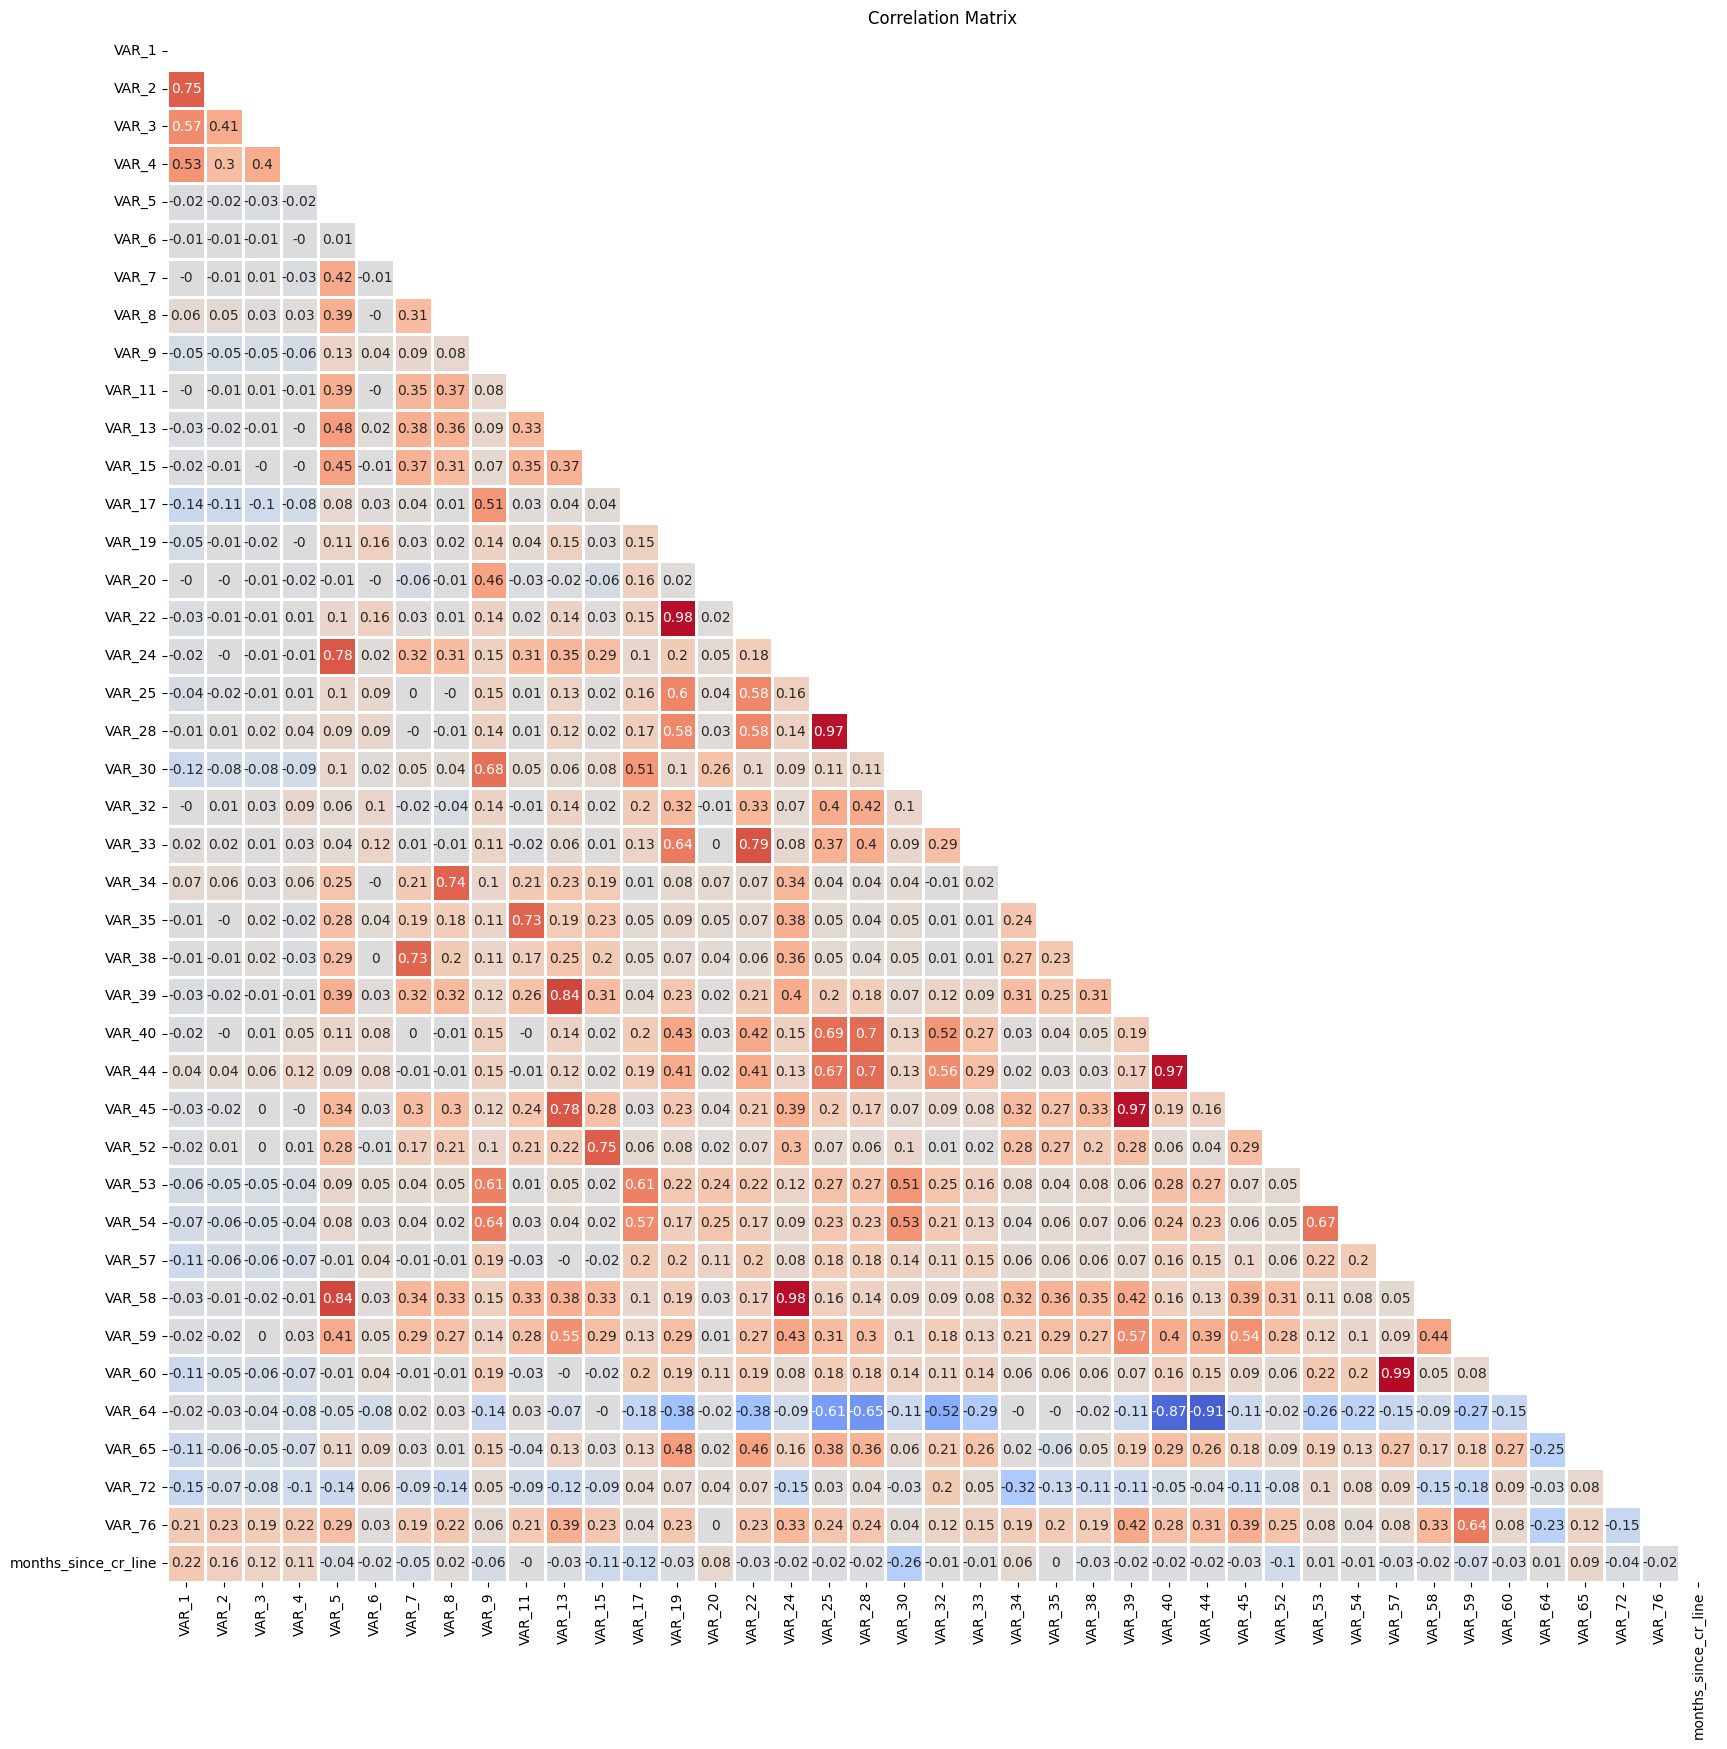

In [13]:
var = ['VAR_1', 'VAR_2', 'VAR_3', 'VAR_4',
       'VAR_5', 'VAR_6', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_11', 'VAR_13',
       'VAR_15', 'VAR_17', 'VAR_19', 'VAR_20', 'VAR_22', 'VAR_24',
       'VAR_25', 'VAR_28', 'VAR_30', 'VAR_32', 'VAR_33', 'VAR_34',
       'VAR_35', 'VAR_38', 'VAR_39', 'VAR_40', 'VAR_44', 'VAR_45',
       'VAR_52', 'VAR_53', 'VAR_54', 'VAR_57', 'VAR_58', 'VAR_59',
       'VAR_60', 'VAR_64', 'VAR_65', 'VAR_72', 'VAR_76', 'months_since_cr_line']
corr = df_inputs_prepr[var].corr().round(2)

# remove up side of the matrix
mask = np.zeros_like(corr,dtype='bool')
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,25))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center= 0, mask=mask, square= True, linewidths=1, cbar=False)
plt.title('Correlation Matrix')
plt.show()

In [14]:
# Print the highest correlation (0.8 or more)
high_corr = corr[corr.abs() > 0.8].stack().reset_index()
high_corr = high_corr[high_corr['level_0'] != high_corr['level_1']]  
print(high_corr)

   level_0 level_1     0
5    VAR_5  VAR_58  0.84
12  VAR_13  VAR_39  0.84
16  VAR_19  VAR_22  0.98
18  VAR_22  VAR_19  0.98
21  VAR_24  VAR_58  0.98
23  VAR_25  VAR_28  0.97
24  VAR_28  VAR_25  0.97
32  VAR_39  VAR_13  0.84
34  VAR_39  VAR_45  0.97
36  VAR_40  VAR_44  0.97
37  VAR_40  VAR_64 -0.87
38  VAR_44  VAR_40  0.97
40  VAR_44  VAR_64 -0.91
41  VAR_45  VAR_39  0.97
47  VAR_57  VAR_60  0.99
48  VAR_58   VAR_5  0.84
49  VAR_58  VAR_24  0.98
52  VAR_60  VAR_57  0.99
54  VAR_64  VAR_40 -0.87
55  VAR_64  VAR_44 -0.91


In [15]:
len(var)

41

In [16]:
# Remove variables with high correlation
corr_matrix = df_inputs_prepr[var].corr().abs() 
threshold = 0.8 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = [(column, row) for column in upper.columns for row in upper.index if upper[column][row] > threshold]
print("Features par with high correlation:", high_corr_pairs, "\n")

# Drop 
to_drop = []

for column, row in high_corr_pairs:
    to_drop.append(row)

to_drop = list(set(to_drop))
df_clean = df_inputs_prepr.drop(columns=to_drop)

print(f"Features dropped due high correlation: {to_drop}\n")
print(f"Features remaining: {df_clean.columns}")

Features par with high correlation: [('VAR_22', 'VAR_19'), ('VAR_28', 'VAR_25'), ('VAR_39', 'VAR_13'), ('VAR_44', 'VAR_40'), ('VAR_45', 'VAR_39'), ('VAR_58', 'VAR_5'), ('VAR_58', 'VAR_24'), ('VAR_60', 'VAR_57'), ('VAR_64', 'VAR_40'), ('VAR_64', 'VAR_44')] 

Features dropped due high correlation: ['VAR_40', 'VAR_19', 'VAR_57', 'VAR_13', 'VAR_25', 'VAR_39', 'VAR_24', 'VAR_44', 'VAR_5']

Features remaining: Index(['Unnamed: 0', 'id', 'safra', 'y', 'VAR_1', 'VAR_2', 'VAR_3', 'VAR_4',
       'VAR_6', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_11', 'VAR_15', 'VAR_17',
       'VAR_20', 'VAR_22', 'VAR_28', 'VAR_30', 'VAR_32', 'VAR_33', 'VAR_34',
       'VAR_35', 'VAR_38', 'VAR_45', 'VAR_52', 'VAR_53', 'VAR_54', 'VAR_58',
       'VAR_59', 'VAR_60', 'VAR_64', 'VAR_65', 'VAR_72', 'VAR_76', 'safra_dt',
       'months_since_cr_line'],
      dtype='object')


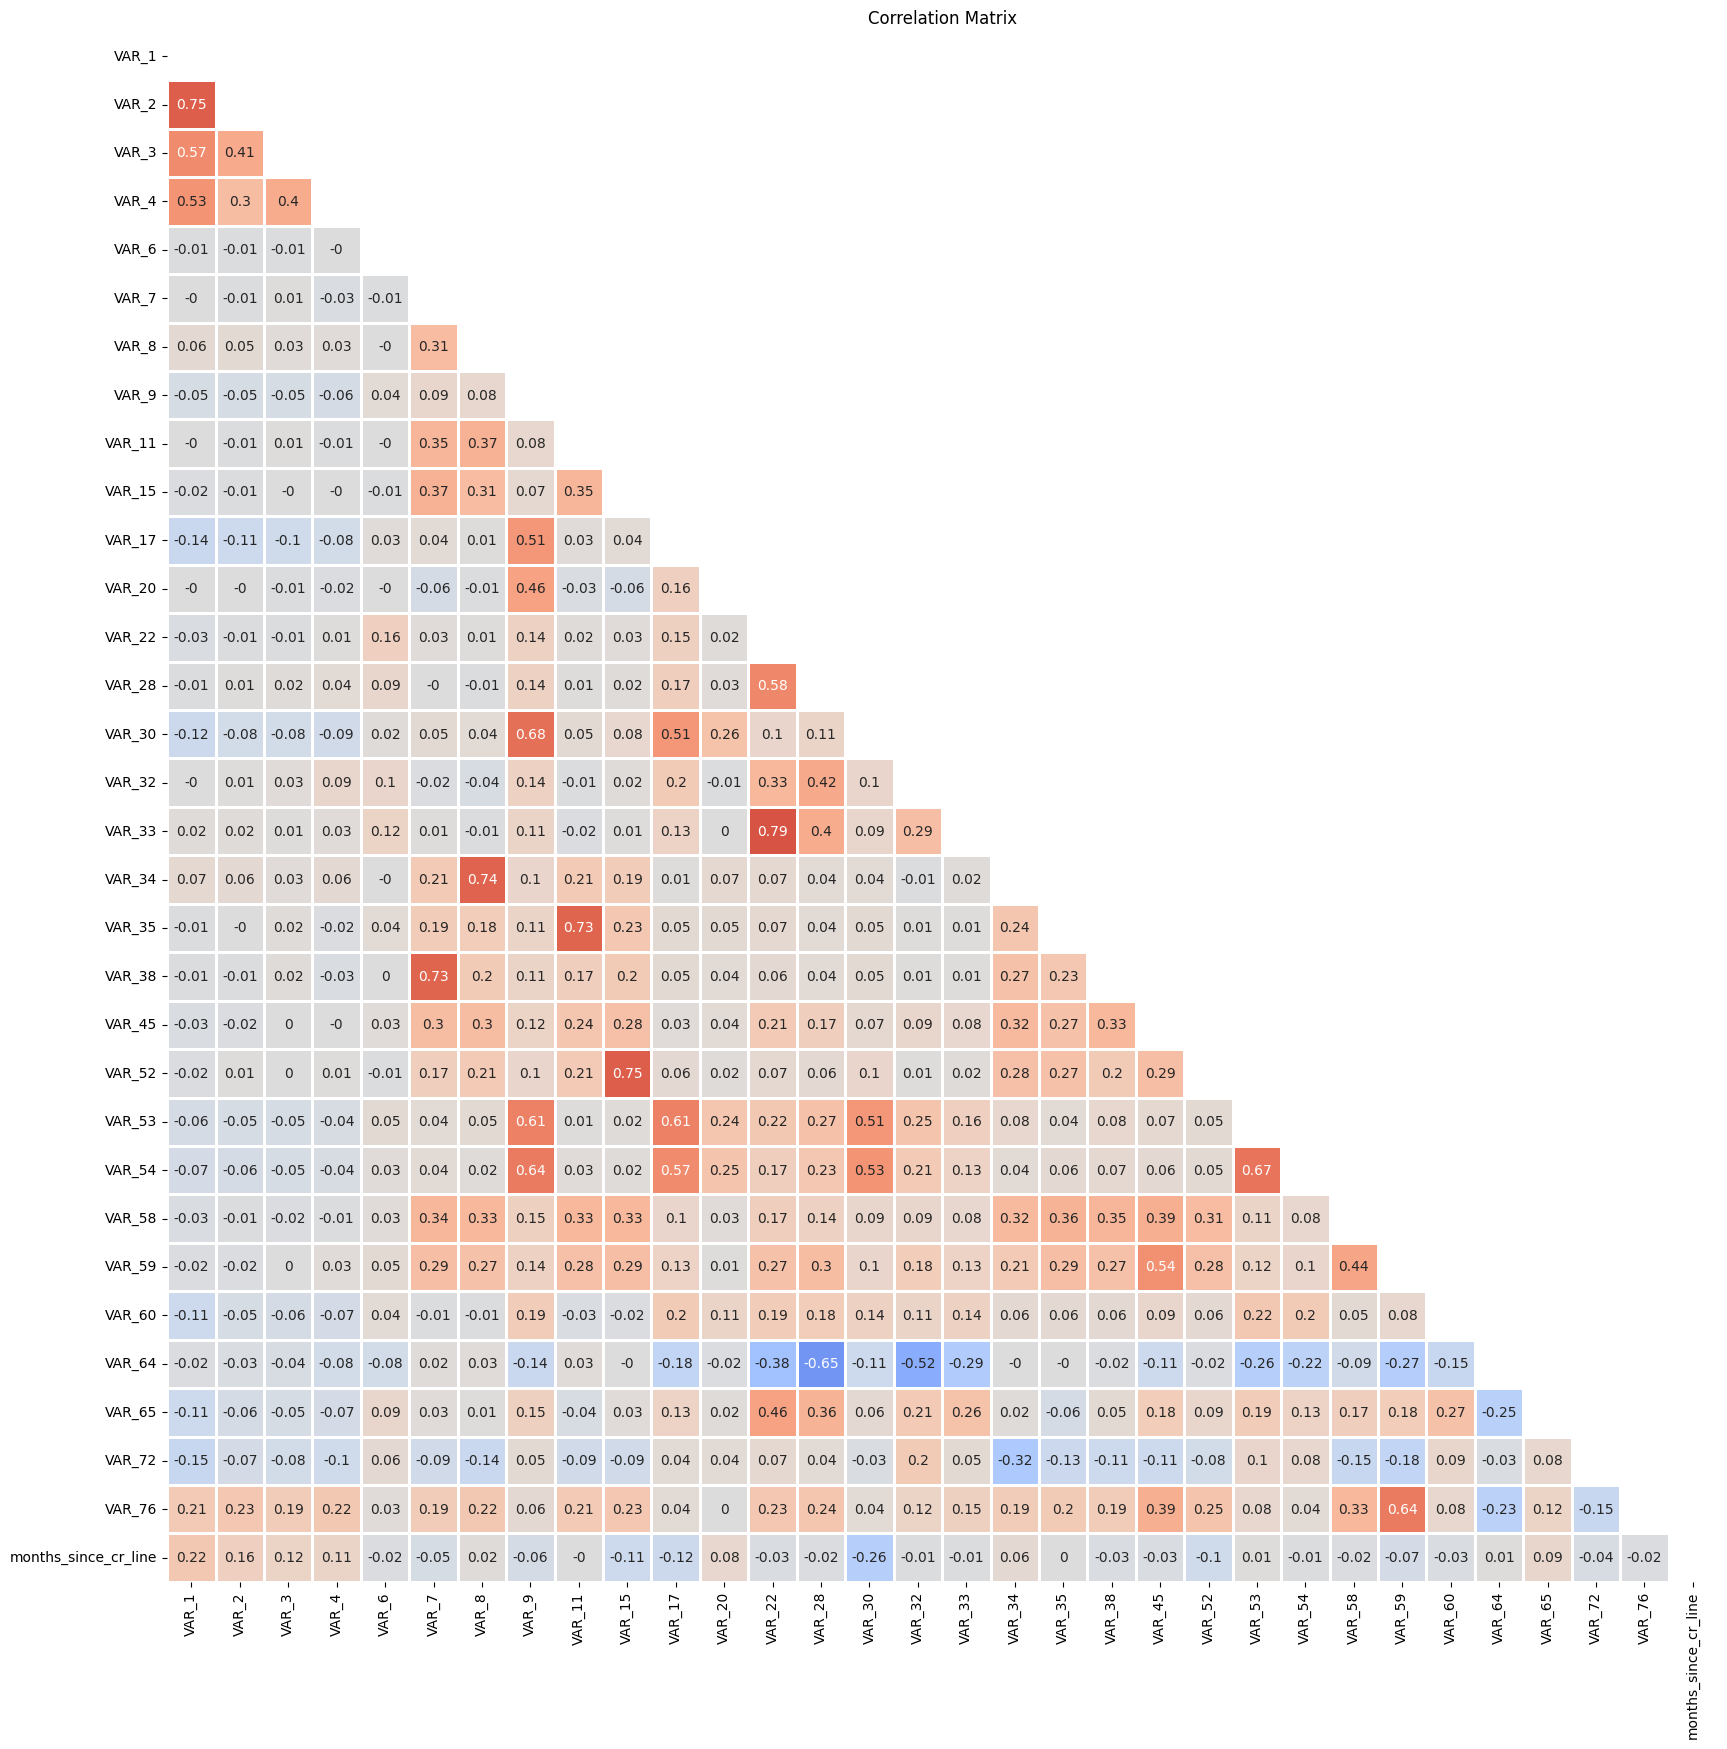

In [17]:
var2 = ['VAR_1', 'VAR_2', 'VAR_3', 'VAR_4',
       'VAR_6', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_11', 'VAR_15', 'VAR_17',
       'VAR_20', 'VAR_22', 'VAR_28', 'VAR_30', 'VAR_32', 'VAR_33', 'VAR_34',
       'VAR_35', 'VAR_38', 'VAR_45', 'VAR_52', 'VAR_53', 'VAR_54', 'VAR_58',
       'VAR_59', 'VAR_60', 'VAR_64', 'VAR_65', 'VAR_72', 'VAR_76', 'months_since_cr_line']

corr2 = df_clean[var2].corr().round(2)

# remove up side of the matrix
mask = np.zeros_like(corr2,dtype='bool')
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,25))
sns.heatmap(corr2, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center= 0, mask=mask, square= True, linewidths=1, cbar=False)
plt.title('Correlation Matrix')
plt.show()

In [18]:
df_clean.shape

(8590, 37)

In [19]:
df_inputs_prepr = df_clean.copy()

### 3. WoE for Fine and Coarse Classing

In [20]:
def WoE_IV_Numeric(data, target, col):
    tab1 = pd.crosstab(index=data[col], columns=target, margins_name='Total', margins=True)
    tab1.columns = ['Bad','Good','Total']
    tab1 = tab1.reset_index()

    # Proportions 
    tab1['%Total'] = tab1['Total']/data.shape[0]
    tab1['%Bad'] = (tab1['Bad']/tab1.tail(1)['Bad'].values)
    tab1['%Good'] = (tab1['Good']/tab1.tail(1)['Good'].values)
    tab1['DefaultRate'] = (tab1['Bad']/tab1['Total'])

    # WoE = ln (%Good/%Bad)
    tab1['WoE'] = np.log(tab1['%Good']/tab1['%Bad'])
    tab1 = tab1.iloc[:-1,:]#.sort_values(by='WoE')
    tab1['diff_WoE'] = tab1['WoE'].diff().abs()

    # IV = sum ((%Good - % Bad) * WoE)
    IV = (tab1['%Good']-tab1['%Bad'])*tab1['WoE']
    tab1['IV'] = IV.sum()

    return tab1

In [21]:
def plot_by_woe(df_woe,rotation_x_labels = 0):
    x = np.array(df_woe.iloc[:,0].apply(str))
    y = df_woe['WoE']
    plt.figure(figsize=(18,6))
    plt.plot(x, y, marker='o', linestyle='--',color='k')
    plt.xlabel(df_woe.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_woe.columns[0]))
    plt.xticks(rotation=rotation_x_labels)

In [22]:
df_inputs_prepr.columns.values

array(['Unnamed: 0', 'id', 'safra', 'y', 'VAR_1', 'VAR_2', 'VAR_3',
       'VAR_4', 'VAR_6', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_11', 'VAR_15',
       'VAR_17', 'VAR_20', 'VAR_22', 'VAR_28', 'VAR_30', 'VAR_32',
       'VAR_33', 'VAR_34', 'VAR_35', 'VAR_38', 'VAR_45', 'VAR_52',
       'VAR_53', 'VAR_54', 'VAR_58', 'VAR_59', 'VAR_60', 'VAR_64',
       'VAR_65', 'VAR_72', 'VAR_76', 'safra_dt', 'months_since_cr_line'],
      dtype=object)

In [23]:
var = ['VAR_1', 'VAR_2', 'VAR_3', 'VAR_4',
       'VAR_6', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_11', 'VAR_15', 'VAR_17',
       'VAR_20', 'VAR_22', 'VAR_28', 'VAR_30', 'VAR_32', 'VAR_33',
       'VAR_34', 'VAR_35', 'VAR_38', 'VAR_45', 'VAR_52', 'VAR_53',
       'VAR_54', 'VAR_58', 'VAR_59', 'VAR_60', 'VAR_64', 'VAR_65',
       'VAR_72', 'VAR_76','months_since_cr_line']

summary = pd.DataFrame({
        'Feature': df_inputs_prepr[var].columns,  # feature name
        'Unique values': [df_inputs_prepr[col].nunique() for col in df_inputs_prepr[var].columns],  # unique values count
        'Pct Missing (%)': [round(df_inputs_prepr[col].isnull().mean() * 100,2) for col in df_inputs_prepr[var].columns]  # mising values percent
    })
summary

Feature  Unique values  Pct Missing (%)
0                  VAR_1            196             3.97
1                  VAR_2             15             3.97
2                  VAR_3             11             3.97
3                  VAR_4             14             3.97
4                  VAR_6           3186             0.90
5                  VAR_7           3333            43.27
6                  VAR_8           3299            45.37
7                  VAR_9           1673             0.00
8                 VAR_11           3180            46.94
9                 VAR_15           3128            47.43
10                VAR_17           1591            41.69
11                VAR_20             10             0.00
12                VAR_22            120             0.62
13                VAR_28             13             0.62
14                VAR_30           2199             0.47
15                VAR_32              9             0.00
16                VAR_33             47             0.62
17                VAR_34           3597            45.37
18                VAR_35           3452            46.94
19                VAR_38           3648            43.27
20                VAR_45           3803            48.89
21                VAR_52           3412            47.43
22                VAR_53           2657            16.33
23                VAR_54           2241            11.69
24                VAR_58            992            38.27
25                VAR_59           4416            42.54
26                VAR_60             20             0.00
27                VAR_64              2             0.00
28                VAR_65           6356            20.97
29                VAR_72           1140             0.90
30                VAR_76           4662            42.54
31  months_since_cr_line             12             0.00

In [24]:
summary['Unique values'].describe()

count      32.000000
mean     1951.062500
std      1802.470615
min         2.000000
25%        18.750000
50%      1936.000000
75%      3352.750000
max      6356.000000
Name: Unique values, dtype: float64

<Axes: xlabel='Unique values', ylabel='Density'>

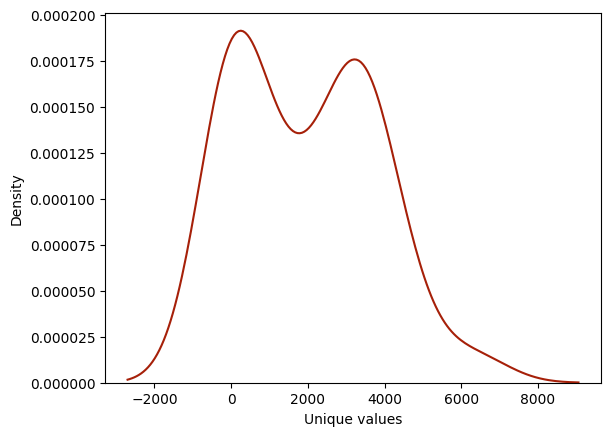

In [25]:
sns.kdeplot(x=summary['Unique values'],color='#a62009')

#### 3.1 Features with less or equal to 50 unique values

In [26]:
summary[summary['Unique values'] <= 50]['Feature'].unique()

array(['VAR_2', 'VAR_3', 'VAR_4', 'VAR_20', 'VAR_28', 'VAR_32', 'VAR_33',
       'VAR_60', 'VAR_64', 'months_since_cr_line'], dtype=object)

VAR_2   Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0    0.0  1792  5500   7292  0.848894  0.736237  0.945830     0.245749   
1    1.0    92    78    170  0.019790  0.037798  0.013414     0.541176   
2    2.0   106    41    147  0.017113  0.043550  0.007051     0.721088   
3    3.0   324    90    414  0.048196  0.133114  0.015477     0.782609   
4    4.0    39    28     67  0.007800  0.016023  0.004815     0.582090   
5    5.0    33    19     52  0.006054  0.013558  0.003267     0.634615   
6    6.0    17    15     32  0.003725  0.006984  0.002580     0.531250   
7    7.0    11    15     26  0.003027  0.004519  0.002580     0.423077   
8    8.0     5     6     11  0.001281  0.002054  0.001032     0.454545   
9    9.0     5     4      9  0.001048  0.002054  0.000688     0.555556   
10  10.0     5     9     14  0.001630  0.002054  0.001548     0.357143   
11  11.0     3     5      8  0.000931  0.001233  0.000860     0.375000   
12  12.0     0     1      1  0.000116  0.000000  0.000172     0.000000   
13  13.0     2     3      5  0.000582  0.000822  0.000516     0.400000   
14  14.0     0     1      1  0.000116  0.000000  0.000172     0.000000   

         WoE  diff_WoE   IV  
0   0.250511       NaN  inf  
1  -1.035985  1.286496  inf  
2  -1.820772  0.784787  inf  
3  -2.151839  0.331067  inf  
4  -1.202262  0.949577  inf  
5  -1.422973  0.220711  inf  
6  -0.996068  0.426905  inf  
7  -0.560750  0.435318  inf  
8  -0.688583  0.127833  inf  
9  -1.094048  0.405465  inf  
10 -0.283118  0.810930  inf  
11 -0.360079  0.076961  inf  
12       inf       inf  inf  
13 -0.465440       inf  inf  
14       inf       inf  inf

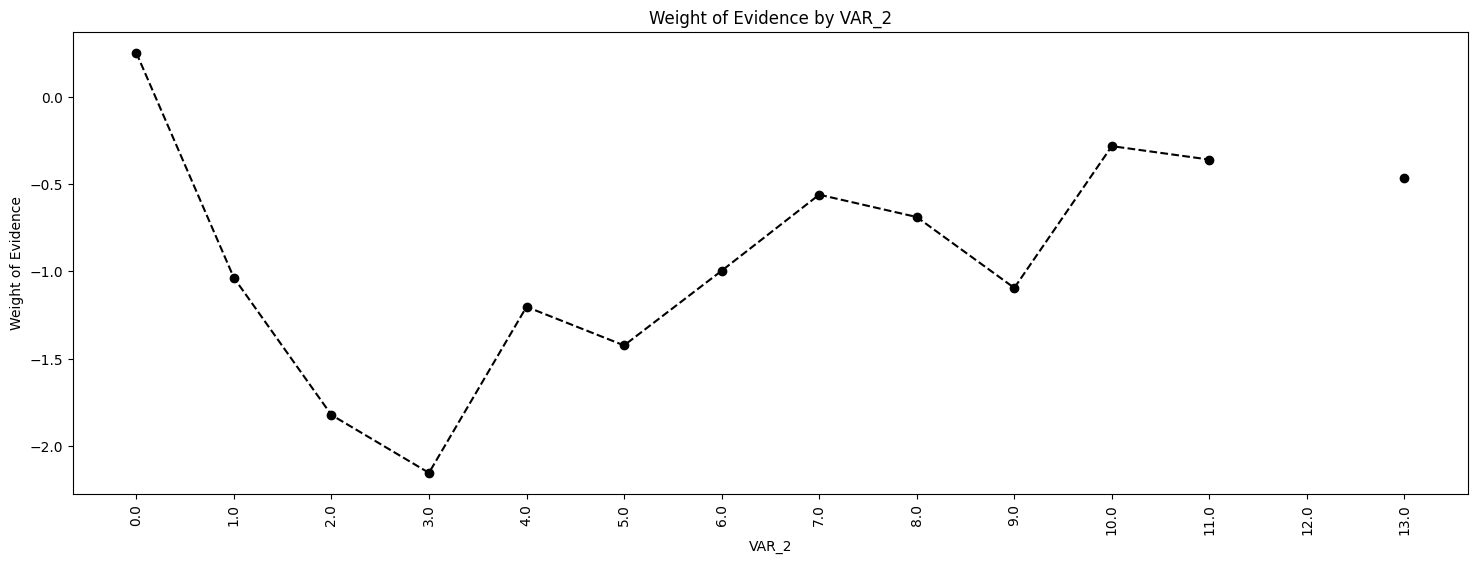

In [27]:
# VAR_2
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_2')
display(WoE)
plot_by_woe(WoE,90)

In [28]:
df_inputs_prepr['VAR_2'].isnull().sum()

341

In [29]:
# VAR_2: 84% of observations contain the value 0
df_inputs_prepr['VAR_2:0'] = np.where((df_inputs_prepr['VAR_2'] == 0), 1, 0)
df_inputs_prepr['VAR_2:1-14_or_missing'] = np.where((df_inputs_prepr['VAR_2'].isin(range(1,15))) | (df_inputs_prepr['VAR_2'].isnull()), 1, 0)

VAR_3   Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0    0.0  1593  5227   6820  0.793946  0.654478  0.898882     0.233578   
1    1.0   674   380   1054  0.122701  0.276910  0.065348     0.639469   
2    2.0    87    88    175  0.020373  0.035744  0.015133     0.497143   
3    3.0    34    37     71  0.008265  0.013969  0.006363     0.478873   
4    4.0    19    28     47  0.005471  0.007806  0.004815     0.404255   
5    5.0    10    27     37  0.004307  0.004108  0.004643     0.270270   
6    6.0     9     5     14  0.001630  0.003698  0.000860     0.642857   
7    7.0     5     8     13  0.001513  0.002054  0.001376     0.384615   
8    8.0     2    10     12  0.001397  0.000822  0.001720     0.166667   
9    9.0     1     3      4  0.000466  0.000411  0.000516     0.250000   
10  10.0     0     2      2  0.000233  0.000000  0.000344     0.000000   

         WoE  diff_WoE   IV  
0   0.317314       NaN  inf  
1  -1.443964  1.761277  inf  
2  -0.859476  0.584488  inf  
3  -0.786347  0.073129  inf  
4  -0.483139  0.303208  inf  
5   0.122347  0.605486  inf  
6  -1.458691  1.581038  inf  
7  -0.400901  1.057790  inf  
8   0.738533  1.139434  inf  
9   0.227707  0.510826  inf  
10       inf       inf  inf

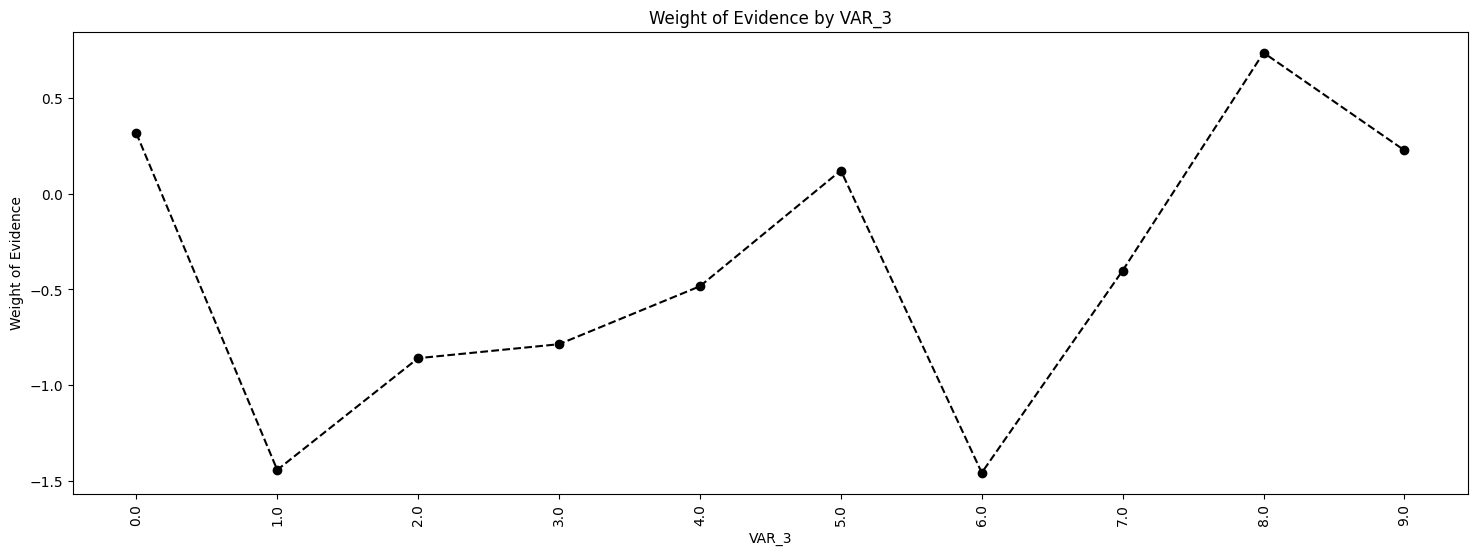

In [30]:
# VAR_3
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_3')
display(WoE)
plot_by_woe(WoE,90)

In [31]:
df_inputs_prepr['VAR_3'].isnull().sum()

341

In [32]:
# VAR_3: 79% of observations contain the value 0
df_inputs_prepr['VAR_3:Missing'] = np.where((df_inputs_prepr['VAR_3'].isnull()), 1, 0)
df_inputs_prepr['VAR_3:0'] = np.where((df_inputs_prepr['VAR_3'] == 0), 1, 0)
df_inputs_prepr['VAR_3:1-10'] = np.where((df_inputs_prepr['VAR_3'] > 0) & (df_inputs_prepr['VAR_3'] <= 10), 1, 0)

VAR_4   Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0    0.0  1231  4492   5723  0.666240  0.505752  0.772485     0.215097   
1    1.0   770   742   1512  0.176019  0.316352  0.127601     0.509259   
2    2.0   240   261    501  0.058324  0.098603  0.044884     0.479042   
3    3.0    81   118    199  0.023166  0.033279  0.020292     0.407035   
4    4.0    45    81    126  0.014668  0.018488  0.013929     0.357143   
5    5.0    29    57     86  0.010012  0.011915  0.009802     0.337209   
6    6.0    20    25     45  0.005239  0.008217  0.004299     0.444444   
7    7.0     6    15     21  0.002445  0.002465  0.002580     0.285714   
8    8.0     9    11     20  0.002328  0.003698  0.001892     0.450000   
9    9.0     1     4      5  0.000582  0.000411  0.000688     0.200000   
10  10.0     0     6      6  0.000698  0.000000  0.001032     0.000000   
11  11.0     0     1      1  0.000116  0.000000  0.000172     0.000000   
12  12.0     1     1      2  0.000233  0.000411  0.000172     0.500000   
13  13.0     1     1      2  0.000233  0.000411  0.000172     0.500000   

         WoE  diff_WoE   IV  
0   0.423566       NaN  inf  
1  -0.907946  1.331512  inf  
2  -0.787023  0.120923  inf  
3  -0.494669  0.292354  inf  
4  -0.283118  0.211551  inf  
5  -0.195149  0.087969  inf  
6  -0.647761  0.452612  inf  
7   0.045386  0.693147  inf  
8  -0.670234  0.715620  inf  
9   0.515390  1.185624  inf  
10       inf       inf  inf  
11       inf       NaN  inf  
12 -0.870905       inf  inf  
13 -0.870905  0.000000  inf

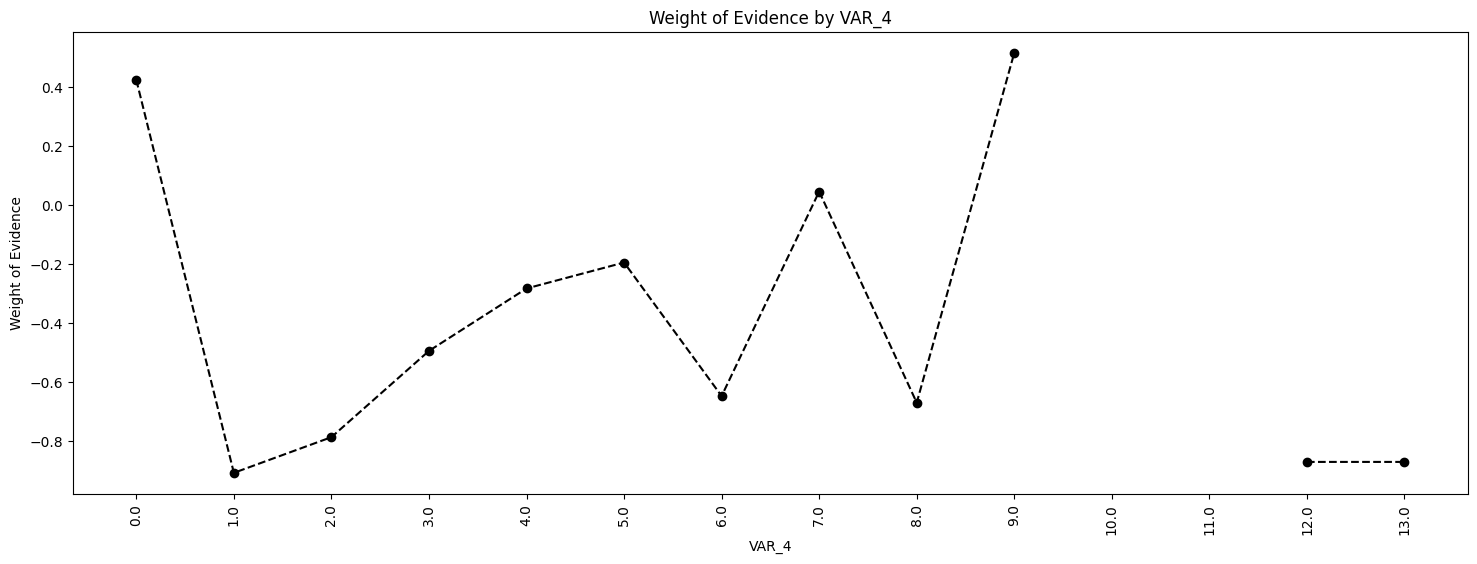

In [33]:
# VAR_4
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_4')
display(WoE)
plot_by_woe(WoE,90)

In [34]:
df_inputs_prepr['VAR_4'].isnull().sum()

341

In [35]:
# VAR_4: 66% of observations contain the value 0
df_inputs_prepr['VAR_4:Missing'] = np.where((df_inputs_prepr['VAR_4'].isnull()), 1, 0)
df_inputs_prepr['VAR_4:0'] = np.where((df_inputs_prepr['VAR_4']==0), 1, 0)
df_inputs_prepr['VAR_4:1-14'] = np.where((df_inputs_prepr['VAR_4'].isin(range(1,14))), 1, 0)

VAR_20   Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0      3    21   312    333  0.038766  0.008370  0.051307     0.063063   
1      4    26   180    206  0.023981  0.010363  0.029600     0.126214   
2      5    63   280    343  0.039930  0.025110  0.046045     0.183673   
3      6    98   397    495  0.057625  0.039059  0.065285     0.197980   
4      7    12    98    110  0.012806  0.004783  0.016116     0.109091   
5      8    65   270    335  0.038999  0.025907  0.044401     0.194030   
6      9    17    54     71  0.008265  0.006776  0.008880     0.239437   
7     10   183   502    685  0.079744  0.072937  0.082552     0.267153   
8     11     4     7     11  0.001281  0.001594  0.001151     0.363636   
9     12  2020  3981   6001  0.698603  0.805102  0.654662     0.336611   

        WoE  diff_WoE        IV  
0  1.813196       NaN  0.180965  
1  1.049575  0.763620  0.180965  
2  0.606370  0.443205  0.180965  
3  0.513684  0.092686  0.180965  
4  1.214776  0.701092  0.180965  
5  0.538750  0.676026  0.180965  
6  0.270486  0.268264  0.180965  
7  0.123829  0.146657  0.180965  
8 -0.325669  0.449498  0.180965  
9 -0.206849  0.118820  0.180965

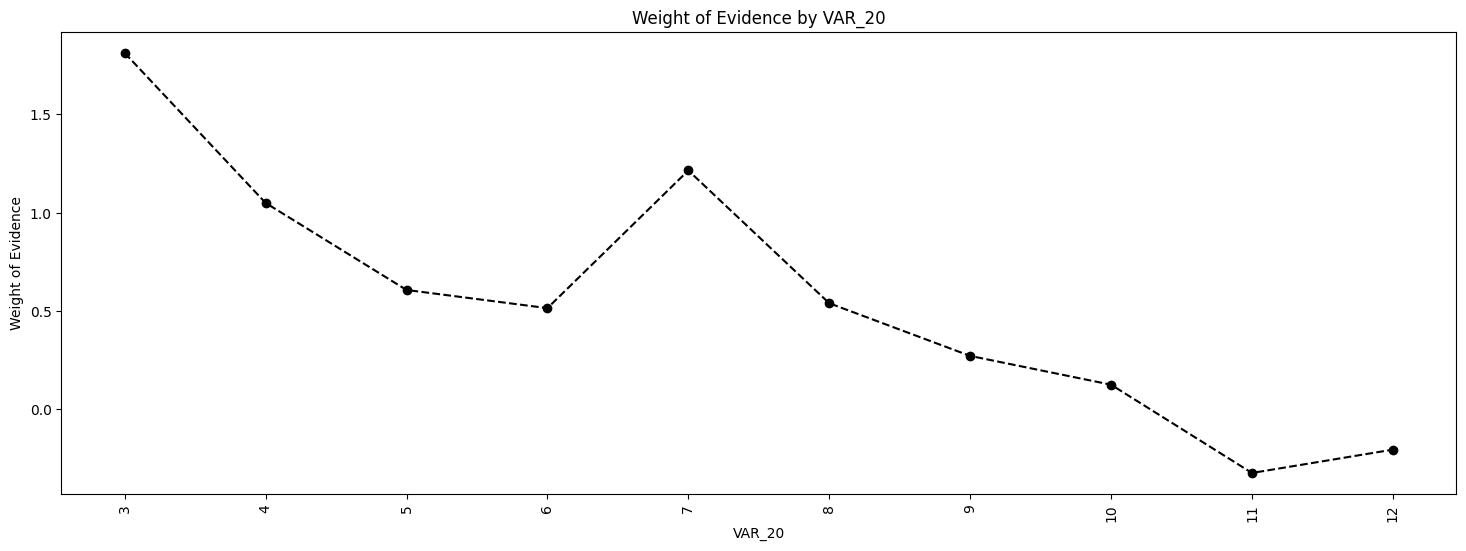

In [36]:
# VAR_20
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_20')
display(WoE)
plot_by_woe(WoE,90)

In [37]:
df_inputs_prepr['VAR_20'].isnull().sum()

0

In [38]:
# VAR_20: 69% with value 12
df_inputs_prepr['VAR_20:3-10'] = np.where((df_inputs_prepr['VAR_20']<=10), 1, 0)
df_inputs_prepr['VAR_20:11-12'] = np.where((df_inputs_prepr['VAR_20']>=11), 1, 0)

VAR_28   Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0     0.0  1900  3638   5538  0.644703  0.761218  0.602218     0.343084   
1     1.0    47   136    183  0.021304  0.018830  0.022513     0.256831   
2     2.0    32   117    149  0.017346  0.012821  0.019368     0.214765   
3     3.0    32   117    149  0.017346  0.012821  0.019368     0.214765   
4     4.0    33   124    157  0.018277  0.013221  0.020526     0.210191   
5     5.0    34   139    173  0.020140  0.013622  0.023009     0.196532   
6     6.0    27   117    144  0.016764  0.010817  0.019368     0.187500   
7     7.0    39   157    196  0.022817  0.015625  0.025989     0.198980   
8     8.0    48   115    163  0.018976  0.019231  0.019037     0.294479   
9     9.0    36   147    183  0.021304  0.014423  0.024334     0.196721   
10   10.0    45   185    230  0.026775  0.018029  0.030624     0.195652   
11   11.0    72   314    386  0.044936  0.028846  0.051978     0.186528   
12   12.0   151   735    886  0.103143  0.060497  0.121669     0.170429   

         WoE  diff_WoE        IV  
0  -0.234300       NaN  0.129923  
1   0.178627  0.412927  0.129923  
2   0.412558  0.233931  0.129923  
3   0.412558  0.000000  0.129923  
4   0.439894  0.027336  0.129923  
5   0.524233  0.084339  0.129923  
6   0.582457  0.058224  0.129923  
7   0.508804  0.073653  0.129923  
8  -0.010149  0.518953  0.129923  
9   0.523034  0.533183  0.129923  
10  0.529813  0.006780  0.129923  
11  0.588847  0.059034  0.129923  
12  0.698711  0.109864  0.129923

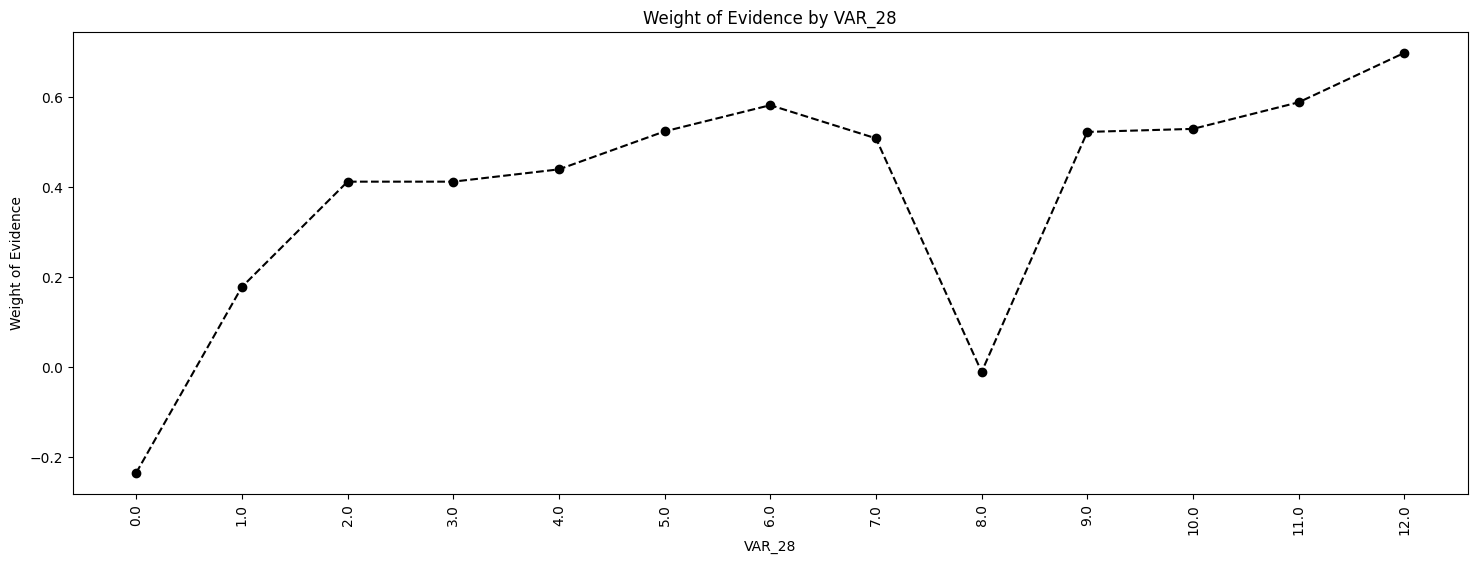

In [39]:
# VAR_28
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_28')
display(WoE)
plot_by_woe(WoE,90)

In [40]:
df_inputs_prepr['VAR_28'].isnull().sum()

53

In [41]:
# VAR_28: 64% of 0 value
df_inputs_prepr['VAR_28:Missing'] = np.where((df_inputs_prepr['VAR_28'].isnull()), 1, 0)
df_inputs_prepr['VAR_28:0_8'] = np.where((df_inputs_prepr['VAR_28'].isin([0,8])), 1, 0)
df_inputs_prepr['VAR_28:1-7_9-12'] = np.where((df_inputs_prepr['VAR_28'].isin([1,2,3,4,5,6,7,9,10,11,12])), 1, 0)

/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_32   Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0 -0.151024     1     2      3  0.000349  0.000399  0.000329     0.333333   
1 -0.103405     1     1      2  0.000233  0.000399  0.000164     0.500000   
2 -0.038614     1     1      2  0.000233  0.000399  0.000164     0.500000   
3 -0.011574     1     0      1  0.000116  0.000399  0.000000     1.000000   
4  0.020019     7     6     13  0.001513  0.002790  0.000987     0.538462   
5  0.046709    28    45     73  0.008498  0.011160  0.007400     0.383562   
6  0.057198   346   451    797  0.092782  0.137904  0.074165     0.434128   
7  0.090634   755  1237   1992  0.231898  0.300917  0.203420     0.379016   
8  0.133833  1369  4338   5707  0.664377  0.545636  0.713370     0.239881   

        WoE  diff_WoE   IV  
0 -0.192138       NaN  inf  
1 -0.885285  0.693147  inf  
2 -0.885285  0.000000  inf  
3      -inf       inf  inf  
4 -1.039436       inf  inf  
5 -0.410827  0.628609  inf  
6 -0.620256  0.209429  inf  
7 -0.391558  0.228698  inf  
8  0.268048  0.659606  inf

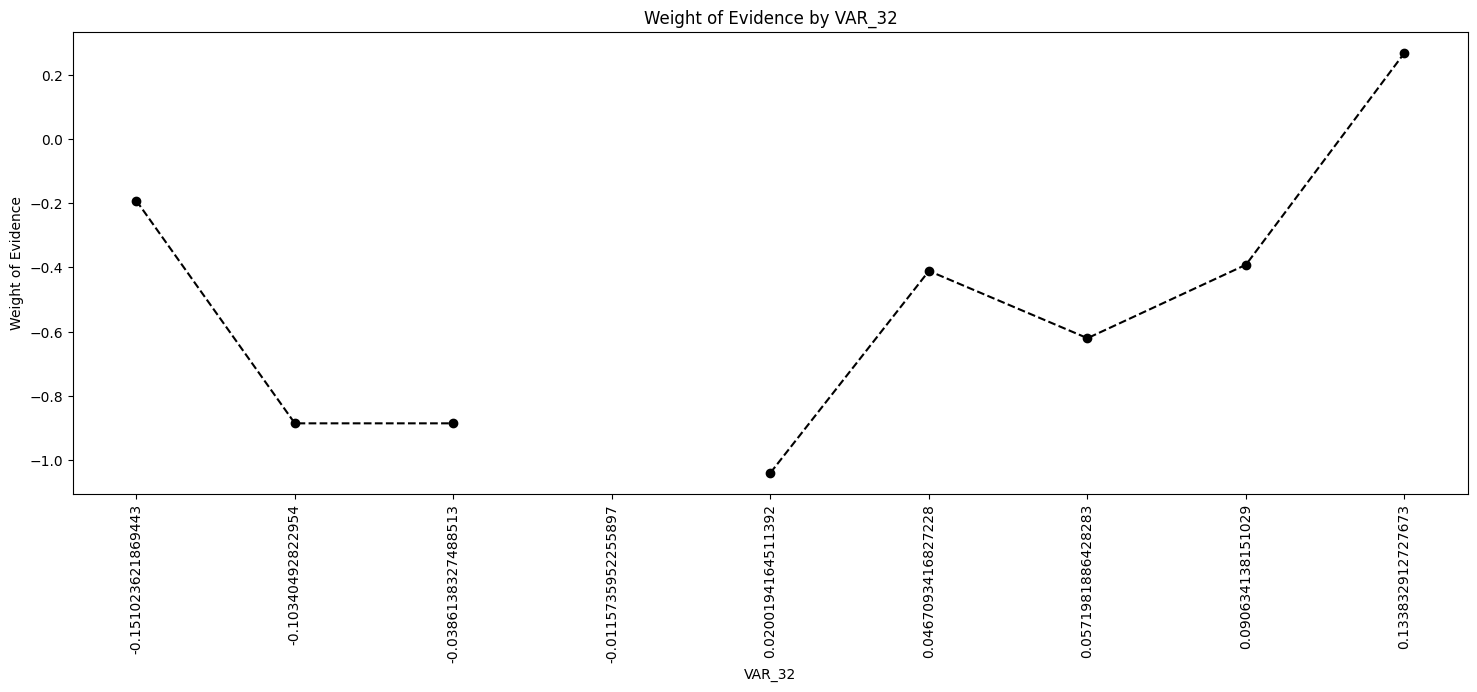

In [42]:
# VAR_32
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_32')
display(WoE)
plot_by_woe(WoE,90)

In [43]:
df_inputs_prepr['VAR_32'].isnull().sum()

0

In [44]:
# VAR_32
df_inputs_prepr['VAR_32:<0.13'] = np.where((df_inputs_prepr['VAR_32']< 0.13), 1, 0)
df_inputs_prepr['VAR_32:>=0.13'] = np.where((df_inputs_prepr['VAR_32']>=0.13), 1, 0)

/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_33   Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0     0.0  1950  3736   5686  0.661932  0.781250  0.618441     0.342948   
1     1.0    90   437    527  0.061350  0.036058  0.072339     0.170778   
2     2.0    50   273    323  0.037602  0.020032  0.045191     0.154799   
3     3.0    54   182    236  0.027474  0.021635  0.030127     0.228814   
4     4.0    42   195    237  0.027590  0.016827  0.032279     0.177215   
5     5.0    47   159    206  0.023981  0.018830  0.026320     0.228155   
6     6.0    42   158    200  0.023283  0.016827  0.026155     0.210000   
7     7.0    29   110    139  0.016182  0.011619  0.018209     0.208633   
8     8.0    25    97    122  0.014203  0.010016  0.016057     0.204918   
9     9.0    18    83    101  0.011758  0.007212  0.013739     0.178218   
10   10.0    20    81    101  0.011758  0.008013  0.013408     0.198020   
11   11.0     8    67     75  0.008731  0.003205  0.011091     0.106667   
12   12.0    14    56     70  0.008149  0.005609  0.009270     0.200000   
13   13.0    11    40     51  0.005937  0.004407  0.006621     0.215686   
14   14.0    14    46     60  0.006985  0.005609  0.007615     0.233333   
15   15.0     6    34     40  0.004657  0.002404  0.005628     0.150000   
16   16.0     9    29     38  0.004424  0.003606  0.004801     0.236842   
17   17.0     4    29     33  0.003842  0.001603  0.004801     0.121212   
18   18.0     8    15     23  0.002678  0.003205  0.002483     0.347826   
19   19.0     7    18     25  0.002910  0.002804  0.002980     0.280000   
20   20.0     2    21     23  0.002678  0.000801  0.003476     0.086957   
21   21.0     2    21     23  0.002678  0.000801  0.003476     0.086957   
22   22.0     2    24     26  0.003027  0.000801  0.003973     0.076923   
23   23.0     5     8     13  0.001513  0.002003  0.001324     0.384615   
24   24.0     4    18     22  0.002561  0.001603  0.002980     0.181818   
25   25.0     2    13     15  0.001746  0.000801  0.002152     0.133333   
26   26.0     2     7      9  0.001048  0.000801  0.001159     0.222222   
27   27.0     2     9     11  0.001281  0.000801  0.001490     0.181818   
28   28.0     3     9     12  0.001397  0.001202  0.001490     0.250000   
29   29.0     3     3      6  0.000698  0.001202  0.000497     0.500000   
30   30.0     1     8      9  0.001048  0.000401  0.001324     0.111111   
31   31.0     5    16     21  0.002445  0.002003  0.002649     0.238095   
32   32.0     1     6      7  0.000815  0.000401  0.000993     0.142857   
33   33.0     3     6      9  0.001048  0.001202  0.000993     0.333333   
34   34.0     0     5      5  0.000582  0.000000  0.000828     0.000000   
35   35.0     2     5      7  0.000815  0.000801  0.000828     0.285714   
36   36.0     2     5      7  0.000815  0.000801  0.000828     0.285714   
37   37.0     0     3      3  0.000349  0.000000  0.000497     0.000000   
38   38.0     1     1      2  0.000233  0.000401  0.000166     0.500000   
39   39.0     0     1      1  0.000116  0.000000  0.000166     0.000000   
40   41.0     0     2      2  0.000233  0.000000  0.000331     0.000000   
41   42.0     2     1      3  0.000349  0.000801  0.000166     0.666667   
42   43.0     2     0      2  0.000233  0.000801  0.000000     1.000000   
43   44.0     1     1      2  0.000233  0.000401  0.000166     0.500000   
44   45.0     0     1      1  0.000116  0.000000  0.000166     0.000000   
45   48.0     0     2      2  0.000233  0.000000  0.000331     0.000000   
46   51.0     1     0      1  0.000116  0.000401  0.000000     1.000000   

         WoE  diff_WoE   IV  
0  -0.233694       NaN  inf  
1   0.696243  0.929937  inf  
2   0.813569  0.117325  inf  
3   0.331143  0.482426  inf  
4   0.651450  0.320307  inf  
5   0.334876  0.316573  inf  
6   0.441045  0.106169  inf  
7   0.449304  0.008259  inf  
8   0.471955  0.022651  inf  
9   0.644589  0.172634  inf  
10  0.514837  0.129752  inf  
11  1.241371  0.726534  inf  
12  0.502414

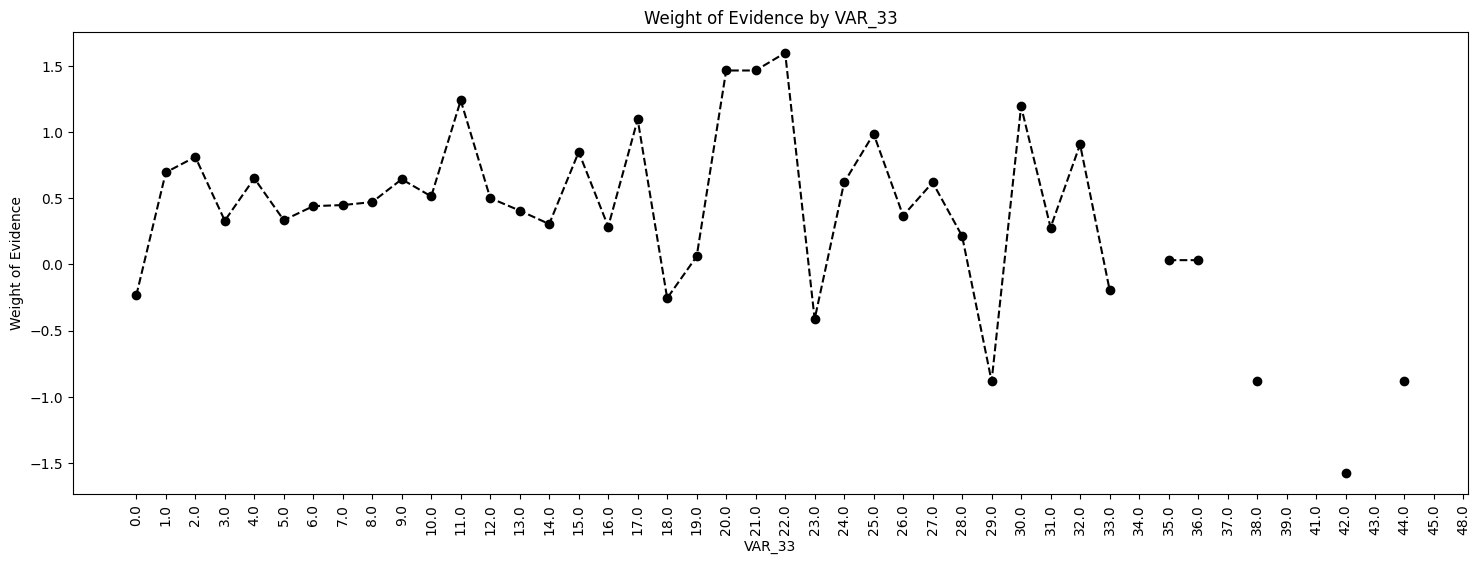

In [45]:
# VAR_33
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_33')
display(WoE)
plot_by_woe(WoE,90)

In [46]:
df_inputs_prepr['VAR_33'].isnull().sum()

53

In [47]:
# VAR_33
df_inputs_prepr['VAR_33:0'] = np.where((df_inputs_prepr['VAR_33']== 0), 1, 0)
df_inputs_prepr['VAR_33:>0_or_missing'] = np.where((df_inputs_prepr['VAR_33']>0) | (df_inputs_prepr['VAR_33'].isnull()), 1, 0)

VAR_60  Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0  -0.690749   77   129    206  0.023981  0.030690  0.021214     0.373786   
1  -0.411787  388   638   1026  0.119441  0.154643  0.104917     0.378168   
2  -0.354108  137   231    368  0.042841  0.054603  0.037987     0.372283   
3  -0.308453  135   257    392  0.045634  0.053806  0.042263     0.344388   
4  -0.231735  313   528    841  0.097905  0.124751  0.086828     0.372176   
5  -0.133344  129   284    413  0.048079  0.051415  0.046703     0.312349   
6  -0.073756   76   159    235  0.027357  0.030291  0.026147     0.323404   
7  -0.059299  142   287    429  0.049942  0.056596  0.047196     0.331002   
8  -0.030478   84   168    252  0.029336  0.033479  0.027627     0.333333   
9  -0.016209   71   188    259  0.030151  0.028298  0.030916     0.274131   
10  0.079926  202   535    737  0.085797  0.080510  0.087979     0.274084   
11  0.156301  183   521    704  0.081956  0.072937  0.085677     0.259943   
12   0.21938  146   534    680  0.079162  0.058191  0.087815     0.214706   
13   0.24288   41   152    193  0.022468  0.016341  0.024996     0.212435   
14  0.319425   40   135    175  0.020373  0.015943  0.022200     0.228571   
15  0.357324  167   536    703  0.081839  0.066560  0.088143     0.237553   
16  0.412256   22   105    127  0.014785  0.008768  0.017267     0.173228   
17  0.534878   63   228    291  0.033877  0.025110  0.037494     0.216495   
18  0.648197   28   167    195  0.022701  0.011160  0.027463     0.143590   
19   0.72163   65   299    364  0.042375  0.025907  0.049170     0.178571   

         WoE  diff_WoE        IV  
0  -0.369278       NaN  0.116503  
1  -0.387952  0.018674  0.116503  
2  -0.362848  0.025104  0.116503  
3  -0.241484  0.121365  0.116503  
4  -0.362392  0.120908  0.116503  
5  -0.096123  0.266269  0.116503  
6  -0.147114  0.050991  0.116503  
7  -0.181630  0.034516  0.116503  
8  -0.192138  0.010508  0.116503  
9   0.088477  0.280615  0.116503  
10  0.088714  0.000237  0.116503  
11  0.160979  0.072265  0.116503  
12  0.411504  0.250525  0.116503  
13  0.425024  0.013519  0.116503  
14  0.331110  0.093913  0.116503  
15  0.280855  0.050255  0.116503  
16  0.677633  0.396778  0.116503  
17  0.400926  0.276707  0.116503  
18  0.900504  0.499578  0.116503  
19  0.640771  0.259733  0.116503

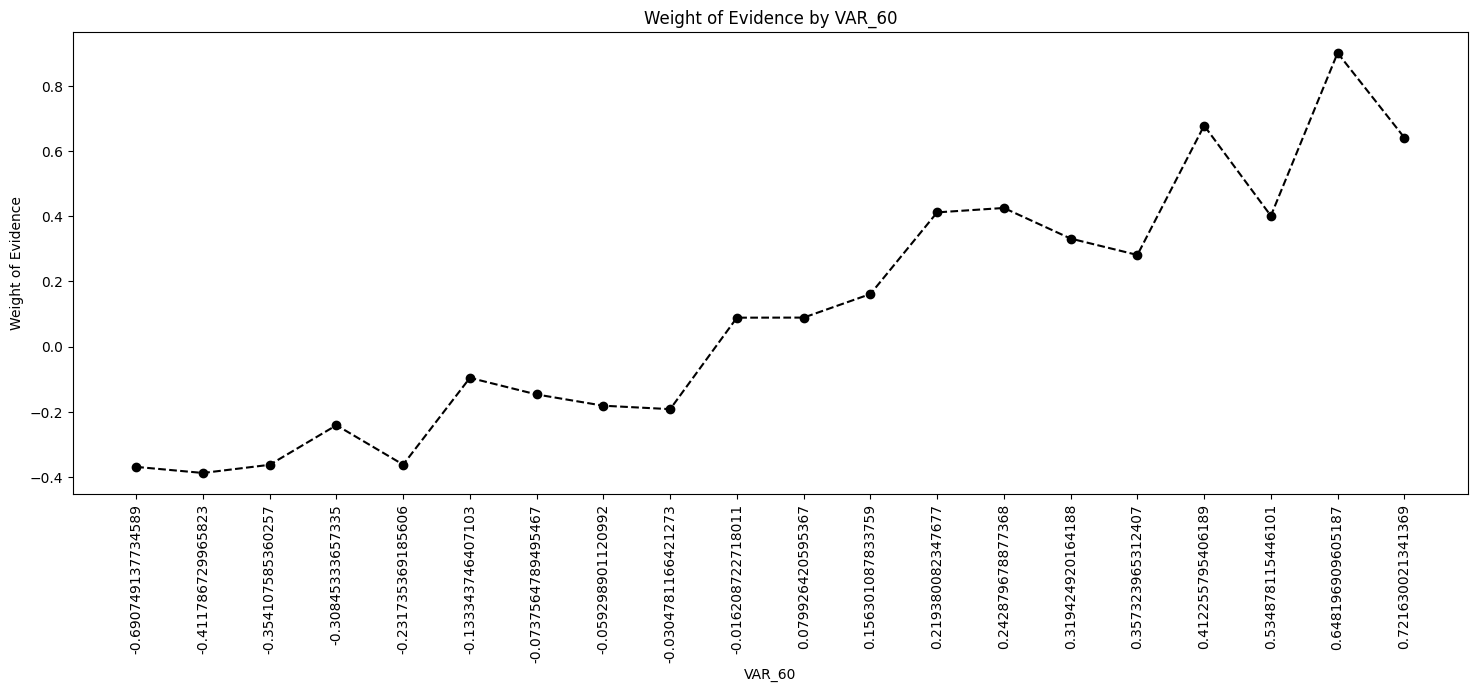

In [48]:
# VAR_60
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_60')
display(WoE)
plot_by_woe(WoE,90)

In [49]:
df['VAR_60']

0       -0.030478
1        0.357324
2       -0.411787
3        0.721630
4       -0.231735
           ...   
10733   -0.411787
10734   -0.133344
10735   -0.030478
10736   -0.411787
10737   -0.411787
Name: VAR_60, Length: 10738, dtype: float64

In [50]:
df_inputs_prepr['VAR_60'].isnull().sum()

0

In [51]:
# VAR_60
df_inputs_prepr['VAR_60:<-.025'] = np.where((df_inputs_prepr['VAR_60']< -0.25), 1, 0)
df_inputs_prepr['VAR_60:-0.25to-0.004'] = np.where((df_inputs_prepr['VAR_60']>=-0.25) & (df_inputs_prepr['VAR_60']<=-0.004), 1, 0)
df_inputs_prepr['VAR_60:>-0.004'] = np.where((df_inputs_prepr['VAR_60']>-0.004), 1, 0)

VAR_64   Bad  Good  Total    %Total      %Bad     %Good  DefaultRate  \
0      0   742  2681   3423  0.398487  0.295735  0.440881     0.216769   
1      1  1767  3400   5167  0.601513  0.704265  0.559119     0.341978   

        WoE  diff_WoE        IV  
0  0.399311       NaN  0.091457  
1 -0.230793  0.630104  0.091457

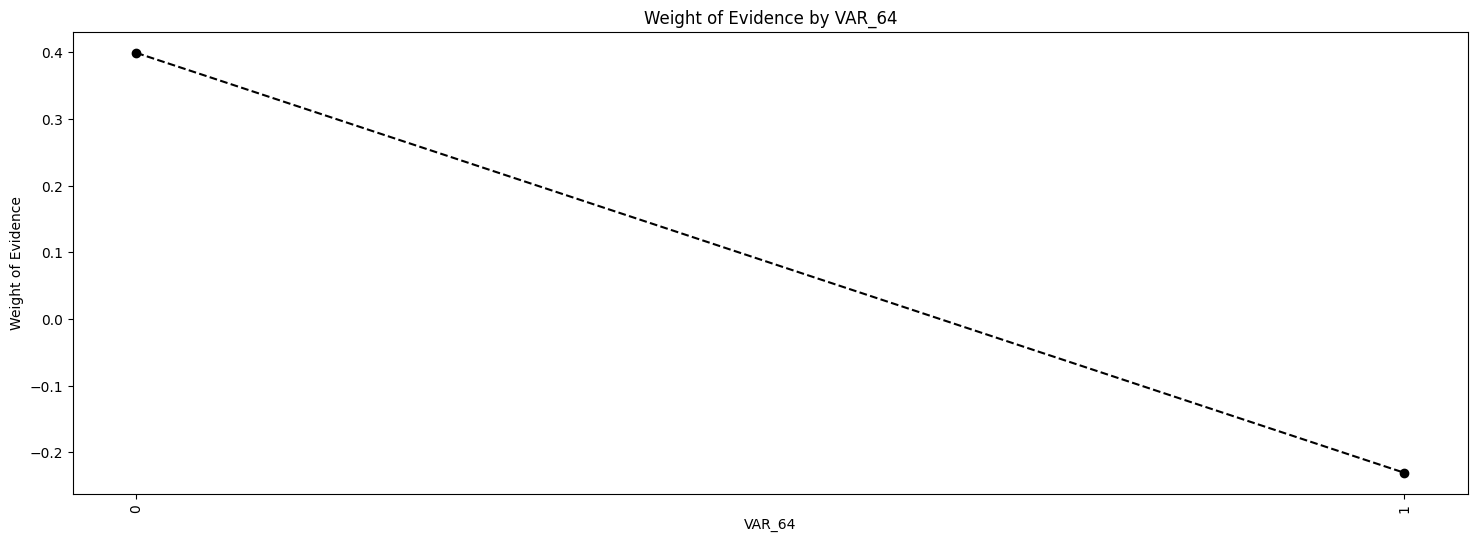

In [52]:
# VAR_64
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'VAR_64')
display(WoE)
plot_by_woe(WoE,90)

In [53]:
# VAR_64
df_inputs_prepr['VAR_64:0'] = np.where((df_inputs_prepr['VAR_64']== 0), 1, 0)
df_inputs_prepr['VAR_64:1'] = np.where((df_inputs_prepr['VAR_64']==1), 1, 0)

months_since_cr_line  Bad  Good  Total    %Total      %Bad     %Good  \
0                  37.0  223   407    630  0.073341  0.088880  0.066930   
1                  38.0  214   417    631  0.073458  0.085293  0.068574   
2                  39.0  217   547    764  0.088941  0.086489  0.089952   
3                  40.0  213   488    701  0.081607  0.084894  0.080250   
4                  41.0  200   514    714  0.083120  0.079713  0.084526   
5                  42.0  212   562    774  0.090105  0.084496  0.092419   
6                  43.0  192   528    720  0.083818  0.076525  0.086828   
7                  44.0  197   587    784  0.091269  0.078517  0.096530   
8                  45.0  198   565    763  0.088824  0.078916  0.092912   
9                  46.0  180   544    724  0.084284  0.071742  0.089459   
10                 47.0  224   490    714  0.083120  0.089279  0.080579   
11                 48.0  239   432    671  0.078114  0.095257  0.071041   

    DefaultRate       WoE  diff_WoE        IV  
0      0.353968 -0.283643       NaN  0.030476  
1      0.339144 -0.218175  0.065469  0.030476  
2      0.284031  0.039267  0.257441  0.030476  
3      0.303852 -0.056262  0.095528  0.030476  
4      0.280112  0.058621  0.114883  0.030476  
5      0.273902  0.089631  0.031010  0.030476  
6      0.266667  0.126316  0.036685  0.030476  
7      0.251276  0.206536  0.080220  0.030476  
8      0.259502  0.163274  0.043262  0.030476  
9      0.248619  0.220708  0.057434  0.030476  
10     0.313725 -0.102526  0.323233  0.030476  
11     0.356185 -0.293323  0.190797  0.030476

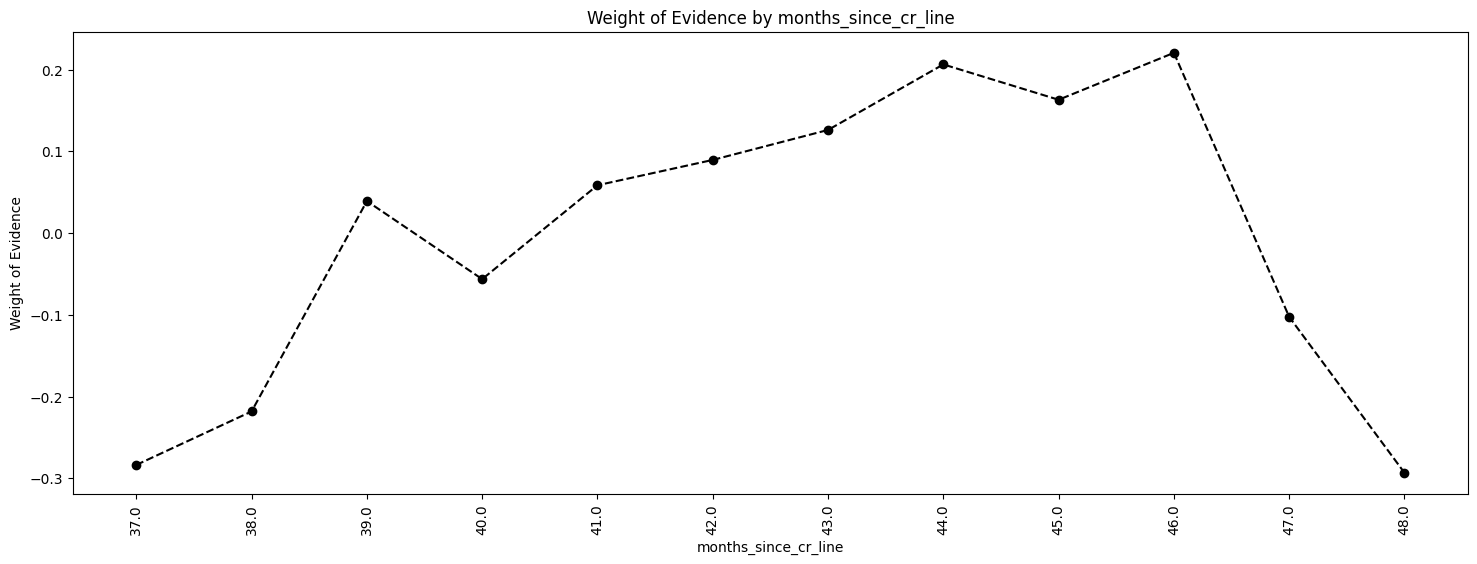

In [54]:
# months_since_cr_line
WoE = WoE_IV_Numeric(df_inputs_prepr,df_targets_prepr, 'months_since_cr_line')
display(WoE)
plot_by_woe(WoE,90)

In [55]:
# months_since_cr_line
df_inputs_prepr['months_since_cr_line:37-38'] = np.where((df_inputs_prepr['months_since_cr_line'].isin(range(37,39))), 1, 0)
df_inputs_prepr['months_since_cr_line:39'] = np.where((df_inputs_prepr['months_since_cr_line']==39), 1, 0)
df_inputs_prepr['months_since_cr_line:40'] = np.where((df_inputs_prepr['months_since_cr_line']==40), 1, 0)
df_inputs_prepr['months_since_cr_line:41-46'] = np.where((df_inputs_prepr['months_since_cr_line'].isin(range(41,47))), 1, 0)
df_inputs_prepr['months_since_cr_line:47-48'] = np.where((df_inputs_prepr['months_since_cr_line'].isin(range(47,49))), 1, 0)

#### 3.2 Features with more than 50 unique values

In [56]:
summary[summary['Unique values'] > 50]['Feature']

0      VAR_1
4      VAR_6
5      VAR_7
6      VAR_8
7      VAR_9
8     VAR_11
9     VAR_15
10    VAR_17
12    VAR_22
14    VAR_30
17    VAR_34
18    VAR_35
19    VAR_38
20    VAR_45
21    VAR_52
22    VAR_53
23    VAR_54
24    VAR_58
25    VAR_59
28    VAR_65
29    VAR_72
30    VAR_76
Name: Feature, dtype: object

/tmp/ipykernel_11844/1707412951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_1_factor'] = pd.cut(df_inputs_prepr_temp['VAR_1'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_1_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0     (-0.208, 4.16]  602  2529   3131  0.379561  0.247329  0.434910   
1       (4.16, 8.32]   76   165    241  0.029216  0.031224  0.028375   
2      (8.32, 12.48]   75   298    373  0.045218  0.030813  0.051247   
3     (12.48, 16.64]  117   411    528  0.064008  0.048069  0.070679   
4      (16.64, 20.8]   88   293    381  0.046187  0.036154  0.050387   
5      (20.8, 24.96]  157   484    641  0.077706  0.064503  0.083233   
6     (24.96, 29.12]   98   271    369  0.044733  0.040263  0.046604   
7     (29.12, 33.28]   17    67     84  0.010183  0.006984  0.011522   
8     (33.28, 37.44]   91   154    245  0.029701  0.037387  0.026483   
9      (37.44, 41.6]   37    78    115  0.013941  0.015201  0.013414   
10     (41.6, 45.76]   19    62     81  0.009819  0.007806  0.010662   
11    (45.76, 49.92]   51   133    184  0.022306  0.020953  0.022872   
12    (49.92, 54.08]   89   164    253  0.030670  0.036565  0.028203   
13    (54.08, 58.24]   39    60     99  0.012001  0.016023  0.010318   
14     (58.24, 62.4]   35    72    107  0.012971  0.014380  0.012382   
15     (62.4, 66.56]   27    55     82  0.009941  0.011093  0.009458   
16    (66.56, 70.72]   28    33     61  0.007395  0.011504  0.005675   
17    (70.72, 74.88]   21    25     46  0.005576  0.008628  0.004299   
18    (74.88, 79.04]   31    49     80  0.009698  0.012736  0.008426   
19     (79.04, 83.2]   45    45     90  0.010910  0.018488  0.007739   
20     (83.2, 87.36]   31    40     71  0.008607  0.012736  0.006879   
21    (87.36, 91.52]   26    18     44  0.005334  0.010682  0.003095   
22    (91.52, 95.68]   21    20     41  0.004970  0.008628  0.003439   
23    (95.68, 99.84]   19    20     39  0.004728  0.007806  0.003439   
24    (99.84, 104.0]   11    18     29  0.003516  0.004519  0.003095   
25   (104.0, 108.16]   28    14     42  0.005092  0.011504  0.002408   
26  (108.16, 112.32]   25    22     47  0.005698  0.010271  0.003783   
27  (112.32, 116.48]    8    14     22  0.002667  0.003287  0.002408   
28  (116.48, 120.64]   20    18     38  0.004607  0.008217  0.003095   
29   (120.64, 124.8]    6    10     16  0.001940  0.002465  0.001720   
30   (124.8, 128.96]   23    11     34  0.004122  0.009449  0.001892   
31  (128.96, 133.12]   10     7     17  0.002061  0.004108  0.001204   
32  (133.12, 137.28]    7    13     20  0.002425  0.002876  0.002236   
33  (137.28, 141.44]   20     7     27  0.003273  0.008217  0.001204   
34   (141.44, 145.6]   20     8     28  0.003394  0.008217  0.001376   
35   (145.6, 149.76]   13     6     19  0.002303  0.005341  0.001032   
36  (149.76, 153.92]   23     7     30  0.003637  0.009449  0.001204   
37  (153.92, 158.08]   47    21     68  0.008243  0.019310  0.003611   
38  (158.08, 162.24]   43    11     54  0.006546  0.017666  0.001892   
39   (162.24, 166.4]   45    18     63  0.007637  0.018488  0.003095   
40   (166.4, 170.56]   64    10     74  0.008971  0.026294  0.001720   
41  (170.56, 174.72]  109    29    138  0.016729  0.044782  0.004987   
42  (174.72, 178.88]   37    10     47  0.005698  0.015201  0.001720   
43  (178.88, 183.04]   26     5     31  0.003758  0.010682  0.000860   
44   (183.04, 187.2]    4     2      6  0.000727  0.001643  0.000344   
45   (187.2, 191.36]    1     2      3  0.000364  0.000411  0.000344   
46  (191.36, 195.52]    0     2      2  0.000242  0.000000  0.000344   
47  (195.52, 199.68]    2     2      4  0.000485  0.000822  0.000344   
48  (199.68, 203.84]    1     0      1  0.000121  0.000411  0.000000   
49   (203.84, 208.0]    1     2      3  0.000364  0.000411  0.000344   

    DefaultRate       WoE  diff_WoE   IV  
0      0.192271  0.564417       NaN  inf  
1      0.315353 -0.095693  0.660110  inf  
2      0.201072  0.508701  0.604393  inf  
3      0.221591  0.385514  0.123186  inf  
4      0.230971  0.331931  0.053583  inf  
5      0.244930  0.254934  0.076997  inf  
6      0.265583  0.146247  0.10868

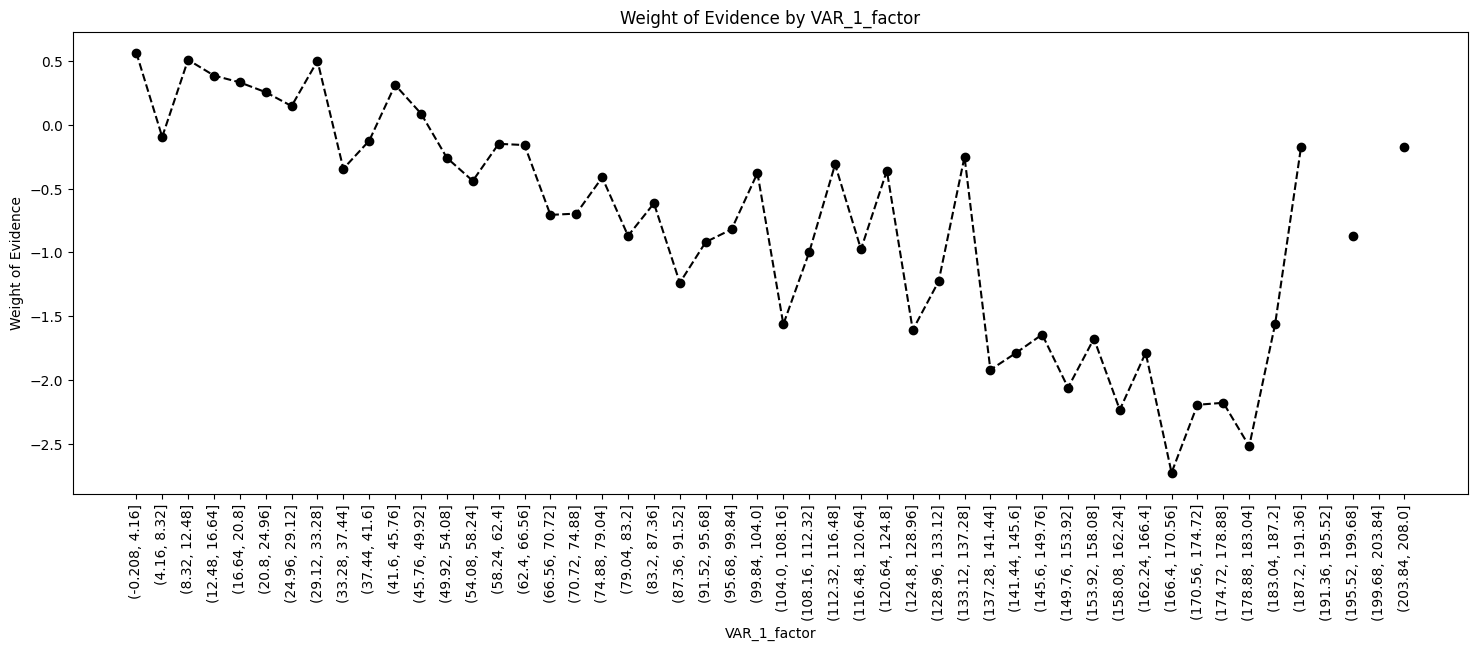

In [57]:
# Fine classing - VAR_1
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_1'])]
df_inputs_prepr_temp[f'VAR_1_factor'] = pd.cut(df_inputs_prepr_temp['VAR_1'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_1_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

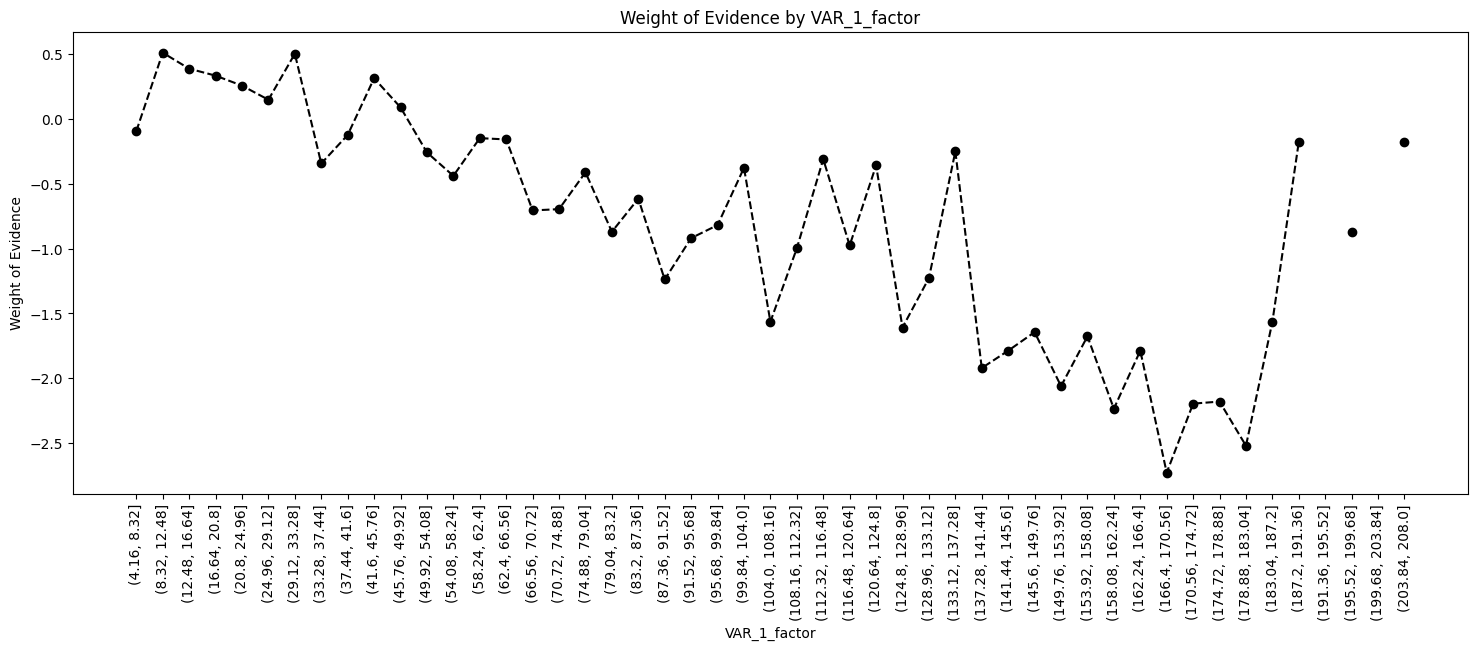

In [58]:
plot_by_woe(WoE_factor.iloc[1:,:],90)

In [59]:
df_inputs_prepr['VAR_1'].isnull().sum()

341

In [60]:
# VAR_1
df_inputs_prepr['VAR_1:<=4.16'] = np.where((df_inputs_prepr['VAR_1']<=4.16), 1, 0)
df_inputs_prepr['VAR_1:4.16-66.56'] = np.where((df_inputs_prepr['VAR_1']>4.16) & (df_inputs_prepr['VAR_1']<=66.56), 1, 0)
df_inputs_prepr['VAR_1:66.56-128.96'] = np.where((df_inputs_prepr['VAR_1']>66.56) & (df_inputs_prepr['VAR_1']<=128.96), 1, 0)
df_inputs_prepr['VAR_1:>128.96_or_missing'] = np.where((df_inputs_prepr['VAR_1']>128.96) | (df_inputs_prepr['VAR_1'].isnull()), 1, 0)

/tmp/ipykernel_11844/3577949158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_6_factor'] = pd.cut(df_inputs_prepr_temp['VAR_6'],50)


VAR_6_factor   Bad  Good  Total    %Total  %Bad     %Good  \
0    (-526.989, 8565.78]  2491  6019   8510  0.999648   1.0  0.999502   
1  (424235.22, 432895.0]     0     3      3  0.000352   0.0  0.000498   

   DefaultRate       WoE  diff_WoE   IV  
0     0.292714 -0.000498       NaN  inf  
1     0.000000       inf       inf  inf

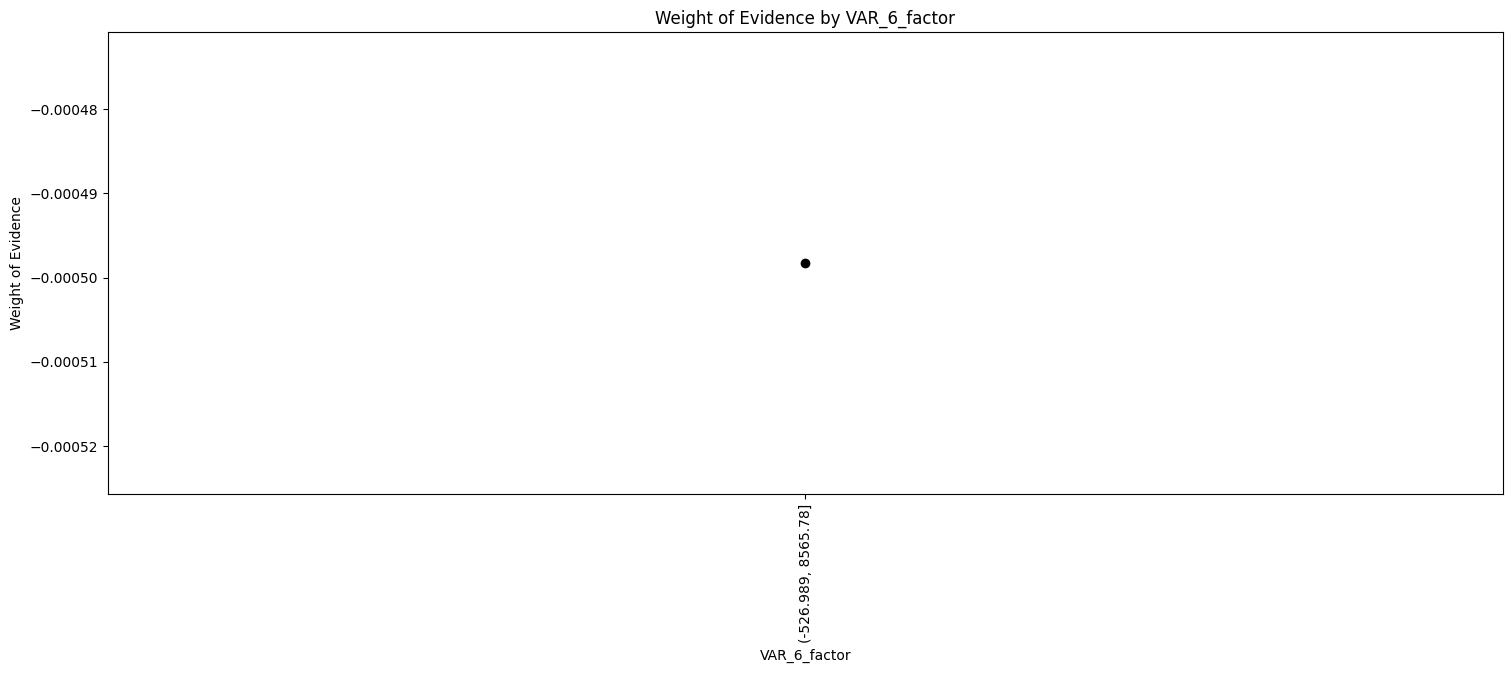

In [61]:
# Fine classing - VAR_6
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_6'])]
df_inputs_prepr_temp[f'VAR_6_factor'] = pd.cut(df_inputs_prepr_temp['VAR_6'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_6_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

VAR_6_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0     (-99.284, 11.68]    2     3      5  0.000588  0.000803  0.000498   
1      (11.68, 117.36]   18    25     43  0.005053  0.007226  0.004154   
2     (117.36, 223.04]  196   266    462  0.054289  0.078683  0.044193   
3     (223.04, 328.72]  354   481    835  0.098120  0.142112  0.079914   
4      (328.72, 434.4]  262   441    703  0.082609  0.105179  0.073268   
5      (434.4, 540.08]  227   404    631  0.074148  0.091128  0.067121   
6     (540.08, 645.76]  196   375    571  0.067098  0.078683  0.062303   
7     (645.76, 751.44]  164   303    467  0.054877  0.065837  0.050341   
8     (751.44, 857.12]  120   292    412  0.048414  0.048173  0.048513   
9      (857.12, 962.8]  113   265    378  0.044418  0.045363  0.044027   
10    (962.8, 1068.48]   86   225    311  0.036545  0.034524  0.037382   
11  (1068.48, 1174.16]   73   213    286  0.033608  0.029305  0.035388   
12  (1174.16, 1279.84]   68   188    256  0.030082  0.027298  0.031234   
13  (1279.84, 1385.52]   49   153    202  0.023737  0.019671  0.025420   
14   (1385.52, 1491.2]   31   113    144  0.016921  0.012445  0.018774   
15   (1491.2, 1596.88]   20   133    153  0.017979  0.008029  0.022097   
16  (1596.88, 1702.56]   30   141    171  0.020094  0.012043  0.023426   
17  (1702.56, 1808.24]   35   114    149  0.017509  0.014051  0.018940   
18  (1808.24, 1913.92]   17    81     98  0.011516  0.006825  0.013457   
19   (1913.92, 2019.6]   22    88    110  0.012926  0.008832  0.014620   
20   (2019.6, 2125.28]   19    97    116  0.013631  0.007627  0.016116   
21  (2125.28, 2230.96]   28    82    110  0.012926  0.011240  0.013624   
22  (2230.96, 2336.64]   18    77     95  0.011163  0.007226  0.012793   
23  (2336.64, 2442.32]   20    79     99  0.011633  0.008029  0.013125   
24   (2442.32, 2548.0]   20   106    126  0.014806  0.008029  0.017611   
25   (2548.0, 2653.68]   28   101    129  0.015159  0.011240  0.016780   
26  (2653.68, 2759.36]   27    98    125  0.014689  0.010839  0.016282   
27  (2759.36, 2865.04]   20    93    113  0.013278  0.008029  0.015451   
28  (2865.04, 2970.72]   19    84    103  0.012103  0.007627  0.013956   
29   (2970.72, 3076.4]   10    88     98  0.011516  0.004014  0.014620   
30   (3076.4, 3182.08]   23    60     83  0.009753  0.009233  0.009968   
31  (3182.08, 3287.76]   15    67     82  0.009636  0.006022  0.011131   
32  (3287.76, 3393.44]   12    66     78  0.009166  0.004817  0.010965   
33  (3393.44, 3499.12]   13    43     56  0.006580  0.005219  0.007144   
34   (3499.12, 3604.8]   16    54     70  0.008226  0.006423  0.008972   
35   (3604.8, 3710.48]   10    50     60  0.007051  0.004014  0.008307   
36  (3710.48, 3816.16]   10    42     52  0.006110  0.004014  0.006978   
37  (3816.16, 3921.84]    4    33     37  0.004348  0.001606  0.005483   
38  (3921.84, 4027.52]    9    44     53  0.006228  0.003613  0.007310   
39   (4027.52, 4133.2]    9    28     37  0.004348  0.003613  0.004652   
40   (4133.2, 4238.88]    7    30     37  0.004348  0.002810  0.004984   
41  (4238.88, 4344.56]    8    31     39  0.004583  0.003212  0.005150   
42  (4344.56, 4450.24]    9    30     39  0.004583  0.003613  0.004984   
43  (4450.24, 4555.92]    9    28     37  0.004348  0.003613  0.004652   
44   (4555.92, 4661.6]    4    35     39  0.004583  0.001606  0.005815   
45   (4661.6, 4767.28]   13    44     57  0.006698  0.005219  0.007310   
46  (4767.28, 4872.96]   13    62     75  0.008813  0.005219  0.010301   
47  (4872.96, 4978.64]    7    38     45  0.005288  0.002810  0.006313   
48  (4978.64, 5084.32]    5    24     29  0.003408  0.002007  0.003987   
49   (5084.32, 5190.0]    3     1      4  0.000470  0.001204  0.000166   

    DefaultRate       WoE  diff_WoE        IV  
0      0.400000 -0.476772       NaN  0.208761  
1      0.418605 -0.553733  0.076961  0.208761  
2      0.424242 -0.576855  0.023122  0.208761  
3      0.423952 -0.575667  0.001189  0.2087

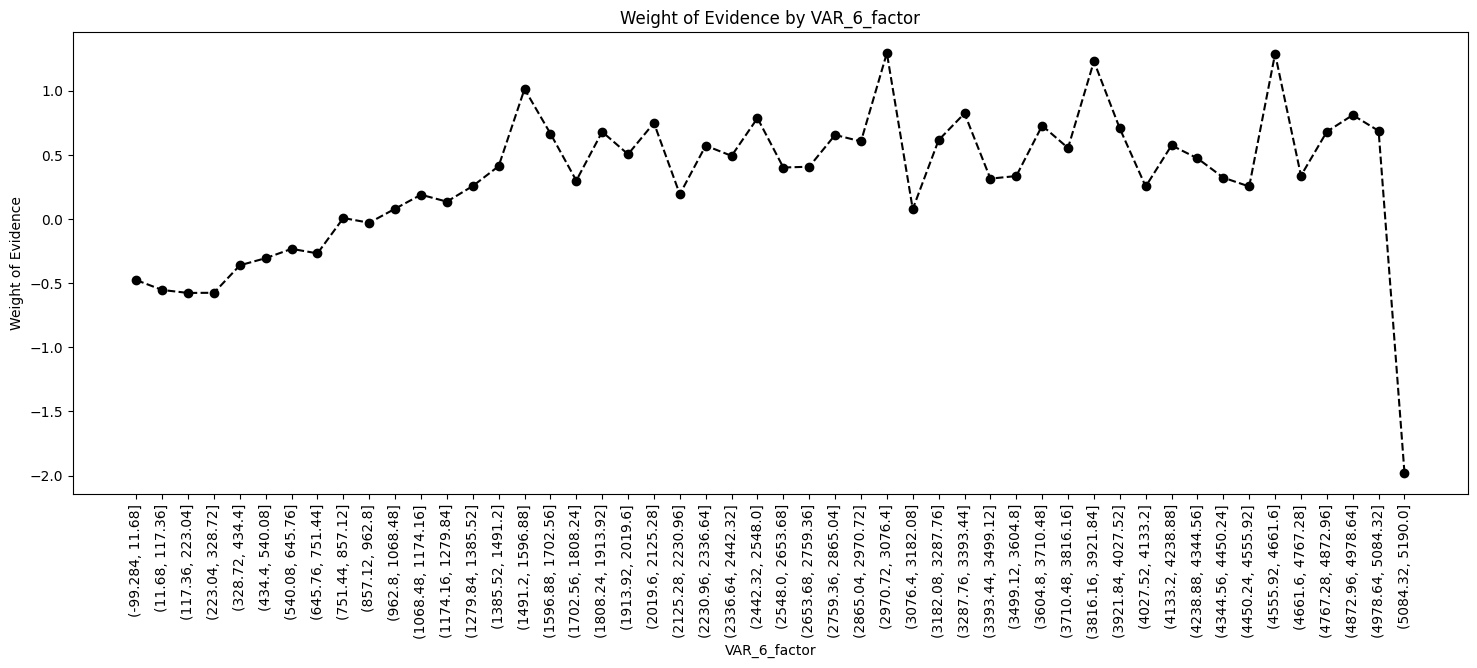

In [62]:
# Fine classing - VAR_6
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_6'])]
df_inputs_prepr_temp = df_inputs_prepr_temp[df_inputs_prepr_temp['VAR_6'] <= 8565.78]
df_inputs_prepr_temp[f'VAR_6_factor'] = pd.cut(df_inputs_prepr_temp['VAR_6'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_6_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [63]:
df_inputs_prepr[df_inputs_prepr['VAR_6'] >  8565.78]

Unnamed: 0    id   safra  y  VAR_1  VAR_2  VAR_3  VAR_4     VAR_6  \
3131        3131  3132  201412  0    NaN    NaN    NaN    NaN  432256.0   
8731        8731  8732  201409  0    0.0    0.0    0.0    0.0  432895.0   
9048        9048  9049  201406  0   26.0    0.0    0.0    0.0  432062.0   

      VAR_7  ...  VAR_64:1  months_since_cr_line:37-38  \
3131    NaN  ...         1                           1   
8731    NaN  ...         0                           0   
9048  39.99  ...         0                           0   

      months_since_cr_line:39  months_since_cr_line:40  \
3131                        0                        0   
8731                        0                        1   
9048                        0                        0   

      months_since_cr_line:41-46  months_since_cr_line:47-48  VAR_1:<=4.16  \
3131                           0                           0             0   
8731                           0                           0             1   
9048                           1                           0             0   

      VAR_1:4.16-66.56  VAR_1:66.56-128.96  VAR_1:>128.96_or_missing  
3131                 0                   0                         1  
8731                 0                   0                         0  
9048                 1                   0                         0  

[3 rows x 68 columns]

In [64]:
df_inputs_prepr['VAR_6'].isnull().sum()

77

In [65]:
# VAR_6
df_inputs_prepr['VAR_6:<=12_or_missing'] = np.where((df_inputs_prepr['VAR_6']<=12) | (df_inputs_prepr['VAR_6'].isnull()), 1, 0)
df_inputs_prepr['VAR_6:12-751.44'] = np.where((df_inputs_prepr['VAR_6']>12) & (df_inputs_prepr['VAR_6']<=751.44), 1, 0)
df_inputs_prepr['VAR_6:751.44-4555.92'] = np.where((df_inputs_prepr['VAR_6']>751.44) & (df_inputs_prepr['VAR_6']<=4555.92), 1, 0)
df_inputs_prepr['VAR_6:>4555.92'] = np.where((df_inputs_prepr['VAR_6']>4555.92), 1, 0)

/tmp/ipykernel_11844/4237567987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_7_factor'] = pd.cut(df_inputs_prepr_temp['VAR_7'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_7_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0      (-1.025, 20.719]  184   438    622  0.127642  0.122097  0.130125   
1      (20.719, 41.428]  353   838   1191  0.244408  0.234240  0.248960   
2      (41.428, 62.138]  323   743   1066  0.218756  0.214333  0.220737   
3      (62.138, 82.847]  235   468    703  0.144264  0.155939  0.139037   
4     (82.847, 103.556]  107   294    401  0.082290  0.071002  0.087344   
5    (103.556, 124.265]  106   184    290  0.059512  0.070338  0.054664   
6    (124.265, 144.974]   64   155    219  0.044942  0.042468  0.046049   
7    (144.974, 165.684]   40    88    128  0.026267  0.026543  0.026144   
8    (165.684, 186.393]   30    40     70  0.014365  0.019907  0.011884   
9    (186.393, 207.102]   17    27     44  0.009029  0.011281  0.008021   
10   (207.102, 227.811]   15    34     49  0.010055  0.009954  0.010101   
11    (227.811, 248.52]    8    19     27  0.005541  0.005309  0.005645   
12     (248.52, 269.23]   11     7     18  0.003694  0.007299  0.002080   
13    (269.23, 289.939]    4     7     11  0.002257  0.002654  0.002080   
14   (289.939, 310.648]    2     4      6  0.001231  0.001327  0.001188   
15   (310.648, 331.357]    3     2      5  0.001026  0.001991  0.000594   
16   (331.357, 352.066]    2     5      7  0.001436  0.001327  0.001485   
17   (352.066, 372.776]    1     3      4  0.000821  0.000664  0.000891   
18   (372.776, 393.485]    0     3      3  0.000616  0.000000  0.000891   
19   (393.485, 414.194]    0     1      1  0.000205  0.000000  0.000297   
20   (414.194, 434.903]    1     0      1  0.000205  0.000664  0.000000   
21   (455.612, 476.322]    1     1      2  0.000410  0.000664  0.000297   
22   (559.158, 579.868]    0     1      1  0.000205  0.000000  0.000297   
23   (579.868, 600.577]    0     2      2  0.000410  0.000000  0.000594   
24     (766.25, 786.96]    0     1      1  0.000205  0.000000  0.000297   
25  (1014.761, 1035.47]    0     1      1  0.000205  0.000000  0.000297   

    DefaultRate       WoE  diff_WoE   IV  
0      0.295820  0.063679       NaN  inf  
1      0.296390  0.060946  0.002733  inf  
2      0.303002  0.029440  0.031506  inf  
3      0.334282 -0.114721  0.144161  inf  
4      0.266833  0.207147  0.321868  inf  
5      0.365517 -0.252108  0.459254  inf  
6      0.292237  0.080938  0.333045  inf  
7      0.312500 -0.015147  0.096085  inf  
8      0.428571 -0.515922  0.500775  inf  
9      0.386364 -0.340981  0.174941  inf  
10     0.306122  0.014706  0.355687  inf  
11     0.296296  0.061393  0.046687  inf  
12     0.611111 -1.255589  1.316983  inf  
13     0.363636 -0.243988  1.011601  inf  
14     0.333333 -0.110457  0.133531  inf  
15     0.600000 -1.209069  1.098612  inf  
16     0.285714  0.112687  1.321756  inf  
17     0.250000  0.295008  0.182322  inf  
18     0.000000       inf       inf  inf  
19     0.000000       inf       NaN  inf  
20     1.000000      -inf       inf  inf  
21     0.500000 -0.803604       inf  inf  
22     0.000000       inf       inf  inf  
23     0.000000       inf       NaN  inf  
24     0.000000       inf       NaN  inf  
25     0.000000       inf       NaN  inf

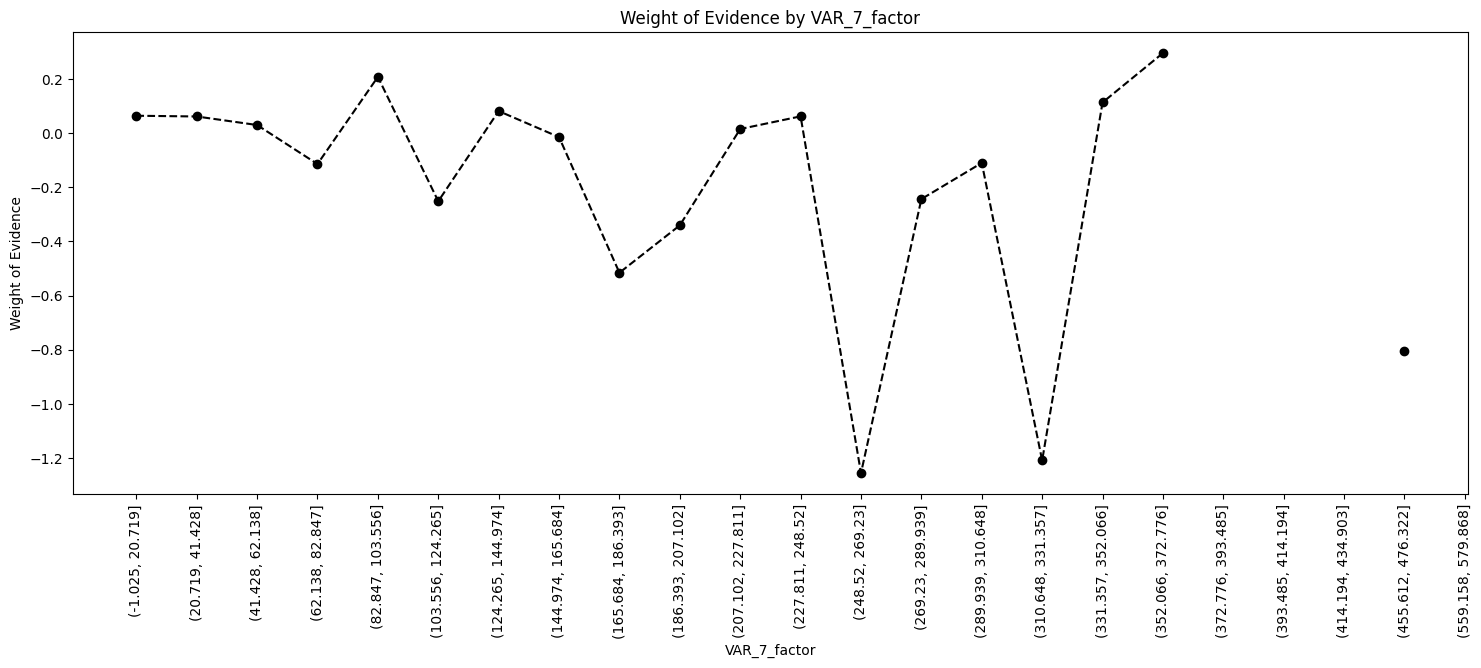

In [66]:
# Fine classing - VAR_7
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_7'])]
df_inputs_prepr_temp[f'VAR_7_factor'] = pd.cut(df_inputs_prepr_temp['VAR_7'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_7_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [67]:
df_inputs_prepr['VAR_7'].isnull().sum()

3717

In [68]:
# VAR_7
df_inputs_prepr['VAR_7:Missing'] = np.where((df_inputs_prepr['VAR_7'].isnull()), 1, 0)
df_inputs_prepr['VAR_7:<=62.138'] = np.where((df_inputs_prepr['VAR_7']<=62.138), 1, 0)
df_inputs_prepr['VAR_7:>62.138'] = np.where((df_inputs_prepr['VAR_7']>62.138), 1, 0)

/tmp/ipykernel_11844/188741334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_8_factor'] = pd.cut(df_inputs_prepr_temp['VAR_8'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_8_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0       (0.11, 18.375]  122   318    440  0.093757  0.083734  0.098269   
1     (18.375, 35.769]  270   672    942  0.200724  0.185312  0.207664   
2     (35.769, 53.164]  255   594    849  0.180908  0.175017  0.183560   
3     (53.164, 70.558]  233   485    718  0.152994  0.159918  0.149876   
4     (70.558, 87.953]  177   334    511  0.108886  0.121482  0.103214   
5    (87.953, 105.348]  112   244    356  0.075858  0.076870  0.075402   
6   (105.348, 122.742]   81   155    236  0.050288  0.055594  0.047899   
7   (122.742, 140.137]   54   126    180  0.038355  0.037062  0.038937   
8   (140.137, 157.531]   42    89    131  0.027914  0.028826  0.027503   
9   (157.531, 174.926]   23    54     77  0.016407  0.015786  0.016687   
10  (174.926, 192.321]   19    51     70  0.014916  0.013040  0.015760   
11  (192.321, 209.715]   16    30     46  0.009802  0.010981  0.009271   
12   (209.715, 227.11]   15    20     35  0.007458  0.010295  0.006180   
13   (227.11, 244.504]    7    10     17  0.003622  0.004804  0.003090   
14  (244.504, 261.899]    2    10     12  0.002557  0.001373  0.003090   
15  (261.899, 279.294]    6    11     17  0.003622  0.004118  0.003399   
16  (279.294, 296.688]    4     5      9  0.001918  0.002745  0.001545   
17  (296.688, 314.083]    3     4      7  0.001492  0.002059  0.001236   
18  (314.083, 331.477]    1     5      6  0.001278  0.000686  0.001545   
19  (331.477, 348.872]    1     1      2  0.000426  0.000686  0.000309   
20  (348.872, 366.267]    2     3      5  0.001065  0.001373  0.000927   
21  (366.267, 383.661]    0     4      4  0.000852  0.000000  0.001236   
22  (383.661, 401.056]    2     1      3  0.000639  0.001373  0.000309   
23   (401.056, 418.45]    4     3      7  0.001492  0.002745  0.000927   
24   (418.45, 435.845]    1     0      1  0.000213  0.000686  0.000000   
25   (435.845, 453.24]    1     2      3  0.000639  0.000686  0.000618   
26   (453.24, 470.634]    1     0      1  0.000213  0.000686  0.000000   
27  (470.634, 488.029]    1     1      2  0.000426  0.000686  0.000309   
28  (522.818, 540.213]    1     0      1  0.000213  0.000686  0.000000   
29  (540.213, 557.607]    0     1      1  0.000213  0.000000  0.000309   
30  (609.791, 627.186]    0     1      1  0.000213  0.000000  0.000309   
31   (627.186, 644.58]    1     0      1  0.000213  0.000686  0.000000   
32  (714.159, 731.553]    0     1      1  0.000213  0.000000  0.000309   
33   (853.315, 870.71]    0     1      1  0.000213  0.000000  0.000309   

    DefaultRate       WoE  diff_WoE   IV  
0      0.277273  0.160072       NaN  inf  
1      0.286624  0.113878  0.046194  inf  
2      0.300353  0.047657  0.066221  inf  
3      0.324513 -0.064848  0.112505  inf  
4      0.346380 -0.162967  0.098119  inf  
5      0.314607 -0.019289  0.143678  inf  
6      0.343220 -0.148983  0.129693  inf  
7      0.300000  0.049339  0.198322  inf  
8      0.320611 -0.046992  0.096331  inf  
9      0.298701  0.055531  0.102523  inf  
10     0.271429  0.189428  0.133897  inf  
11     0.347826 -0.169350  0.358778  inf  
12     0.428571 -0.510276  0.340927  inf  
13     0.411765 -0.441284  0.068993  inf  
14     0.166667  0.811479  1.252763  inf  
15     0.352941 -0.191823  1.003302  inf  
16     0.444444 -0.574815  0.382992  inf  
17     0.428571 -0.510276  0.064539  inf  
18     0.166667  0.811479  1.321756  inf  
19     0.500000 -0.797958  1.609438  inf  
20     0.400000 -0.392493  0.405465  inf  
21     0.000000       inf       inf  inf  
22     0.666667 -1.491106       inf  inf  
23     0.571429 -1.085641  0.405465  inf  
24     1.000000      -inf       inf  inf  
25     0.333333 -0.104811       inf  inf  
26     1.000000      -inf       inf  inf  
27     0.500000 -0.797958       inf  inf  
28     1.000000      -inf       inf  inf  
29     0.000000       inf       inf  inf  
30     0.000000       inf       NaN  inf  
31     1.000000      -inf       inf  inf  


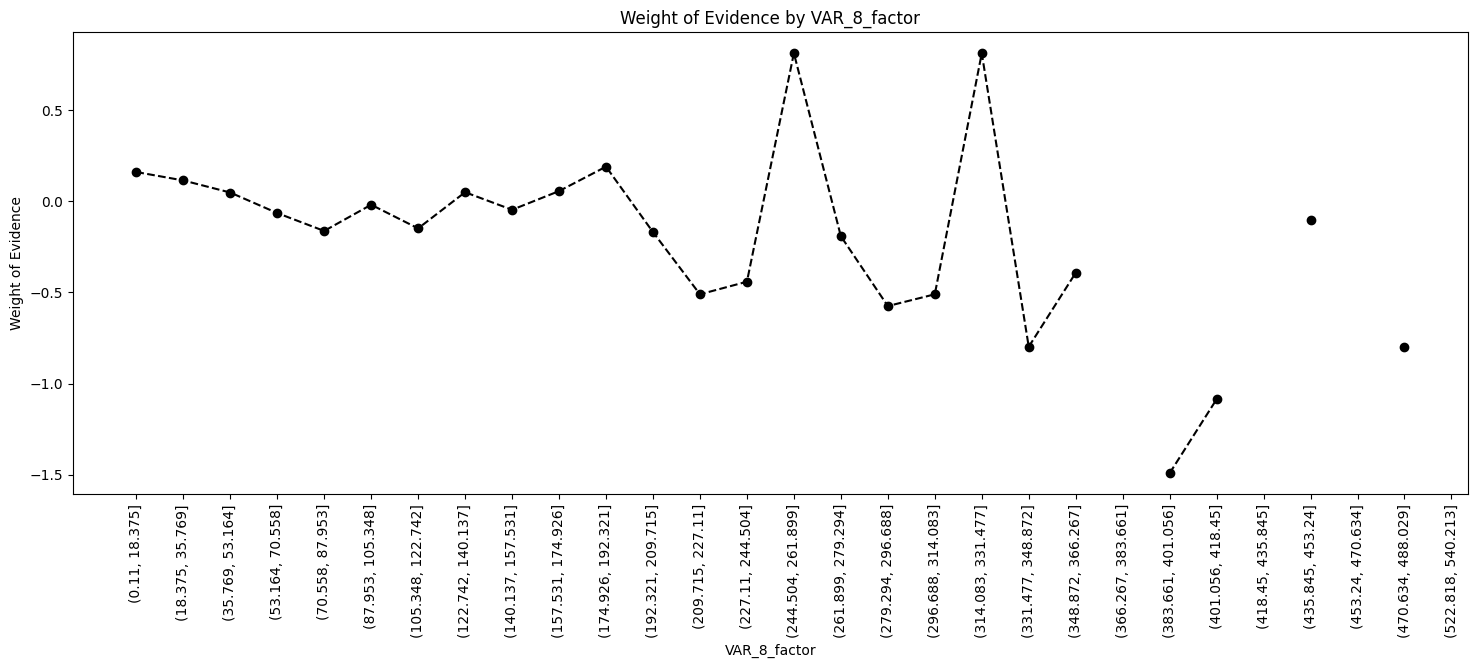

In [69]:
# Fine classing - VAR_8
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_8'])]
df_inputs_prepr_temp[f'VAR_8_factor'] = pd.cut(df_inputs_prepr_temp['VAR_8'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_8_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [70]:
df_inputs_prepr['VAR_8'].isnull().sum()

3897

VAR_9_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0    (147.15, 207.0]   14   168    182  0.021187  0.005580  0.027627   
1     (207.0, 264.0]    8    73     81  0.009430  0.003189  0.012005   
2     (264.0, 321.0]   52   252    304  0.035390  0.020725  0.041441   
3     (321.0, 378.0]   21    56     77  0.008964  0.008370  0.009209   
4     (378.0, 435.0]   42   192    234  0.027241  0.016740  0.031574   
5     (435.0, 492.0]   21    51     72  0.008382  0.008370  0.008387   
6     (492.0, 549.0]  161   598    759  0.088359  0.064169  0.098339   
7     (549.0, 606.0]  108   303    411  0.047846  0.043045  0.049827   
8     (606.0, 663.0]   29    55     84  0.009779  0.011558  0.009045   
9     (663.0, 720.0]   87   234    321  0.037369  0.034675  0.038481   
10    (720.0, 777.0]   31    42     73  0.008498  0.012356  0.006907   
11    (777.0, 834.0]  107   297    404  0.047031  0.042646  0.048841   
12    (834.0, 891.0]   36    66    102  0.011874  0.014348  0.010853   
13    (891.0, 948.0]   70   116    186  0.021653  0.027900  0.019076   
14   (948.0, 1005.0]  524  1340   1864  0.216997  0.208848  0.220358   
15  (1005.0, 1062.0]   21    43     64  0.007451  0.008370  0.007071   
16  (1062.0, 1119.0]   24    63     87  0.010128  0.009566  0.010360   
17  (1119.0, 1176.0]   34    40     74  0.008615  0.013551  0.006578   
18  (1176.0, 1233.0]   85   180    265  0.030850  0.033878  0.029600   
19  (1233.0, 1290.0]   28    41     69  0.008033  0.011160  0.006742   
20  (1290.0, 1347.0]   62   110    172  0.020023  0.024711  0.018089   
21  (1347.0, 1404.0]   40    70    110  0.012806  0.015943  0.011511   
22  (1404.0, 1461.0]   26    36     62  0.007218  0.010363  0.005920   
23  (1461.0, 1518.0]  214   477    691  0.080442  0.085293  0.078441   
24  (1518.0, 1575.0]   14    19     33  0.003842  0.005580  0.003124   
25  (1575.0, 1632.0]   37    46     83  0.009662  0.014747  0.007565   
26  (1632.0, 1689.0]   16    23     39  0.004540  0.006377  0.003782   
27  (1689.0, 1746.0]   23    47     70  0.008149  0.009167  0.007729   
28  (1746.0, 1803.0]   21    68     89  0.010361  0.008370  0.011182   
29  (1803.0, 1860.0]   14    18     32  0.003725  0.005580  0.002960   
30  (1860.0, 1917.0]   26    30     56  0.006519  0.010363  0.004933   
31  (1917.0, 1974.0]   19    19     38  0.004424  0.007573  0.003124   
32  (1974.0, 2031.0]  223   420    643  0.074854  0.088880  0.069068   
33  (2031.0, 2088.0]    7    21     28  0.003260  0.002790  0.003453   
34  (2088.0, 2145.0]   12    12     24  0.002794  0.004783  0.001973   
35  (2145.0, 2202.0]   11    23     34  0.003958  0.004384  0.003782   
36  (2202.0, 2259.0]   13    13     26  0.003027  0.005181  0.002138   
37  (2259.0, 2316.0]   20    26     46  0.005355  0.007971  0.004276   
38  (2316.0, 2373.0]    4    13     17  0.001979  0.001594  0.002138   
39  (2373.0, 2430.0]   10    18     28  0.003260  0.003986  0.002960   
40  (2430.0, 2487.0]   13    24     37  0.004307  0.005181  0.003947   
41  (2487.0, 2544.0]   44    69    113  0.013155  0.017537  0.011347   
42  (2544.0, 2601.0]   12     9     21  0.002445  0.004783  0.001480   
43  (2601.0, 2658.0]   11    19     30  0.003492  0.004384  0.003124   
44  (2658.0, 2715.0]   10     8     18  0.002095  0.003986  0.001316   
45  (2715.0, 2772.0]    6    11     17  0.001979  0.002391  0.001809   
46  (2772.0, 2829.0]    3     8     11  0.001281  0.001196  0.001316   
47  (2829.0, 2886.0]    9     6     15  0.001746  0.003587  0.000987   
48  (2886.0, 2943.0]   12    29     41  0.004773  0.004783  0.004769   
49  (2943.0, 3000.0]   74   179    253  0.029453  0.029494  0.029436   

    DefaultRate       WoE  diff_WoE        IV  
0      0.076923  1.599622       NaN  0.156306  
1      0.098765  1.325733  0.273889  0.156306  
2      0.171053  0.692900  0.632833  0.156306  
3      0.272727  0.095544  0.597356  0.156306  
4      0.179487  0.634541  0.538997  0.156306  
5      0.291667  0.002018  0.632523  0.156306  

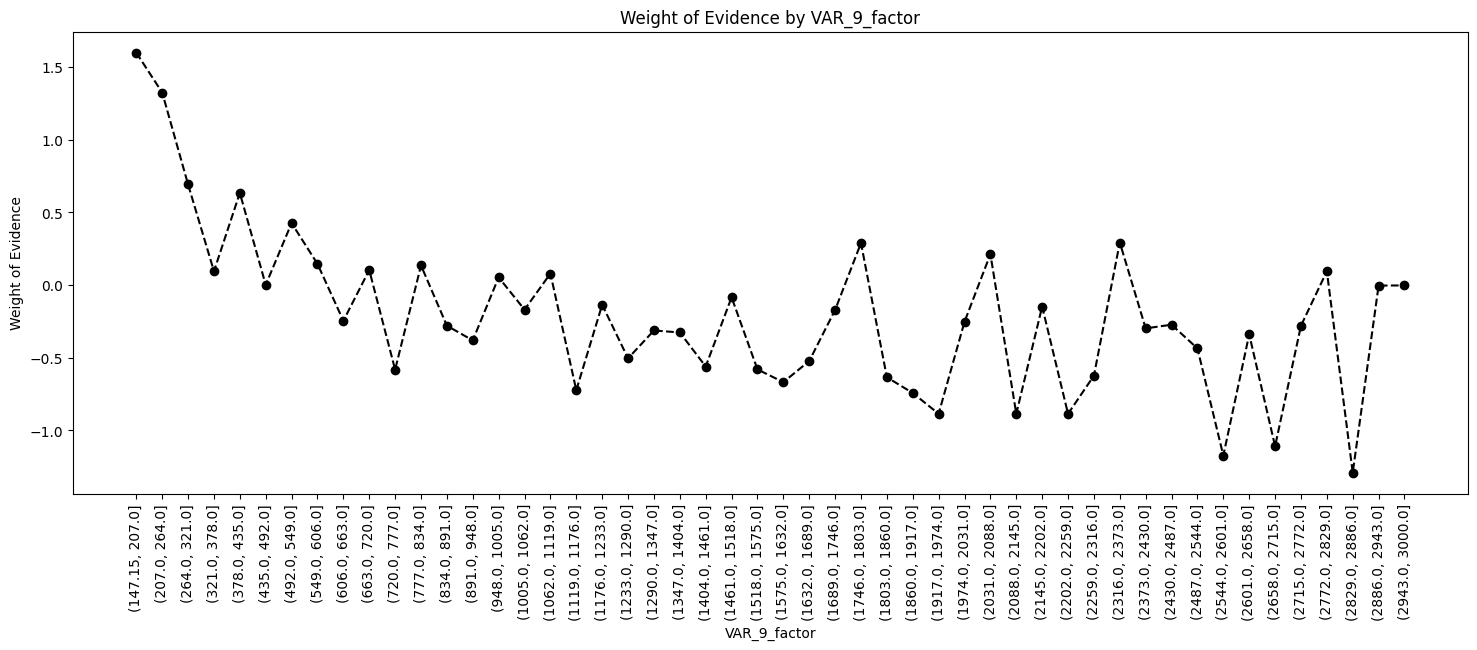

In [71]:
# Fine classing - VAR_9
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_9'])]
df_inputs_prepr_temp[f'VAR_9_factor'] = pd.cut(df_inputs_prepr_temp['VAR_9'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_9_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [72]:
df_inputs_prepr['VAR_9'].isnull().sum()

0

In [73]:
# VAR_9
df_inputs_prepr['VAR_9:<=606.0'] = np.where((df_inputs_prepr['VAR_9']<=606.0), 1, 0)
df_inputs_prepr['VAR_9:>606.0'] = np.where((df_inputs_prepr['VAR_9']>606.0), 1, 0)

/tmp/ipykernel_11844/3653224914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_11_factor'] = pd.cut(df_inputs_prepr_temp['VAR_11'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_11_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0      (-0.686, 21.917]  173   448    621  0.136244  0.129297  0.139130   
1      (21.917, 43.444]  346   870   1216  0.266784  0.258595  0.270186   
2       (43.444, 64.97]  286   630    916  0.200965  0.213752  0.195652   
3       (64.97, 86.497]  185   434    619  0.135805  0.138266  0.134783   
4     (86.497, 108.024]  107   284    391  0.085783  0.079970  0.088199   
5    (108.024, 129.551]   91   200    291  0.063844  0.068012  0.062112   
6    (129.551, 151.078]   40    98    138  0.030276  0.029895  0.030435   
7    (151.078, 172.604]   34    79    113  0.024792  0.025411  0.024534   
8    (172.604, 194.131]   27    54     81  0.017771  0.020179  0.016770   
9    (194.131, 215.658]   10    37     47  0.010312  0.007474  0.011491   
10   (215.658, 237.185]   11    30     41  0.008995  0.008221  0.009317   
11   (237.185, 258.712]    4    18     22  0.004827  0.002990  0.005590   
12   (258.712, 280.238]    6    12     18  0.003949  0.004484  0.003727   
13   (280.238, 301.765]    2     6      8  0.001755  0.001495  0.001863   
14   (301.765, 323.292]    1     4      5  0.001097  0.000747  0.001242   
15   (323.292, 344.819]    6     8     14  0.003072  0.004484  0.002484   
16   (344.819, 366.346]    3     3      6  0.001316  0.002242  0.000932   
17   (366.346, 387.872]    1     0      1  0.000219  0.000747  0.000000   
18   (387.872, 409.399]    1     0      1  0.000219  0.000747  0.000000   
19   (409.399, 430.926]    1     0      1  0.000219  0.000747  0.000000   
20   (430.926, 452.453]    0     1      1  0.000219  0.000000  0.000311   
21    (517.033, 538.56]    1     1      2  0.000439  0.000747  0.000311   
22    (538.56, 560.087]    0     1      1  0.000219  0.000000  0.000311   
23    (581.614, 603.14]    0     1      1  0.000219  0.000000  0.000311   
24   (646.194, 667.721]    2     0      2  0.000439  0.001495  0.000000   
25  (1055.203, 1076.73]    0     1      1  0.000219  0.000000  0.000311   

    DefaultRate       WoE  diff_WoE   IV  
0      0.278583  0.073296       NaN  inf  
1      0.284539  0.043849  0.029447  inf  
2      0.312227 -0.088477  0.132326  inf  
3      0.298869 -0.025517  0.062961  inf  
4      0.273657  0.097940  0.123457  inf  
5      0.312715 -0.090748  0.188688  inf  
6      0.289855  0.017883  0.108630  inf  
7      0.300885 -0.035118  0.053001  inf  
8      0.333333 -0.185058  0.149940  inf  
9      0.212766  0.430127  0.615186  inf  
10     0.268293  0.125097  0.305031  inf  
11     0.181818  0.625872  0.500775  inf  
12     0.333333 -0.185058  0.810930  inf  
13     0.250000  0.220407  0.405465  inf  
14     0.200000  0.508089  0.287682  inf  
15     0.428571 -0.590523  1.098612  inf  
16     0.500000 -0.878205  0.287682  inf  
17     1.000000      -inf       inf  inf  
18     1.000000      -inf       NaN  inf  
19     1.000000      -inf       NaN  inf  
20     0.000000       inf       inf  inf  
21     0.500000 -0.878205       inf  inf  
22     0.000000       inf       inf  inf  
23     0.000000       inf       NaN  inf  
24     1.000000      -inf       inf  inf  
25     0.000000       inf       inf  inf

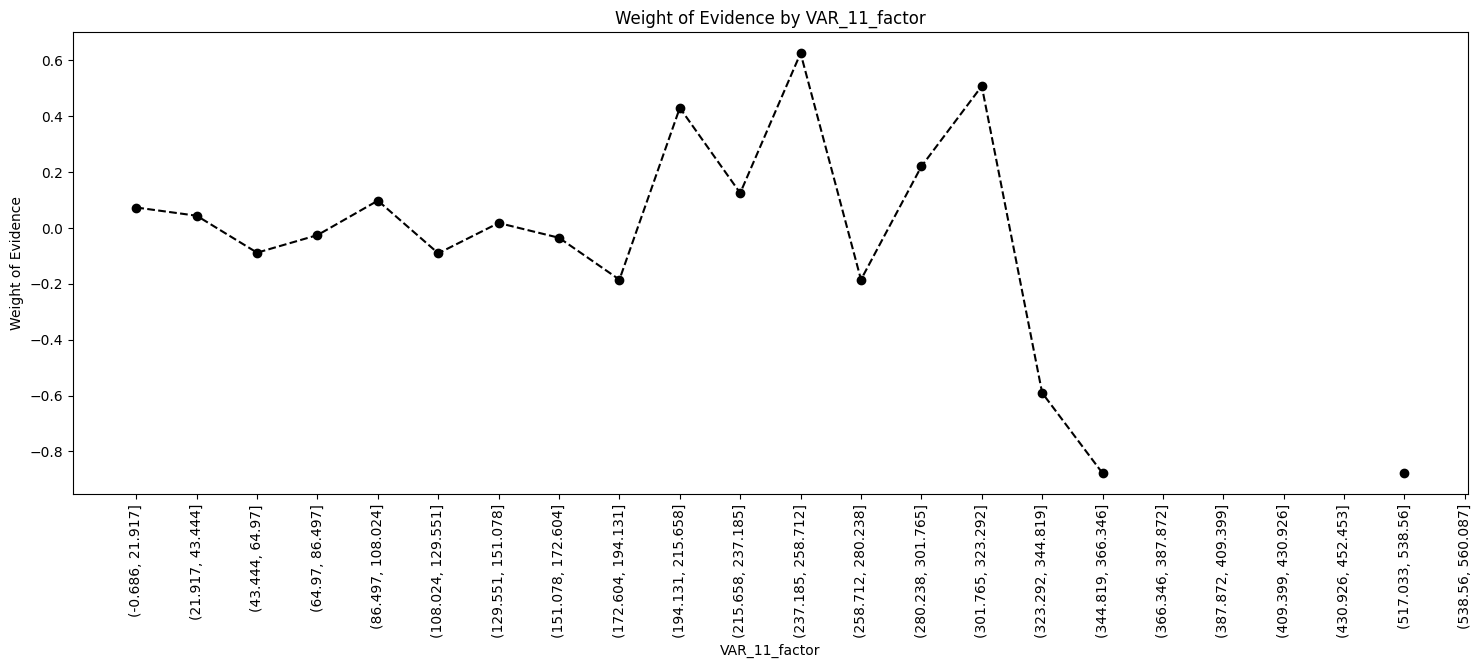

In [74]:
# Fine classing - VAR_11
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_11'])]
df_inputs_prepr_temp[f'VAR_11_factor'] = pd.cut(df_inputs_prepr_temp['VAR_11'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_11_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [75]:
df_inputs_prepr['VAR_11'].isnull().sum()

4032

In [76]:
# VAR_11
df_inputs_prepr['VAR_11:Missing'] = np.where((df_inputs_prepr['VAR_11'].isnull()), 1, 0)
df_inputs_prepr['VAR_11:<=108.024'] = np.where((df_inputs_prepr['VAR_11']<=108.024), 1, 0)
df_inputs_prepr['VAR_11:>108.024'] = np.where((df_inputs_prepr['VAR_11']>108.024), 1, 0)

/tmp/ipykernel_11844/635661139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_15_factor'] = pd.cut(df_inputs_prepr_temp['VAR_15'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_15_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0     (-0.187, 14.246]   70   165    235  0.052037  0.053272  0.051530   
1     (14.246, 27.992]  198   567    765  0.169398  0.150685  0.177077   
2     (27.992, 41.737]  220   557    777  0.172055  0.167428  0.173954   
3     (41.737, 55.483]  210   498    708  0.156776  0.159817  0.155528   
4     (55.483, 69.229]  155   313    468  0.103632  0.117960  0.097751   
5     (69.229, 82.975]  121   246    367  0.081267  0.092085  0.076827   
6     (82.975, 96.721]   86   216    302  0.066873  0.065449  0.067458   
7    (96.721, 110.466]   60   131    191  0.042294  0.045662  0.040912   
8   (110.466, 124.212]   45   116    161  0.035651  0.034247  0.036227   
9   (124.212, 137.958]   42    86    128  0.028344  0.031963  0.026858   
10  (137.958, 151.704]   25    65     90  0.019929  0.019026  0.020300   
11   (151.704, 165.45]   19    57     76  0.016829  0.014460  0.017801   
12   (165.45, 179.195]   12    33     45  0.009965  0.009132  0.010306   
13  (179.195, 192.941]   15    37     52  0.011515  0.011416  0.011555   
14  (192.941, 206.687]    7    27     34  0.007529  0.005327  0.008432   
15  (206.687, 220.433]    6    17     23  0.005093  0.004566  0.005309   
16  (220.433, 234.179]    6    11     17  0.003764  0.004566  0.003435   
17  (234.179, 247.924]    2    10     12  0.002657  0.001522  0.003123   
18   (247.924, 261.67]    4    10     14  0.003100  0.003044  0.003123   
19   (261.67, 275.416]    1     7      8  0.001771  0.000761  0.002186   
20  (275.416, 289.162]    2     3      5  0.001107  0.001522  0.000937   
21  (289.162, 302.908]    0     6      6  0.001329  0.000000  0.001874   
22  (302.908, 316.653]    1     5      6  0.001329  0.000761  0.001562   
23  (316.653, 330.399]    1     5      6  0.001329  0.000761  0.001562   
24  (330.399, 344.145]    2     0      2  0.000443  0.001522  0.000000   
25  (344.145, 357.891]    1     0      1  0.000221  0.000761  0.000000   
26  (357.891, 371.637]    0     1      1  0.000221  0.000000  0.000312   
27  (371.637, 385.382]    0     2      2  0.000443  0.000000  0.000625   
28  (385.382, 399.128]    1     0      1  0.000221  0.000761  0.000000   
29  (399.128, 412.874]    1     4      5  0.001107  0.000761  0.001249   
30   (426.62, 440.366]    0     1      1  0.000221  0.000000  0.000312   
31  (440.366, 454.111]    1     0      1  0.000221  0.000761  0.000000   
32  (454.111, 467.857]    0     2      2  0.000443  0.000000  0.000625   
33  (467.857, 481.603]    0     1      1  0.000221  0.000000  0.000312   
34  (495.349, 509.095]    0     1      1  0.000221  0.000000  0.000312   
35  (564.078, 577.824]    0     1      1  0.000221  0.000000  0.000312   
36   (674.044, 687.79]    0     1      1  0.000221  0.000000  0.000312   

    DefaultRate       WoE  diff_WoE   IV  
0      0.297872 -0.033249       NaN  inf  
1      0.258824  0.161393  0.194642  inf  
2      0.283140  0.038238  0.123155  inf  
3      0.296610 -0.027207  0.065445  inf  
4      0.331197 -0.187922  0.160714  inf  
5      0.329700 -0.181159  0.006763  inf  
6      0.284768  0.030231  0.211390  inf  
7      0.314136 -0.109847  0.140078  inf  
8      0.279503  0.056228  0.166075  inf  
9      0.328125 -0.174022  0.230250  inf  
10     0.277778  0.064812  0.238834  inf  
11     0.250000  0.207913  0.143101  inf  
12     0.266667  0.120901  0.087011  inf  
13     0.288462  0.012168  0.108733  inf  
14     0.205882  0.459227  0.447059  inf  
15     0.260870  0.150754  0.308473  inf  
16     0.352941 -0.284564  0.435318  inf  
17     0.166667  0.718738  1.003302  inf  
18     0.285714  0.025591  0.693147  inf  
19     0.125000  1.055210  1.029619  inf  
20     0.400000 -0.485235  1.540445  inf  
21     0.000000       inf       inf  inf  
22     0.166667  0.718738       inf  inf  
23     0.166667  0.718738  0.000000  inf  
24     1.000000      -inf       inf  inf  
25     1.000000      -inf       NaN  inf  
26     0.000000       inf       inf

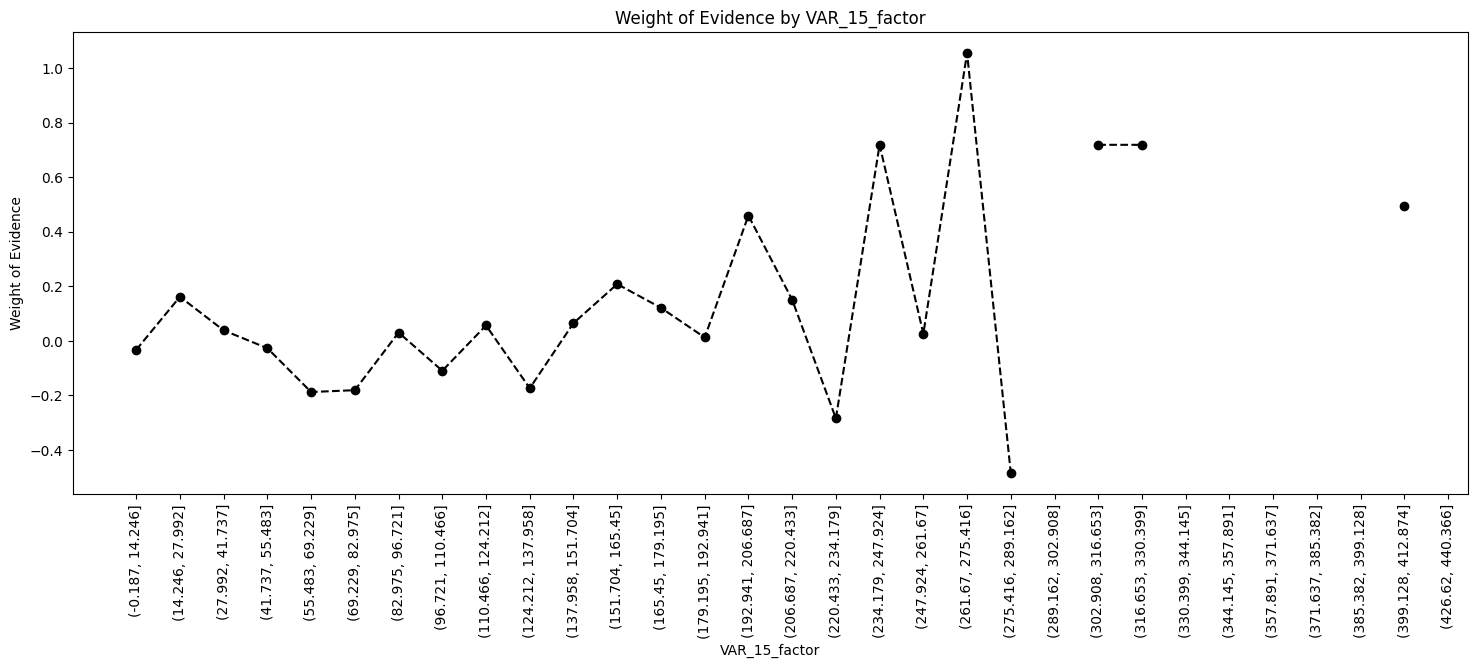

In [77]:
# Fine classing - VAR_15
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_15'])]
df_inputs_prepr_temp[f'VAR_15_factor'] = pd.cut(df_inputs_prepr_temp['VAR_15'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_15_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [78]:
df_inputs_prepr['VAR_15'].isnull().sum()

4074

/tmp/ipykernel_11844/2010410734.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_17_factor'] = pd.cut(df_inputs_prepr_temp['VAR_17'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_17_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0         (-3.038, 732.34]  229   500    729  0.145538  0.185425  0.132485   
1       (732.34, 1432.701]  360   918   1278  0.255141  0.291498  0.243243   
2     (1432.701, 2133.061]  256   853   1109  0.221401  0.207287  0.226020   
3     (2133.061, 2833.422]  115   361    476  0.095029  0.093117  0.095654   
4     (2833.422, 3533.782]  103   357    460  0.091835  0.083401  0.094595   
5     (3533.782, 4234.142]   61   219    280  0.055899  0.049393  0.058029   
6     (4234.142, 4934.503]   38   126    164  0.032741  0.030769  0.033386   
7     (4934.503, 5634.863]   19   135    154  0.030745  0.015385  0.035771   
8     (5634.863, 6335.224]   19    74     93  0.018567  0.015385  0.019608   
9     (6335.224, 7035.584]    6    65     71  0.014174  0.004858  0.017223   
10    (7035.584, 7735.944]    9    33     42  0.008385  0.007287  0.008744   
11    (7735.944, 8436.305]    3    31     34  0.006788  0.002429  0.008214   
12    (8436.305, 9136.665]    4    25     29  0.005790  0.003239  0.006624   
13    (9136.665, 9837.026]    0    14     14  0.002795  0.000000  0.003710   
14   (9837.026, 10537.386]    3    12     15  0.002995  0.002429  0.003180   
15  (10537.386, 11237.746]    2    12     14  0.002795  0.001619  0.003180   
16  (11237.746, 11938.107]    1     0      1  0.000200  0.000810  0.000000   
17  (11938.107, 12638.467]    3     9     12  0.002396  0.002429  0.002385   
18  (12638.467, 13338.828]    1     4      5  0.000998  0.000810  0.001060   
19  (13338.828, 14039.188]    2     8     10  0.001996  0.001619  0.002120   
20  (14039.188, 14739.548]    0     2      2  0.000399  0.000000  0.000530   
21  (14739.548, 15439.909]    0     3      3  0.000599  0.000000  0.000795   
22  (15439.909, 16140.269]    1     1      2  0.000399  0.000810  0.000265   
23   (16140.269, 16840.63]    0     4      4  0.000799  0.000000  0.001060   
24    (17540.99, 18241.35]    0     3      3  0.000599  0.000000  0.000795   
25   (18241.35, 18941.711]    0     1      1  0.000200  0.000000  0.000265   
26  (18941.711, 19642.071]    0     1      1  0.000200  0.000000  0.000265   
27  (21042.792, 21743.152]    0     1      1  0.000200  0.000000  0.000265   
28  (29447.117, 30147.477]    0     1      1  0.000200  0.000000  0.000265   
29     (34349.64, 35050.0]    0     1      1  0.000200  0.000000  0.000265   

    DefaultRate       WoE  diff_WoE   IV  
0      0.314129 -0.336178       NaN  inf  
1      0.281690 -0.180971  0.155207  inf  
2      0.230839  0.086518  0.267489  inf  
3      0.241597  0.026881  0.059636  inf  
4      0.223913  0.125942  0.099061  inf  
5      0.217857  0.161133  0.035191  inf  
6      0.231707  0.081631  0.079502  inf  
7      0.123377  0.843771  0.762140  inf  
8      0.204301  0.242562  0.601210  inf  
9      0.084507  1.265563  1.023002  inf  
10     0.214286  0.182219  1.083345  inf  
11     0.088235  1.218310  1.036092  inf  
12     0.137931  0.715517  0.502793  inf  
13     0.000000       inf       inf  inf  
14     0.200000  0.269230       inf  inf  
15     0.142857  0.674695  0.405465  inf  
16     1.000000      -inf       inf  inf  
17     0.250000 -0.018452       inf  inf  
18     0.200000  0.269230  0.287682  inf  
19     0.200000  0.269230  0.000000  inf  
20     0.000000       inf       inf  inf  
21     0.000000       inf       NaN  inf  
22     0.500000 -1.117064       inf  inf  
23     0.000000       inf       inf  inf  
24     0.000000       inf       NaN  inf  
25     0.000000       inf       NaN  inf  
26     0.000000       inf       NaN  inf  
27     0.000000       inf       NaN  inf  
28     0.000000       inf       NaN  inf  
29     0.000000       inf       NaN  inf

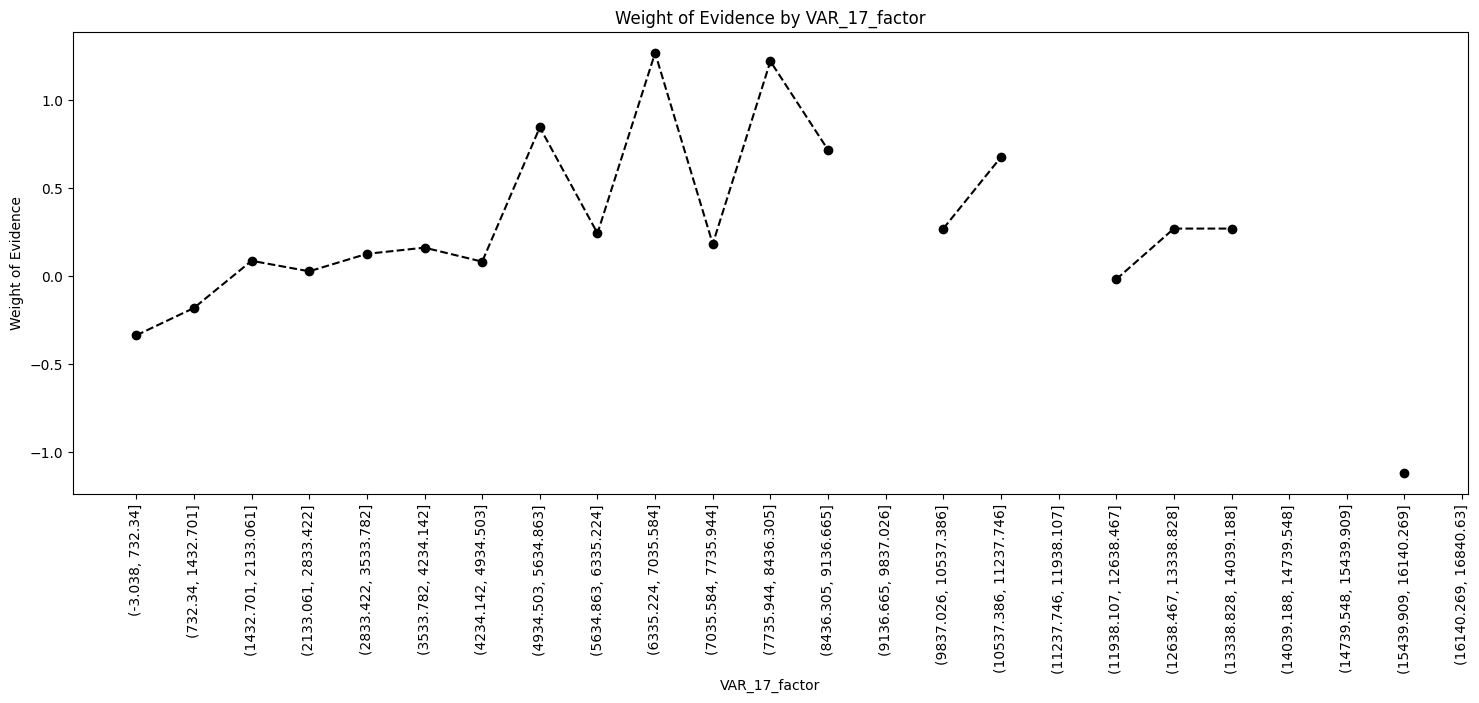

In [79]:
# Fine classing - VAR_17
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_17'])]
df_inputs_prepr_temp[f'VAR_17_factor'] = pd.cut(df_inputs_prepr_temp['VAR_17'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_17_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [80]:
df_inputs_prepr['VAR_17'].isnull().sum()

3581

In [81]:
# VAR_17
df_inputs_prepr['VAR_17:Missing'] = np.where((df_inputs_prepr['VAR_17'].isnull()), 1, 0)
df_inputs_prepr['VAR_17:<=2833.422'] = np.where((df_inputs_prepr['VAR_17']<=2833.422), 1, 0)
df_inputs_prepr['VAR_17:>2833.422'] = np.where((df_inputs_prepr['VAR_17']>2833.422), 1, 0)

/tmp/ipykernel_11844/3449228002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_22_factor'] = pd.cut(df_inputs_prepr_temp['VAR_22'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_22_factor   Bad  Good  Total    %Total      %Bad     %Good  \
0     (-0.122, 2.44]  1968  3824   5792  0.678458  0.788462  0.633008   
1       (2.44, 4.88]    19    97    116  0.013588  0.007612  0.016057   
2       (4.88, 7.32]    38   192    230  0.026942  0.015224  0.031783   
3       (7.32, 9.76]    44   109    153  0.017922  0.017628  0.018043   
4       (9.76, 12.2]    35   144    179  0.020968  0.014022  0.023837   
5      (12.2, 14.64]    22    97    119  0.013939  0.008814  0.016057   
6     (14.64, 17.08]    40   118    158  0.018508  0.016026  0.019533   
7     (17.08, 19.52]    18    86    104  0.012182  0.007212  0.014236   
8     (19.52, 21.96]    21    85    106  0.012417  0.008413  0.014071   
9      (21.96, 24.4]    41   105    146  0.017102  0.016426  0.017381   
10     (24.4, 26.84]    17    84    101  0.011831  0.006811  0.013905   
11    (26.84, 29.28]    17    92    109  0.012768  0.006811  0.015229   
12    (29.28, 31.72]    11    60     71  0.008317  0.004407  0.009932   
13    (31.72, 34.16]    32    78    110  0.012885  0.012821  0.012912   
14     (34.16, 36.6]    17    54     71  0.008317  0.006811  0.008939   
15     (36.6, 39.04]    19    90    109  0.012768  0.007612  0.014898   
16    (39.04, 41.48]     8    57     65  0.007614  0.003205  0.009436   
17    (41.48, 43.92]    10    51     61  0.007145  0.004006  0.008442   
18    (43.92, 46.36]    14    51     65  0.007614  0.005609  0.008442   
19     (46.36, 48.8]     7    50     57  0.006677  0.002804  0.008277   
20     (48.8, 51.24]     8    63     71  0.008317  0.003205  0.010429   
21    (51.24, 53.68]     5    42     47  0.005505  0.002003  0.006952   
22    (53.68, 56.12]    11    39     50  0.005857  0.004407  0.006456   
23    (56.12, 58.56]     9    29     38  0.004451  0.003606  0.004801   
24     (58.56, 61.0]    12    40     52  0.006091  0.004808  0.006621   
25     (61.0, 63.44]     4    30     34  0.003983  0.001603  0.004966   
26    (63.44, 65.88]     2    26     28  0.003280  0.000801  0.004304   
27    (65.88, 68.32]     8    34     42  0.004920  0.003205  0.005628   
28    (68.32, 70.76]     2    18     20  0.002343  0.000801  0.002980   
29     (70.76, 73.2]     6    34     40  0.004685  0.002404  0.005628   
30     (73.2, 75.64]     2    18     20  0.002343  0.000801  0.002980   
31    (75.64, 78.08]     1    15     16  0.001874  0.000401  0.002483   
32    (78.08, 80.52]     3    10     13  0.001523  0.001202  0.001655   
33    (80.52, 82.96]     2    11     13  0.001523  0.000801  0.001821   
34     (82.96, 85.4]     3    12     15  0.001757  0.001202  0.001986   
35     (85.4, 87.84]     3    10     13  0.001523  0.001202  0.001655   
36    (87.84, 90.28]     3    10     13  0.001523  0.001202  0.001655   
37    (90.28, 92.72]     4     7     11  0.001289  0.001603  0.001159   
38    (92.72, 95.16]     1     7      8  0.000937  0.000401  0.001159   
39     (95.16, 97.6]     0     7      7  0.000820  0.000000  0.001159   
40    (97.6, 100.04]     1     8      9  0.001054  0.000401  0.001324   
41  (100.04, 102.48]     0     9      9  0.001054  0.000000  0.001490   
42  (102.48, 104.92]     3    12     15  0.001757  0.001202  0.001986   
43  (104.92, 107.36]     1     9     10  0.001171  0.000401  0.001490   
44   (107.36, 109.8]     1     5      6  0.000703  0.000401  0.000828   
45   (109.8, 112.24]     2     6      8  0.000937  0.000801  0.000993   
46  (112.24, 114.68]     0     2      2  0.000234  0.000000  0.000331   
47  (114.68, 117.12]     0     3      3  0.000351  0.000000  0.000497   
48  (117.12, 119.56]     0     1      1  0.000117  0.000000  0.000166   
49   (119.56, 122.0]     1     0      1  0.000117  0.000401  0.000000   

    DefaultRate       WoE  diff_WoE   IV  
0      0.339779 -0.219601       NaN  inf  
1      0.163793  0.746392  0.965993  inf  
2      0.165217  0.736029  0.010363  inf  
3      0.287582  0.023278  0.712751  inf  
4      0.195531  0.530585  0.507307  inf  
5      0.184874  0.599788

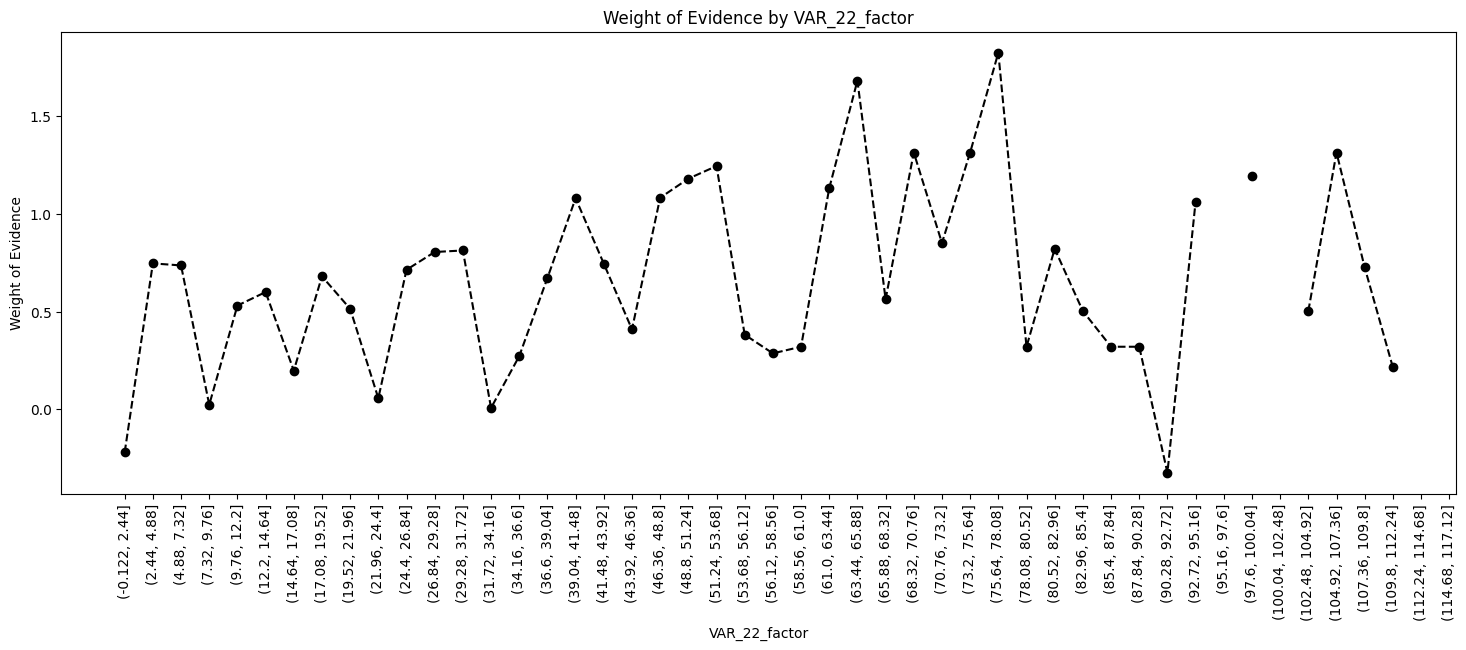

In [82]:
# Fine classing - VAR_22
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_22'])]
df_inputs_prepr_temp[f'VAR_22_factor'] = pd.cut(df_inputs_prepr_temp['VAR_22'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_22_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [83]:
df_inputs_prepr['VAR_22'].isnull().sum()

53

In [84]:
# VAR_22
df_inputs_prepr['VAR_22:<=2.44'] = np.where((df_inputs_prepr['VAR_22']<=2.44), 1, 0)
df_inputs_prepr['VAR_22:>2.44'] = np.where((df_inputs_prepr['VAR_22']>2.44), 1, 0)

/tmp/ipykernel_11844/3977216492.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_34_factor'] = pd.cut(df_inputs_prepr_temp['VAR_34'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_34_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0        (-3.31, 86.784]  229   617    846  0.180268  0.157172  0.190667   
1      (86.784, 172.588]  278   695    973  0.207330  0.190803  0.214771   
2     (172.588, 258.392]  262   559    821  0.174941  0.179822  0.172744   
3     (258.392, 344.196]  198   429    627  0.133603  0.135896  0.132571   
4       (344.196, 430.0]  132   287    419  0.089282  0.090597  0.088690   
5       (430.0, 515.804]   97   182    279  0.059450  0.066575  0.056242   
6     (515.804, 601.608]   73   137    210  0.044747  0.050103  0.042336   
7     (601.608, 687.412]   58    99    157  0.033454  0.039808  0.030593   
8     (687.412, 773.216]   36    70    106  0.022587  0.024708  0.021632   
9      (773.216, 859.02]   30    34     64  0.013637  0.020590  0.010507   
10     (859.02, 944.824]   16    29     45  0.009589  0.010981  0.008962   
11   (944.824, 1030.628]   13    24     37  0.007884  0.008922  0.007417   
12  (1030.628, 1116.432]   13    20     33  0.007032  0.008922  0.006180   
13  (1116.432, 1202.236]    4    12     16  0.003409  0.002745  0.003708   
14   (1202.236, 1288.04]    4     7     11  0.002344  0.002745  0.002163   
15   (1288.04, 1373.844]    2     8     10  0.002131  0.001373  0.002472   
16  (1373.844, 1459.648]    2     4      6  0.001278  0.001373  0.001236   
17  (1459.648, 1545.452]    1     2      3  0.000639  0.000686  0.000618   
18  (1545.452, 1631.256]    0     5      5  0.001065  0.000000  0.001545   
19   (1631.256, 1717.06]    0     3      3  0.000639  0.000000  0.000927   
20   (1717.06, 1802.864]    2     2      4  0.000852  0.001373  0.000618   
21  (1802.864, 1888.668]    1     3      4  0.000852  0.000686  0.000927   
22  (1888.668, 1974.472]    1     1      2  0.000426  0.000686  0.000309   
23   (2146.08, 2231.884]    0     1      1  0.000213  0.000000  0.000309   
24  (2231.884, 2317.688]    1     2      3  0.000639  0.000686  0.000618   
25  (2317.688, 2403.492]    1     0      1  0.000213  0.000686  0.000000   
26    (2489.296, 2575.1]    1     0      1  0.000213  0.000686  0.000000   
27  (2660.904, 2746.708]    0     1      1  0.000213  0.000000  0.000309   
28  (2746.708, 2832.512]    1     0      1  0.000213  0.000686  0.000000   
29   (3004.12, 3089.924]    0     1      1  0.000213  0.000000  0.000309   
30  (3089.924, 3175.728]    0     1      1  0.000213  0.000000  0.000309   
31   (3347.336, 3433.14]    1     0      1  0.000213  0.000686  0.000000   
32   (4205.376, 4291.18]    0     1      1  0.000213  0.000000  0.000309   

    DefaultRate       WoE  diff_WoE   IV  
0      0.270686  0.193189       NaN  inf  
1      0.285714  0.118332  0.074856  inf  
2      0.319123 -0.040154  0.158486  inf  
3      0.315789 -0.024769  0.015385  inf  
4      0.315036 -0.021278  0.003490  inf  
5      0.347670 -0.168663  0.147385  inf  
6      0.347619 -0.168437  0.000226  inf  
7      0.369427 -0.263282  0.094845  inf  
8      0.339623 -0.132982  0.130299  inf  
9      0.468750 -0.672795  0.539813  inf  
10     0.355556 -0.203251  0.469544  inf  
11     0.351351 -0.184854  0.018397  inf  
12     0.393939 -0.367176  0.182322  inf  
13     0.250000  0.300654  0.667829  inf  
14     0.363636 -0.238343  0.538997  inf  
15     0.200000  0.588336  0.826679  inf  
16     0.333333 -0.104811  0.693147  inf  
17     0.333333 -0.104811  0.000000  inf  
18     0.000000       inf       inf  inf  
19     0.000000       inf       NaN  inf  
20     0.500000 -0.797958       inf  inf  
21     0.250000  0.300654  1.098612  inf  
22     0.500000 -0.797958  1.098612  inf  
23     0.000000       inf       inf  inf  
24     0.333333 -0.104811       inf  inf  
25     1.000000      -inf       inf  inf  
26     1.000000      -inf       NaN  inf  
27     0.000000       inf       inf  inf  
28     1.000000      -inf       inf  inf  
29     0.000000       inf       inf  inf  
30     0.000000       inf       NaN  inf  
31     1.000000      -inf       inf  inf  
32     

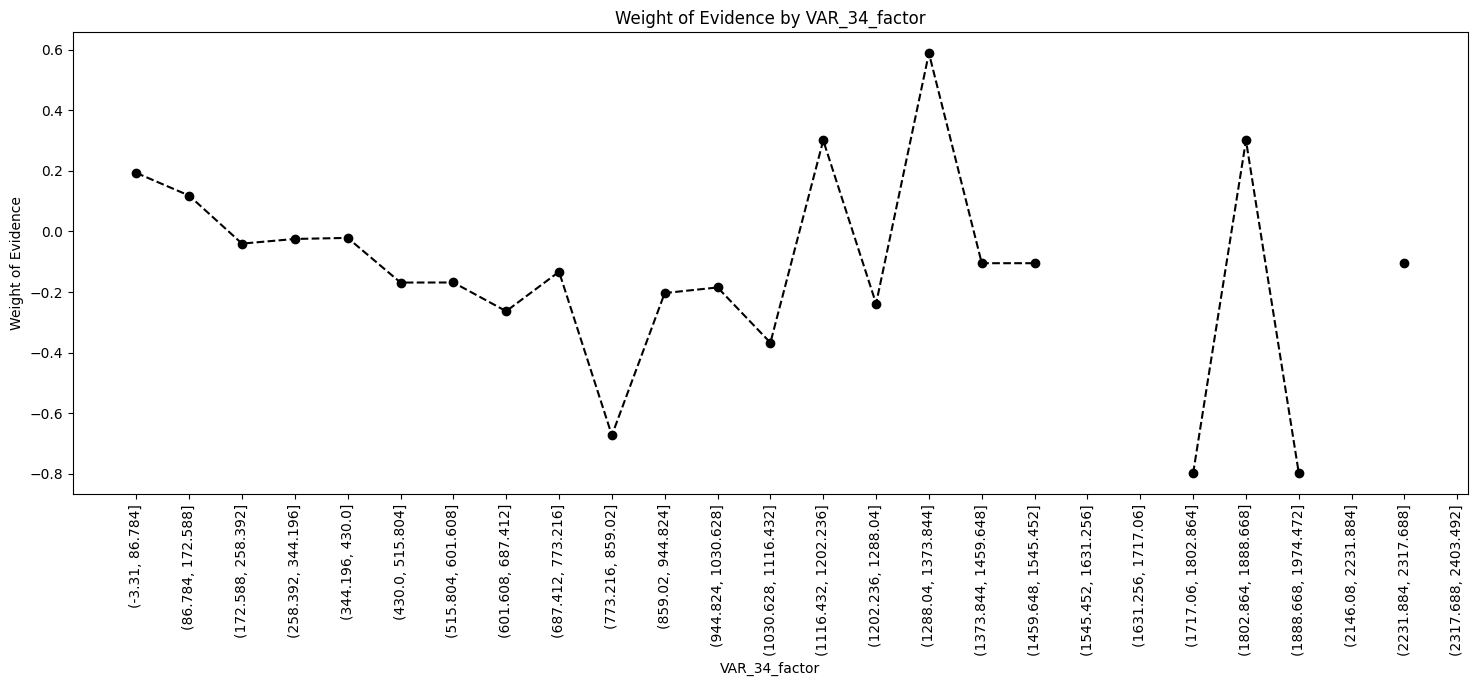

In [85]:
# Fine classing - VAR_34
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_34'])]
df_inputs_prepr_temp[f'VAR_34_factor'] = pd.cut(df_inputs_prepr_temp['VAR_34'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_34_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [86]:
df_inputs_prepr['VAR_34'].isnull().sum()

3897

/tmp/ipykernel_11844/2184336505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_35_factor'] = pd.cut(df_inputs_prepr_temp['VAR_35'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_35_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0       (-2.771, 63.601]  160   428    588  0.129004  0.119581  0.132919   
1      (63.601, 126.811]  208   535    743  0.163010  0.155456  0.166149   
2     (126.811, 190.022]  197   479    676  0.148311  0.147235  0.148758   
3     (190.022, 253.232]  171   387    558  0.122422  0.127803  0.120186   
4     (253.232, 316.443]  147   342    489  0.107284  0.109865  0.106211   
5     (316.443, 379.654]  124   250    374  0.082054  0.092676  0.077640   
6     (379.654, 442.864]   87   179    266  0.058359  0.065022  0.055590   
7     (442.864, 506.075]   48   137    185  0.040588  0.035874  0.042547   
8     (506.075, 569.285]   42   121    163  0.035761  0.031390  0.037578   
9     (569.285, 632.496]   28    76    104  0.022817  0.020927  0.023602   
10    (632.496, 695.707]   33    69    102  0.022378  0.024664  0.021429   
11    (695.707, 758.917]   20    43     63  0.013822  0.014948  0.013354   
12    (758.917, 822.128]   18    46     64  0.014041  0.013453  0.014286   
13    (822.128, 885.338]    8    24     32  0.007021  0.005979  0.007453   
14    (885.338, 948.549]   11    18     29  0.006362  0.008221  0.005590   
15    (948.549, 1011.76]    8    21     29  0.006362  0.005979  0.006522   
16    (1011.76, 1074.97]    2    15     17  0.003730  0.001495  0.004658   
17   (1074.97, 1138.181]    6    10     16  0.003510  0.004484  0.003106   
18  (1138.181, 1201.391]    0     6      6  0.001316  0.000000  0.001863   
19  (1201.391, 1264.602]    1     4      5  0.001097  0.000747  0.001242   
20  (1264.602, 1327.813]    3     5      8  0.001755  0.002242  0.001553   
21  (1327.813, 1391.023]    4     6     10  0.002194  0.002990  0.001863   
22  (1391.023, 1454.234]    1     3      4  0.000878  0.000747  0.000932   
23  (1454.234, 1517.444]    0     3      3  0.000658  0.000000  0.000932   
24  (1517.444, 1580.655]    0     2      2  0.000439  0.000000  0.000621   
25  (1580.655, 1643.866]    2     3      5  0.001097  0.001495  0.000932   
26  (1643.866, 1707.076]    2     2      4  0.000878  0.001495  0.000621   
27  (1770.287, 1833.497]    1     2      3  0.000658  0.000747  0.000621   
28  (1833.497, 1896.708]    0     1      1  0.000219  0.000000  0.000311   
29  (1896.708, 1959.919]    0     1      1  0.000219  0.000000  0.000311   
30  (1959.919, 2023.129]    0     1      1  0.000219  0.000000  0.000311   
31  (2212.761, 2275.972]    1     0      1  0.000219  0.000747  0.000000   
32  (2275.972, 2339.182]    1     0      1  0.000219  0.000747  0.000000   
33  (2402.393, 2465.603]    1     1      2  0.000439  0.000747  0.000311   
34  (2655.235, 2718.446]    1     0      1  0.000219  0.000747  0.000000   
35  (2908.078, 2971.288]    1     0      1  0.000219  0.000747  0.000000   
36   (3097.709, 3160.92]    1     0      1  0.000219  0.000747  0.000000   

    DefaultRate       WoE  diff_WoE   IV  
0      0.272109  0.105744       NaN  inf  
1      0.279946  0.066523  0.039221  inf  
2      0.291420  0.010291  0.056232  inf  
3      0.306452 -0.061444  0.071736  inf  
4      0.300613 -0.033827  0.027617  inf  
5      0.331551 -0.177026  0.143199  inf  
6      0.327068 -0.156728  0.020298  inf  
7      0.259459  0.170575  0.327302  inf  
8      0.257669  0.179916  0.009341  inf  
9      0.269231  0.120323  0.059592  inf  
10     0.323529 -0.140606  0.260930  inf  
11     0.317460 -0.112738  0.027869  inf  
12     0.281250  0.060064  0.172802  inf  
13     0.250000  0.220407  0.160343  inf  
14     0.379310 -0.385729  0.606136  inf  
15     0.275862  0.086875  0.472604  inf  
16     0.117647  1.136698  1.049822  inf  
17     0.375000 -0.367380  1.504077  inf  
18     0.000000       inf       inf  inf  
19     0.200000  0.508089       inf  inf  
20     0.375000 -0.367380  0.875469  inf  
21     0.400000 -0.472740  0.105361  inf  
22     0.250000  0.220407  0.693147  inf  
23     0.000000       inf       inf  inf  
24     0.000000       inf       NaN  inf  
25  

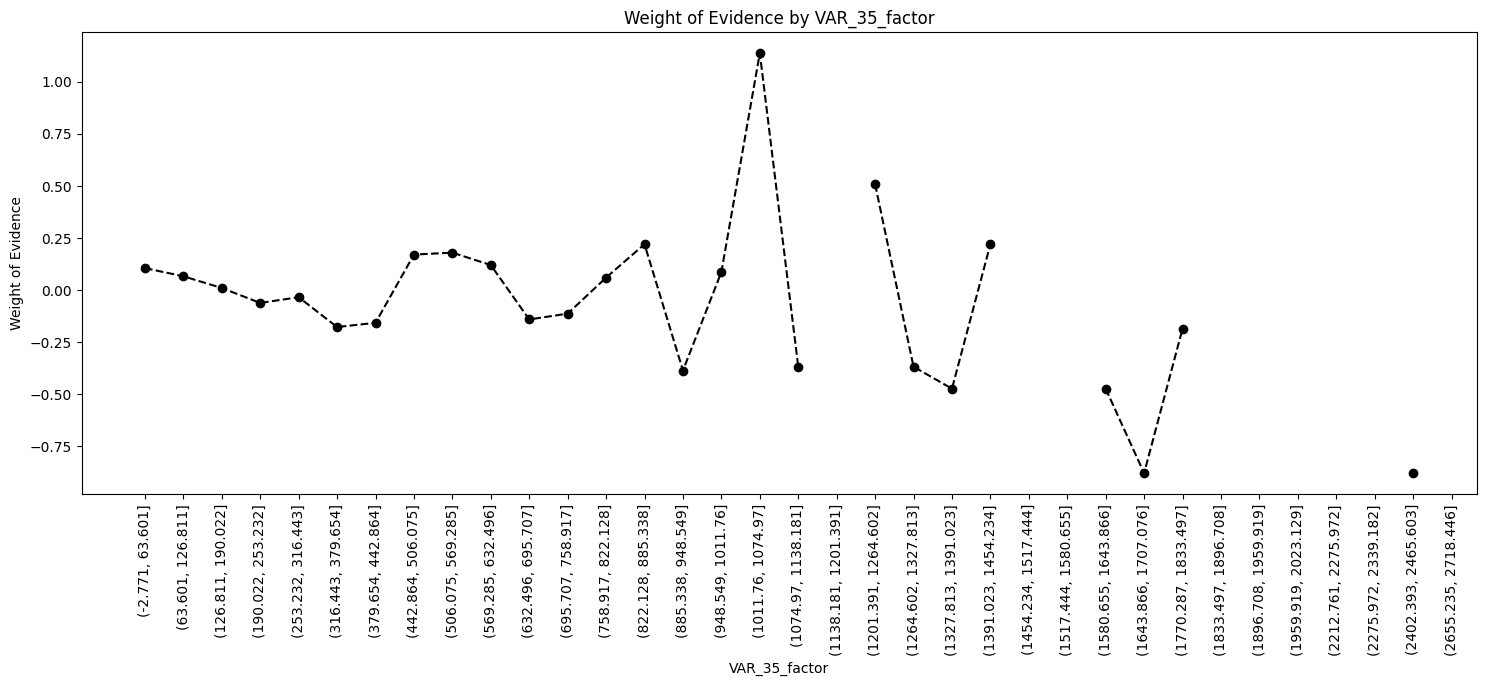

In [87]:
# Fine classing - VAR_35
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_35'])]
df_inputs_prepr_temp[f'VAR_35_factor'] = pd.cut(df_inputs_prepr_temp['VAR_35'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_35_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [88]:
df_inputs_prepr['VAR_35'].isnull().sum()

4032

In [89]:
 # VAR_35
df_inputs_prepr['VAR_35:Missing'] = np.where((df_inputs_prepr['VAR_35'].isnull()), 1, 0)
df_inputs_prepr['VAR_35:<=190.022'] = np.where((df_inputs_prepr['VAR_35']<=190.022), 1, 0)
df_inputs_prepr['VAR_35:>190.022'] = np.where((df_inputs_prepr['VAR_35']>190.022), 1, 0)

/tmp/ipykernel_11844/1873058428.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_38_factor'] = pd.cut(df_inputs_prepr_temp['VAR_38'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_38_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0        (-2.922, 58.65]  146   370    516  0.105890  0.096881  0.109923   
1        (58.65, 117.29]  196   546    742  0.152268  0.130060  0.162210   
2      (117.29, 175.929]  213   458    671  0.137698  0.141340  0.136067   
3     (175.929, 234.569]  210   487    697  0.143033  0.139350  0.144682   
4     (234.569, 293.209]  178   324    502  0.103017  0.118115  0.096257   
5     (293.209, 351.849]  144   284    428  0.087831  0.095554  0.084373   
6     (351.849, 410.489]  101   220    321  0.065873  0.067021  0.065359   
7     (410.489, 469.128]   67   157    224  0.045968  0.044459  0.046643   
8     (469.128, 527.768]   72   115    187  0.038375  0.047777  0.034165   
9     (527.768, 586.408]   44    98    142  0.029140  0.029197  0.029115   
10    (586.408, 645.048]   28    67     95  0.019495  0.018580  0.019905   
11    (645.048, 703.688]   24    55     79  0.016212  0.015926  0.016340   
12    (703.688, 762.327]   21    41     62  0.012723  0.013935  0.012181   
13    (762.327, 820.967]   16    33     49  0.010055  0.010617  0.009804   
14    (820.967, 879.607]   11    23     34  0.006977  0.007299  0.006833   
15    (879.607, 938.247]    6    20     26  0.005336  0.003981  0.005942   
16    (938.247, 996.887]    7    15     22  0.004515  0.004645  0.004456   
17   (996.887, 1055.526]    4    13     17  0.003489  0.002654  0.003862   
18  (1055.526, 1114.166]    5    12     17  0.003489  0.003318  0.003565   
19  (1114.166, 1172.806]    0     4      4  0.000821  0.000000  0.001188   
20  (1172.806, 1231.446]    3     1      4  0.000821  0.001991  0.000297   
21  (1231.446, 1290.086]    4     4      8  0.001642  0.002654  0.001188   
22  (1290.086, 1348.725]    1     6      7  0.001436  0.000664  0.001783   
23  (1348.725, 1407.365]    0     3      3  0.000616  0.000000  0.000891   
24  (1407.365, 1466.005]    2     0      2  0.000410  0.001327  0.000000   
25  (1466.005, 1524.645]    2     1      3  0.000616  0.001327  0.000297   
26  (1583.285, 1641.924]    0     1      1  0.000205  0.000000  0.000297   
27  (1641.924, 1700.564]    0     2      2  0.000410  0.000000  0.000594   
28  (1700.564, 1759.204]    1     1      2  0.000410  0.000664  0.000297   
29  (1759.204, 1817.844]    0     1      1  0.000205  0.000000  0.000297   
30  (1876.484, 1935.123]    0     1      1  0.000205  0.000000  0.000297   
31  (2169.683, 2228.322]    0     1      1  0.000205  0.000000  0.000297   
32  (2228.322, 2286.962]    0     2      2  0.000410  0.000000  0.000594   
33     (2873.36, 2932.0]    1     0      1  0.000205  0.000664  0.000000   

    DefaultRate       WoE  diff_WoE   IV  
0      0.282946  0.126292       NaN  inf  
1      0.264151  0.220900  0.094608  inf  
2      0.317437 -0.038027  0.258927  inf  
3      0.301291  0.037552  0.075580  inf  
4      0.354582 -0.204644  0.242197  inf  
5      0.336449 -0.124443  0.080201  inf  
6      0.314642 -0.025097  0.099346  inf  
7      0.299107  0.047949  0.073046  inf  
8      0.385027 -0.335338  0.383287  inf  
9      0.309859 -0.002826  0.332512  inf  
10     0.294737  0.068884  0.071710  inf  
11     0.303797  0.025675  0.043209  inf  
12     0.338710 -0.134555  0.160230  inf  
13     0.326531 -0.079685  0.054869  inf  
14     0.323529 -0.066005  0.013680  inf  
15     0.230769  0.400369  0.466374  inf  
16     0.318182 -0.041464  0.441833  inf  
17     0.235294  0.375051  0.416515  inf  
18     0.294118  0.071865  0.303186  inf  
19     0.000000       inf       inf  inf  
20     0.750000 -1.902216       inf  inf  
21     0.500000 -0.803604  1.098612  inf  
22     0.142857  0.988155  1.791759  inf  
23     0.000000       inf       inf  inf  
24     1.000000      -inf       inf  inf  
25     0.666667 -1.496751       inf  inf  
26     0.000000       inf       inf  inf  
27     0.000000       inf       NaN  inf  
28     0.500000 -0.803604       inf  inf  
29     0.000000       inf       inf  inf  
30     0.000000  

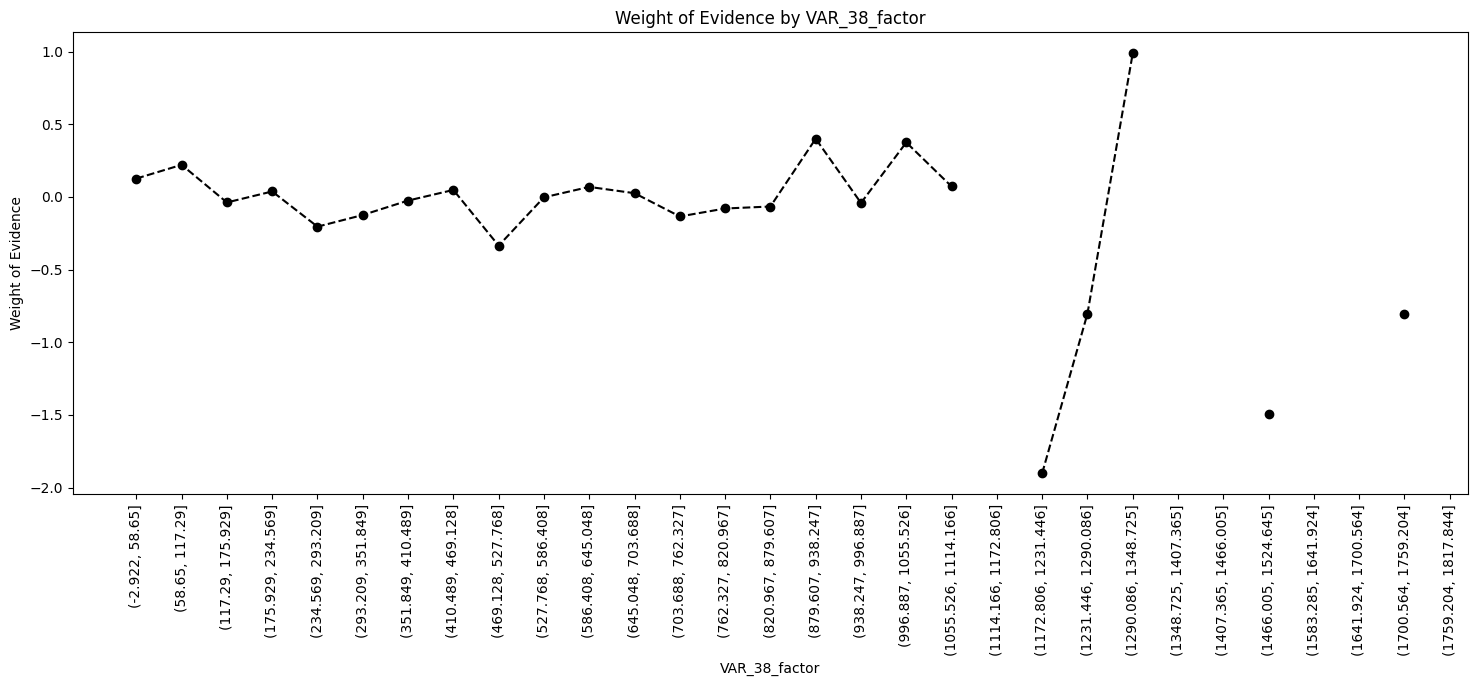

In [90]:
# Fine classing - VAR_38
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_38'])]
df_inputs_prepr_temp[f'VAR_38_factor'] = pd.cut(df_inputs_prepr_temp['VAR_38'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_38_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [91]:
df_inputs_prepr['VAR_38'].isnull().sum()

3717

/tmp/ipykernel_11844/2664807682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_45_factor'] = pd.cut(df_inputs_prepr_temp['VAR_45'],50)


VAR_45_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0      (-2.059, 61.965]   67   221    288  0.065604  0.060144  0.067460   
1      (61.965, 122.94]  126   373    499  0.113667  0.113106  0.113858   
2     (122.94, 183.915]  127   361    488  0.111162  0.114004  0.110195   
3     (183.915, 244.89]  109   364    473  0.107745  0.097846  0.111111   
4     (244.89, 305.865]  136   354    490  0.111617  0.122083  0.108059   
5     (305.865, 366.84]   96   322    418  0.095216  0.086176  0.098291   
6     (366.84, 427.815]  109   270    379  0.086333  0.097846  0.082418   
7     (427.815, 488.79]   90   214    304  0.069248  0.080790  0.065324   
8     (488.79, 549.765]   59   154    213  0.048519  0.052962  0.047009   
9     (549.765, 610.74]   47   136    183  0.041686  0.042190  0.041514   
10    (610.74, 671.715]   33    95    128  0.029157  0.029623  0.028999   
11    (671.715, 732.69]   26    75    101  0.023007  0.023339  0.022894   
12    (732.69, 793.665]   15    73     88  0.020046  0.013465  0.022283   
13    (793.665, 854.64]   15    43     58  0.013212  0.013465  0.013126   
14    (854.64, 915.615]    9    51     60  0.013667  0.008079  0.015568   
15    (915.615, 976.59]    7    28     35  0.007973  0.006284  0.008547   
16   (976.59, 1037.565]    4    22     26  0.005923  0.003591  0.006716   
17  (1037.565, 1098.54]    9    21     30  0.006834  0.008079  0.006410   
18  (1098.54, 1159.515]    4    13     17  0.003872  0.003591  0.003968   
19  (1159.515, 1220.49]    3     9     12  0.002733  0.002693  0.002747   
20  (1220.49, 1281.465]    3     8     11  0.002506  0.002693  0.002442   
21  (1281.465, 1342.44]    1    19     20  0.004556  0.000898  0.005800   
22  (1342.44, 1403.415]    3     5      8  0.001822  0.002693  0.001526   
23  (1403.415, 1464.39]    2     5      7  0.001595  0.001795  0.001526   
24  (1464.39, 1525.365]    1     6      7  0.001595  0.000898  0.001832   
25  (1525.365, 1586.34]    1     9     10  0.002278  0.000898  0.002747   
26  (1586.34, 1647.315]    2     4      6  0.001367  0.001795  0.001221   
27  (1647.315, 1708.29]    3     4      7  0.001595  0.002693  0.001221   
28  (1708.29, 1769.265]    1     1      2  0.000456  0.000898  0.000305   
29  (1769.265, 1830.24]    0     2      2  0.000456  0.000000  0.000611   
30  (1830.24, 1891.215]    1     3      4  0.000911  0.000898  0.000916   
31  (1891.215, 1952.19]    2     3      5  0.001139  0.001795  0.000916   
32  (2013.165, 2074.14]    0     1      1  0.000228  0.000000  0.000305   
33  (2074.14, 2135.115]    0     1      1  0.000228  0.000000  0.000305   
34  (2135.115, 2196.09]    3     1      4  0.000911  0.002693  0.000305   
35  (2379.015, 2439.99]    0     2      2  0.000456  0.000000  0.000611   
36  (2500.965, 2561.94]    0     1      1  0.000228  0.000000  0.000305   
37  (2988.765, 3049.74]    0     2      2  0.000456  0.000000  0.000611   

    DefaultRate       WoE  diff_WoE   IV  
0      0.232639  0.114804       NaN  inf  
1      0.252505  0.006630  0.108174  inf  
2      0.260246 -0.033975  0.040606  inf  
3      0.230444  0.127140  0.161115  inf  
4      0.277551 -0.122024  0.249164  inf  
5      0.229665  0.131537  0.253561  inf  
6      0.287599 -0.171592  0.303129  inf  
7      0.296053 -0.212500  0.040908  inf  
8      0.276995 -0.119251  0.093249  inf  
9      0.256831 -0.016159  0.103092  inf  
10     0.257812 -0.021297  0.005138  inf  
11     0.257426 -0.019274  0.002022  inf  
12     0.170455  0.503743  0.523018  inf  
13     0.258621 -0.025516  0.529259  inf  
14     0.150000  0.655935  0.681451  inf  
15     0.200000  0.307628  0.348307  inf  
16     0.153846  0.626082  0.318454  inf  
17     0.300000 -0.231368  0.857450  inf  
18     0.235294  0.099989  0.331357  inf  
19     0.250000  0.019946  0.080043  inf  
20     0.272727 -0.097837  0.117783  inf  
21     0.050000  1.865773  1.963610  inf  
22     0.375000 -0.567840  2.433613  inf  
23     0.285714 -0.162375  0.405465  inf  
24     0.

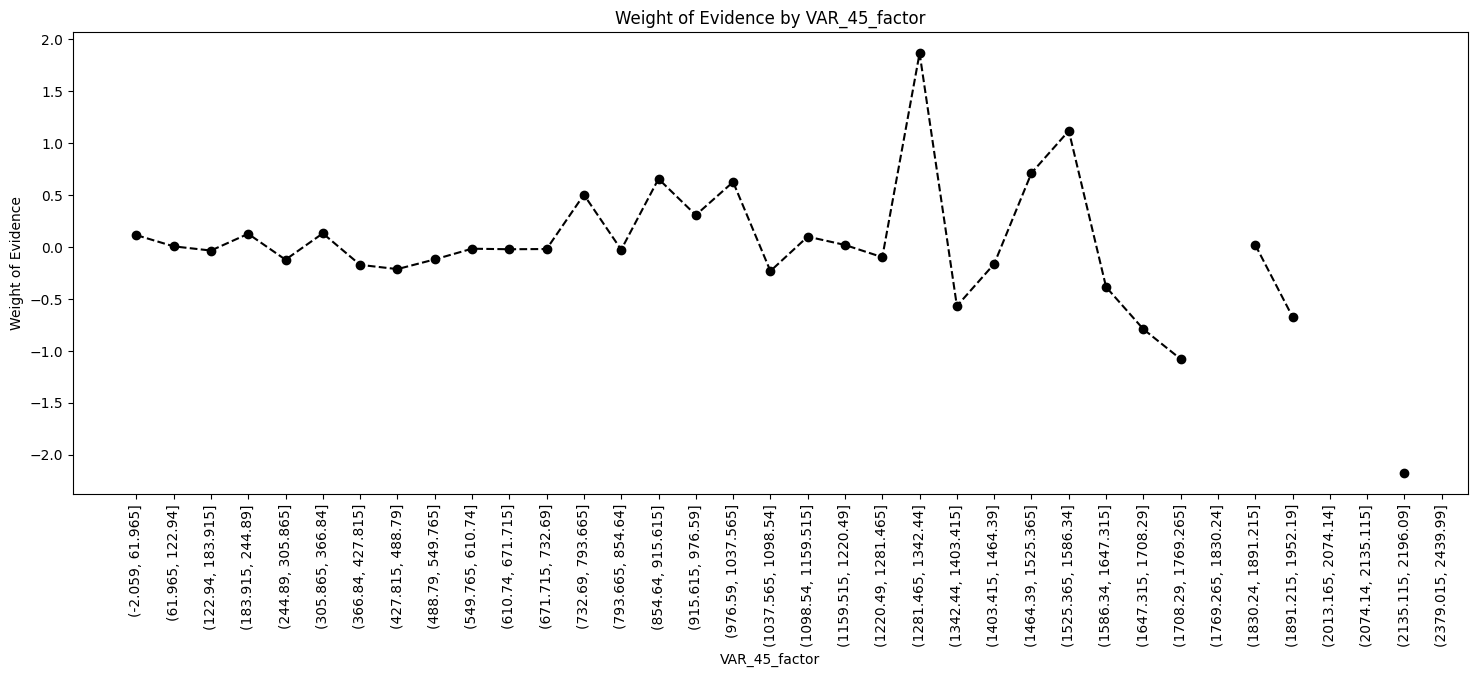

In [92]:
# Fine classing - VAR_45
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_45'])]
df_inputs_prepr_temp[f'VAR_45_factor'] = pd.cut(df_inputs_prepr_temp['VAR_45'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_45_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [93]:
df_inputs_prepr['VAR_45'].isnull().sum()

4200

/tmp/ipykernel_11844/2211771777.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_52_factor'] = pd.cut(df_inputs_prepr_temp['VAR_52'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_52_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0      (-2.851, 67.52]  175   421    596  0.131975  0.133181  0.131480   
1      (67.52, 134.54]  224   619    843  0.186670  0.170472  0.193317   
2     (134.54, 201.56]  204   512    716  0.158547  0.155251  0.159900   
3     (201.56, 268.58]  187   441    628  0.139061  0.142314  0.137726   
4      (268.58, 335.6]  151   341    492  0.108946  0.114916  0.106496   
5      (335.6, 402.62]  124   230    354  0.078388  0.094368  0.071830   
6     (402.62, 469.64]   67   166    233  0.051594  0.050989  0.051843   
7     (469.64, 536.66]   44   110    154  0.034101  0.033486  0.034354   
8     (536.66, 603.68]   42    92    134  0.029672  0.031963  0.028732   
9      (603.68, 670.7]   26    67     93  0.020593  0.019787  0.020924   
10     (670.7, 737.72]   13    49     62  0.013729  0.009893  0.015303   
11    (737.72, 804.74]   13    33     46  0.010186  0.009893  0.010306   
12    (804.74, 871.76]    8    30     38  0.008415  0.006088  0.009369   
13    (871.76, 938.78]   11    18     29  0.006422  0.008371  0.005621   
14    (938.78, 1005.8]    7    16     23  0.005093  0.005327  0.004997   
15   (1005.8, 1072.82]    4    13     17  0.003764  0.003044  0.004060   
16  (1072.82, 1139.84]    3    11     14  0.003100  0.002283  0.003435   
17  (1139.84, 1206.86]    2     2      4  0.000886  0.001522  0.000625   
18  (1206.86, 1273.88]    1     4      5  0.001107  0.000761  0.001249   
19   (1273.88, 1340.9]    2     6      8  0.001771  0.001522  0.001874   
20   (1340.9, 1407.92]    4     5      9  0.001993  0.003044  0.001562   
21  (1407.92, 1474.94]    0     4      4  0.000886  0.000000  0.001249   
22  (1474.94, 1541.96]    0     4      4  0.000886  0.000000  0.001249   
23   (1608.98, 1676.0]    1     0      1  0.000221  0.000761  0.000000   
24   (1676.0, 1743.02]    0     2      2  0.000443  0.000000  0.000625   
25  (1877.06, 1944.08]    1     2      3  0.000664  0.000761  0.000625   
26  (2078.12, 2145.14]    0     2      2  0.000443  0.000000  0.000625   
27   (2949.38, 3016.4]    0     1      1  0.000221  0.000000  0.000312   
28   (3284.48, 3351.5]    0     1      1  0.000221  0.000000  0.000312   

    DefaultRate       WoE  diff_WoE   IV  
0      0.293624 -0.012853       NaN  inf  
1      0.265718  0.125760  0.138612  inf  
2      0.284916  0.029505  0.096255  inf  
3      0.297771 -0.032763  0.062268  inf  
4      0.306911 -0.076097  0.043334  inf  
5      0.350282 -0.272902  0.196805  inf  
6      0.287554  0.016595  0.289497  inf  
7      0.285714  0.025591  0.008996  inf  
8      0.313433 -0.106581  0.132172  inf  
9      0.279570  0.055896  0.162477  inf  
10     0.209677  0.436171  0.380275  inf  
11     0.282609  0.040859  0.395313  inf  
12     0.210526  0.431056  0.390198  inf  
13     0.379310 -0.398223  0.829279  inf  
14     0.304348 -0.064021  0.334202  inf  
15     0.235294  0.287955  0.351976  inf  
16     0.214286  0.408583  0.120628  inf  
17     0.500000 -0.890700  1.299283  inf  
18     0.200000  0.495595  1.386294  inf  
19     0.250000  0.207913  0.287682  inf  
20     0.444444 -0.667556  0.875469  inf  
21     0.000000       inf       inf  inf  
22     0.000000       inf       NaN  inf  
23     1.000000      -inf       inf  inf  
24     0.000000       inf       inf  inf  
25     0.333333 -0.197553       inf  inf  
26     0.000000       inf       inf  inf  
27     0.000000       inf       NaN  inf  
28     0.000000       inf       NaN  inf

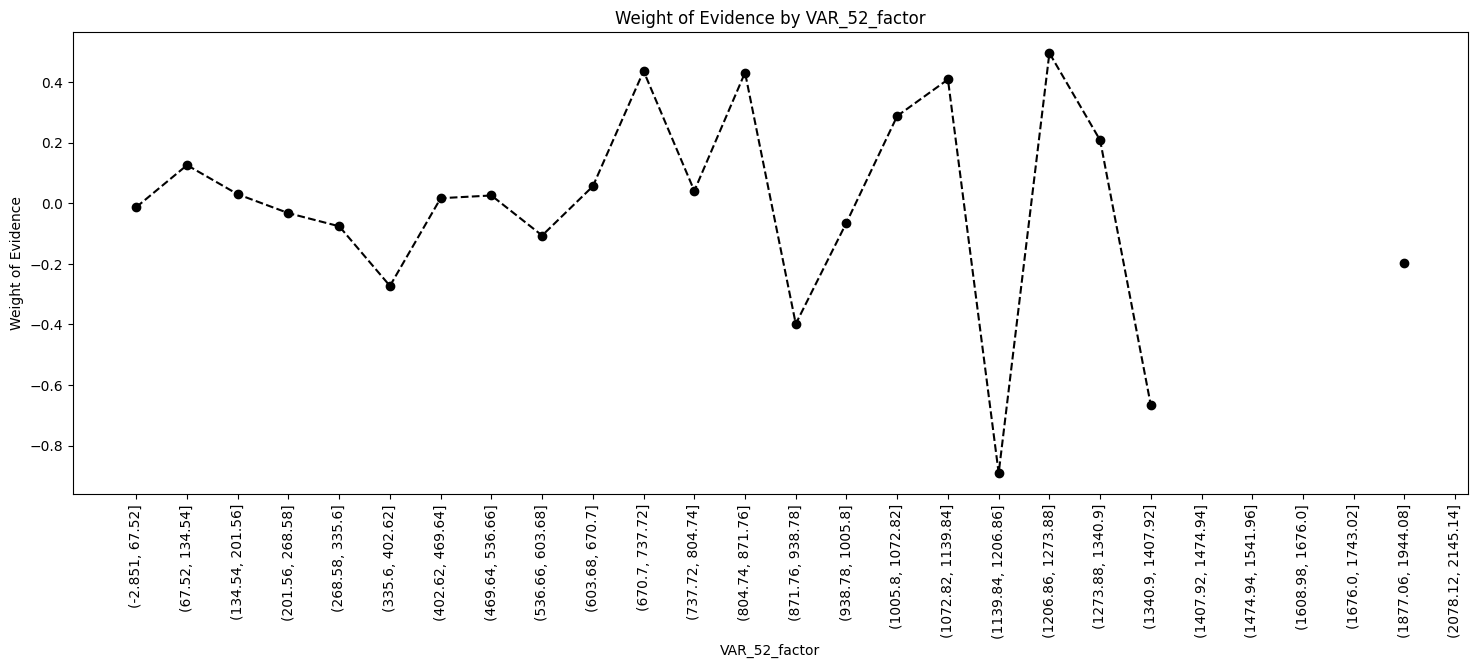

In [94]:
# Fine classing - VAR_52
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_52'])]
df_inputs_prepr_temp[f'VAR_52_factor'] = pd.cut(df_inputs_prepr_temp['VAR_52'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_52_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [95]:
df_inputs_prepr['VAR_52'].isnull().sum()

4074

/tmp/ipykernel_11844/2270973270.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_53_factor'] = pd.cut(df_inputs_prepr_temp['VAR_53'],50)


VAR_53_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0        (-8.603, 579.042]  217   848   1065  0.148184  0.109100  0.163140   
1      (579.042, 1138.704]  483  1207   1690  0.235147  0.242836  0.232205   
2     (1138.704, 1698.366]  319   682   1001  0.139279  0.160382  0.131204   
3     (1698.366, 2258.028]  304   657    961  0.133714  0.152841  0.126395   
4      (2258.028, 2817.69]  144   381    525  0.073049  0.072398  0.073297   
5      (2817.69, 3377.352]  144   324    468  0.065118  0.072398  0.062332   
6     (3377.352, 3937.014]   68   208    276  0.038403  0.034188  0.040015   
7     (3937.014, 4496.676]   65   181    246  0.034228  0.032680  0.034821   
8     (4496.676, 5056.338]   62   170    232  0.032281  0.031171  0.032705   
9       (5056.338, 5616.0]   43   113    156  0.021706  0.021619  0.021739   
10      (5616.0, 6175.662]   29    85    114  0.015862  0.014580  0.016352   
11    (6175.662, 6735.324]   22    59     81  0.011270  0.011061  0.011351   
12    (6735.324, 7294.986]   19    49     68  0.009462  0.009553  0.009427   
13    (7294.986, 7854.648]   12    27     39  0.005426  0.006033  0.005194   
14     (7854.648, 8414.31]   10    38     48  0.006679  0.005028  0.007311   
15     (8414.31, 8973.972]    4    19     23  0.003200  0.002011  0.003655   
16    (8973.972, 9533.634]    6    28     34  0.004731  0.003017  0.005387   
17   (9533.634, 10093.296]   10    18     28  0.003896  0.005028  0.003463   
18  (10093.296, 10652.958]    3     9     12  0.001670  0.001508  0.001731   
19   (10652.958, 11212.62]    6    23     29  0.004035  0.003017  0.004425   
20   (11212.62, 11772.282]    3    13     16  0.002226  0.001508  0.002501   
21  (11772.282, 12331.944]    2     8     10  0.001391  0.001006  0.001539   
22  (12331.944, 12891.606]    2     8     10  0.001391  0.001006  0.001539   
23  (12891.606, 13451.268]    3     8     11  0.001531  0.001508  0.001539   
24   (13451.268, 14010.93]    2     4      6  0.000835  0.001006  0.000770   
25   (14010.93, 14570.592]    1     3      4  0.000557  0.000503  0.000577   
26  (14570.592, 15130.254]    1     4      5  0.000696  0.000503  0.000770   
27  (15130.254, 15689.916]    0     5      5  0.000696  0.000000  0.000962   
28  (15689.916, 16249.578]    1     2      3  0.000417  0.000503  0.000385   
29   (16249.578, 16809.24]    1     2      3  0.000417  0.000503  0.000385   
30   (16809.24, 17368.902]    0     3      3  0.000417  0.000000  0.000577   
31  (17368.902, 17928.564]    1     1      2  0.000278  0.000503  0.000192   
32  (17928.564, 18488.226]    0     1      1  0.000139  0.000000  0.000192   
33  (18488.226, 19047.888]    0     1      1  0.000139  0.000000  0.000192   
34   (19047.888, 19607.55]    1     2      3  0.000417  0.000503  0.000385   
35   (19607.55, 20167.212]    0     1      1  0.000139  0.000000  0.000192   
36  (20167.212, 20726.874]    1     2      3  0.000417  0.000503  0.000385   
37  (20726.874, 21286.536]    0     1      1  0.000139  0.000000  0.000192   
38  (21286.536, 21846.198]    0     1      1  0.000139  0.000000  0.000192   
39   (22405.86, 22965.522]    0     1      1  0.000139  0.000000  0.000192   
40   (27442.818, 28002.48]    0     1      1  0.000139  0.000000  0.000192   

    DefaultRate       WoE  diff_WoE   IV  
0      0.203756  0.402341       NaN  inf  
1      0.285799 -0.044765  0.447107  inf  
2      0.318681 -0.200803  0.156038  inf  
3      0.316337 -0.189986  0.010818  inf  
4      0.274286  0.012344  0.202330  inf  
5      0.307692 -0.149712  0.162056  inf  
6      0.246377  0.157388  0.307100  inf  
7      0.264228  0.063468  0.093921  inf  
8      0.267241  0.048022  0.015446  inf  
9      0.275641  0.005546  0.042476  inf  
10     0.254386  0.114713  0.109168  inf  
11     0.271605  0.025853  0.088860  inf  
12     0.279412 -0.013261  0.039114  inf  
13     0.307692 -0.149712  0.136451  inf  
14     0.208333  0.374359  0.524071  inf  
15     0.173913  0.597503  0.223144  inf  
16   

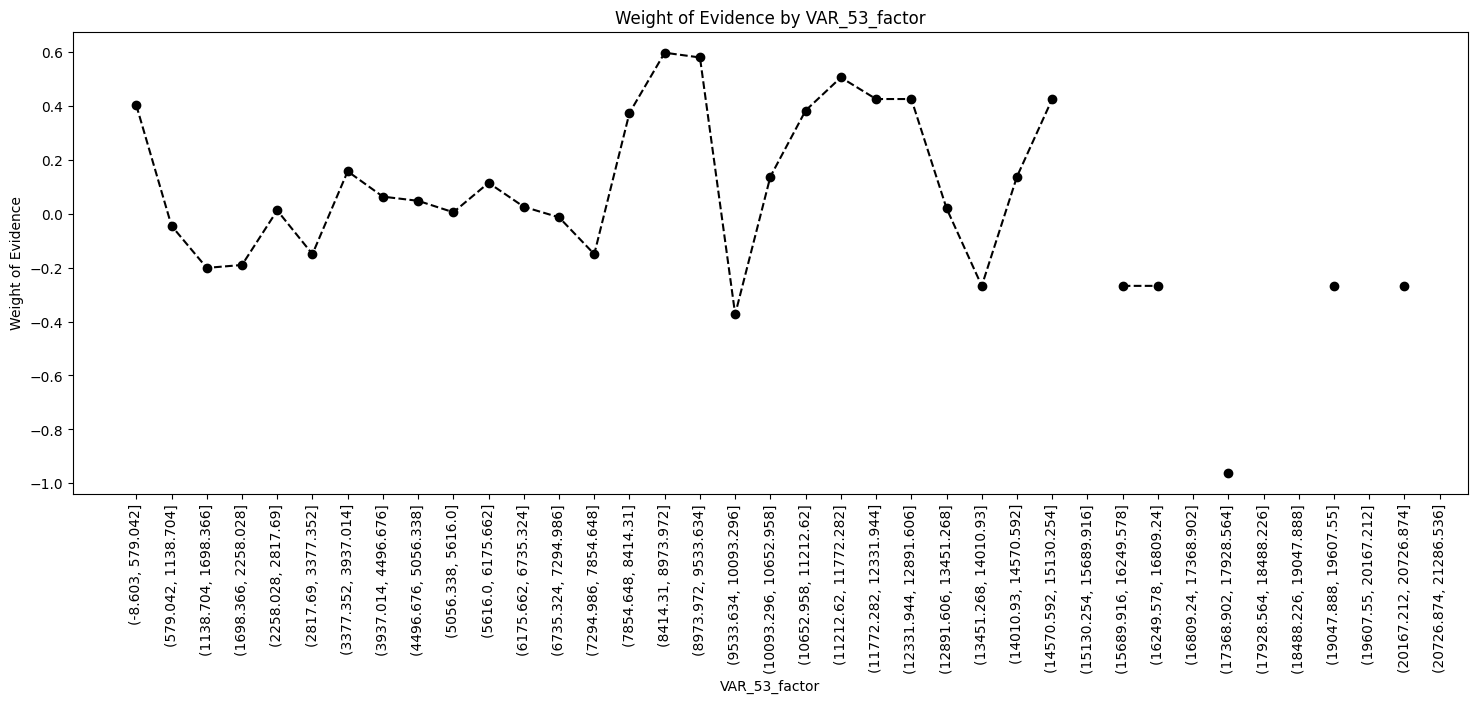

In [96]:
# Fine classing - VAR_53
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_53'])]
df_inputs_prepr_temp[f'VAR_53_factor'] = pd.cut(df_inputs_prepr_temp['VAR_53'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_53_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [97]:
df_inputs_prepr['VAR_53'].isnull().sum()

1403

In [98]:
 # VAR_53
df_inputs_prepr['VAR_53:Missing'] = np.where((df_inputs_prepr['VAR_53'].isnull()), 1, 0)
df_inputs_prepr['VAR_53:<=579.042'] = np.where((df_inputs_prepr['VAR_53']<=579.042), 1, 0)
df_inputs_prepr['VAR_53:>579.042'] = np.where((df_inputs_prepr['VAR_53']>579.042), 1, 0)

/tmp/ipykernel_11844/3312857391.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_54_factor'] = pd.cut(df_inputs_prepr_temp['VAR_54'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_54_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0        (-4.435, 338.599]   67   328    395  0.052070  0.031396  0.060161   
1       (338.599, 665.297]  256   798   1054  0.138940  0.119963  0.146368   
2       (665.297, 991.996]  285   555    840  0.110730  0.133552  0.101798   
3      (991.996, 1318.694]  475  1162   1637  0.215792  0.222587  0.213133   
4     (1318.694, 1645.393]  250   556    806  0.106248  0.117151  0.101981   
5     (1645.393, 1972.092]  120   247    367  0.048379  0.056232  0.045304   
6      (1972.092, 2298.79]  215   481    696  0.091748  0.100750  0.088225   
7      (2298.79, 2625.489]  111   266    377  0.049697  0.052015  0.048789   
8     (2625.489, 2952.187]   59   113    172  0.022673  0.027648  0.020726   
9     (2952.187, 3278.886]   69   223    292  0.038492  0.032334  0.040902   
10    (3278.886, 3605.585]   32   123    155  0.020432  0.014995  0.022561   
11    (3605.585, 3932.283]   26    63     89  0.011732  0.012184  0.011555   
12    (3932.283, 4258.982]   29    94    123  0.016214  0.013590  0.017241   
13     (4258.982, 4585.68]   12    78     90  0.011864  0.005623  0.014307   
14     (4585.68, 4912.379]   25    52     77  0.010150  0.011715  0.009538   
15    (4912.379, 5239.078]   17    57     74  0.009755  0.007966  0.010455   
16    (5239.078, 5565.776]   12    43     55  0.007250  0.005623  0.007887   
17    (5565.776, 5892.475]   11    22     33  0.004350  0.005155  0.004035   
18    (5892.475, 6219.173]    9    36     45  0.005932  0.004217  0.006603   
19    (6219.173, 6545.872]    6    17     23  0.003032  0.002812  0.003118   
20    (6545.872, 6872.571]    6    13     19  0.002505  0.002812  0.002384   
21    (6872.571, 7199.269]   12    21     33  0.004350  0.005623  0.003852   
22    (7199.269, 7525.968]    3     8     11  0.001450  0.001406  0.001467   
23    (7525.968, 7852.666]    2    10     12  0.001582  0.000937  0.001834   
24    (7852.666, 8179.365]    3    16     19  0.002505  0.001406  0.002935   
25    (8179.365, 8506.064]    3    13     16  0.002109  0.001406  0.002384   
26    (8506.064, 8832.762]    4     6     10  0.001318  0.001874  0.001101   
27    (8832.762, 9159.461]    1     9     10  0.001318  0.000469  0.001651   
28    (9159.461, 9486.159]    2     5      7  0.000923  0.000937  0.000917   
29    (9486.159, 9812.858]    2     2      4  0.000527  0.000937  0.000367   
30   (9812.858, 10139.557]    5     9     14  0.001846  0.002343  0.001651   
31  (10139.557, 10466.255]    0     1      1  0.000132  0.000000  0.000183   
32  (10466.255, 10792.954]    0     4      4  0.000527  0.000000  0.000734   
33  (10792.954, 11119.652]    0     3      3  0.000395  0.000000  0.000550   
34  (11119.652, 11446.351]    0     1      1  0.000132  0.000000  0.000183   
35   (11446.351, 11773.05]    1     4      5  0.000659  0.000469  0.000734   
36   (11773.05, 12099.748]    0     5      5  0.000659  0.000000  0.000917   
37  (12099.748, 12426.447]    0     2      2  0.000264  0.000000  0.000367   
38  (12426.447, 12753.145]    2     0      2  0.000264  0.000937  0.000000   
39  (12753.145, 13079.844]    2     1      3  0.000395  0.000937  0.000183   
40  (13406.543, 13733.241]    0     2      2  0.000264  0.000000  0.000367   
41   (13733.241, 14059.94]    0     1      1  0.000132  0.000000  0.000183   
42  (14713.337, 15040.036]    0     1      1  0.000132  0.000000  0.000183   
43   (16020.131, 16346.83]    0     1      1  0.000132  0.000000  0.000183   

    DefaultRate       WoE  diff_WoE   IV  
0      0.169620  0.650337       NaN  inf  
1      0.242884  0.198947  0.451390  inf  
2      0.339286 -0.271505  0.470452  inf  
3      0.290165 -0.043401  0.228104  inf  
4      0.310174 -0.138677  0.095276  inf  
5      0.326975 -0.216088  0.077411  inf  
6      0.308908 -0.132755  0.083333  inf  
7      0.294430 -0.064018  0.068737  inf  
8      0.343023 -0.288134  0.224116  inf  
9      0.236301  0.235081  0.523215  inf  
10     0.206452  0.408464  0.

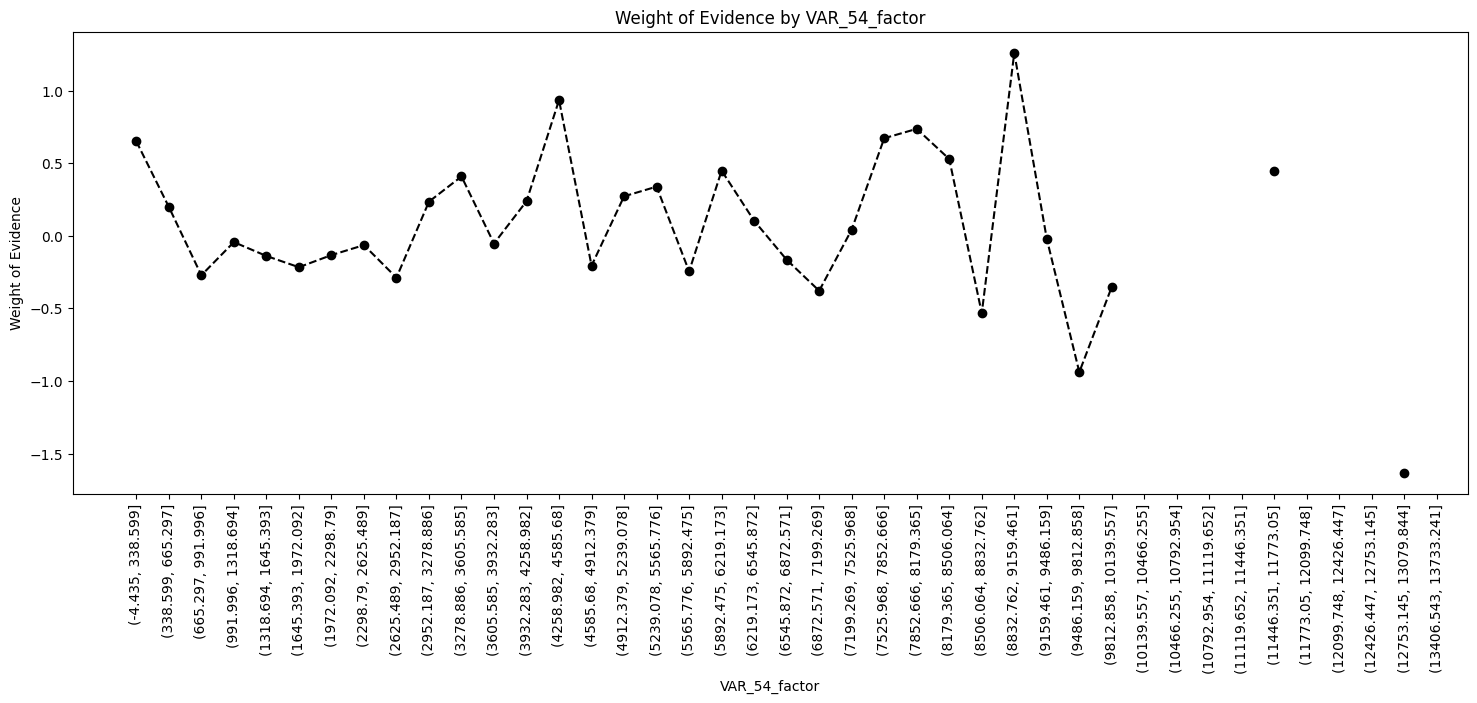

In [99]:
# Fine classing - VAR_54
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_54'])]
df_inputs_prepr_temp[f'VAR_54_factor'] = pd.cut(df_inputs_prepr_temp['VAR_54'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_54_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [100]:
df_inputs_prepr['VAR_54'].isnull().sum()

1004

In [101]:
 # VAR_54
df_inputs_prepr['VAR_54:Missing'] = np.where((df_inputs_prepr['VAR_54'].isnull()), 1, 0)
df_inputs_prepr['VAR_54:<=665.297'] = np.where((df_inputs_prepr['VAR_54']<=665.297), 1, 0)
df_inputs_prepr['VAR_54:>665.297'] = np.where((df_inputs_prepr['VAR_54']>665.297), 1, 0)

/tmp/ipykernel_11844/729330446.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_58_factor'] = pd.cut(df_inputs_prepr_temp['VAR_58'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_58_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0      (-1.412, 49.24]   60   189    249  0.046955  0.041754  0.048888   
1       (49.24, 97.48]  103   345    448  0.084480  0.071677  0.089240   
2      (97.48, 145.72]  162   407    569  0.107298  0.112735  0.105277   
3     (145.72, 193.96]  163   393    556  0.104846  0.113431  0.101655   
4      (193.96, 242.2]  151   427    578  0.108995  0.105080  0.110450   
5      (242.2, 290.44]  149   353    502  0.094663  0.103688  0.091309   
6     (290.44, 338.68]  135   343    478  0.090138  0.093946  0.088722   
7     (338.68, 386.92]  116   255    371  0.069960  0.080724  0.065960   
8     (386.92, 435.16]   87   215    302  0.056949  0.060543  0.055613   
9      (435.16, 483.4]   62   156    218  0.041109  0.043145  0.040352   
10     (483.4, 531.64]   48   143    191  0.036017  0.033403  0.036989   
11    (531.64, 579.88]   29    96    125  0.023572  0.020181  0.024832   
12    (579.88, 628.12]   43   110    153  0.028852  0.029923  0.028453   
13    (628.12, 676.36]   28    73    101  0.019046  0.019485  0.018883   
14     (676.36, 724.6]   11    57     68  0.012823  0.007655  0.014744   
15     (724.6, 772.84]   25    47     72  0.013577  0.017397  0.012157   
16    (772.84, 821.08]   10    27     37  0.006977  0.006959  0.006984   
17    (821.08, 869.32]   14    35     49  0.009240  0.009743  0.009053   
18    (869.32, 917.56]    4    29     33  0.006223  0.002784  0.007501   
19     (917.56, 965.8]    8    26     34  0.006411  0.005567  0.006725   
20    (965.8, 1014.04]    5    25     30  0.005657  0.003479  0.006467   
21  (1014.04, 1062.28]    3    16     19  0.003583  0.002088  0.004139   
22  (1062.28, 1110.52]    6    14     20  0.003771  0.004175  0.003621   
23  (1110.52, 1158.76]    2     9     11  0.002074  0.001392  0.002328   
24   (1158.76, 1207.0]    1    10     11  0.002074  0.000696  0.002587   
25   (1207.0, 1255.24]    0    11     11  0.002074  0.000000  0.002845   
26  (1255.24, 1303.48]    0    11     11  0.002074  0.000000  0.002845   
27  (1303.48, 1351.72]    0     6      6  0.001131  0.000000  0.001552   
28  (1351.72, 1399.96]    3    10     13  0.002451  0.002088  0.002587   
29   (1399.96, 1448.2]    0     2      2  0.000377  0.000000  0.000517   
30   (1448.2, 1496.44]    2     5      7  0.001320  0.001392  0.001293   
31  (1496.44, 1544.68]    2     3      5  0.000943  0.001392  0.000776   
32  (1544.68, 1592.92]    1     2      3  0.000566  0.000696  0.000517   
33  (1592.92, 1641.16]    0     1      1  0.000189  0.000000  0.000259   
34   (1689.4, 1737.64]    1     0      1  0.000189  0.000696  0.000000   
35  (1737.64, 1785.88]    0     2      2  0.000377  0.000000  0.000517   
36  (1785.88, 1834.12]    0     2      2  0.000377  0.000000  0.000517   
37  (1834.12, 1882.36]    1     0      1  0.000189  0.000696  0.000000   
38   (1882.36, 1930.6]    1     3      4  0.000754  0.000696  0.000776   
39   (1930.6, 1978.84]    1     0      1  0.000189  0.000696  0.000000   
40   (2171.8, 2220.04]    0     2      2  0.000377  0.000000  0.000517   
41  (2220.04, 2268.28]    0     1      1  0.000189  0.000000  0.000259   
42  (2268.28, 2316.52]    0     2      2  0.000377  0.000000  0.000517   
43  (2316.52, 2364.76]    0     1      1  0.000189  0.000000  0.000259   
44   (2364.76, 2413.0]    0     2      2  0.000377  0.000000  0.000517   

    DefaultRate       WoE  diff_WoE   IV  
0      0.240964  0.157740       NaN  inf  
1      0.229911  0.219153  0.061413  inf  
2      0.284710 -0.068446  0.287599  inf  
3      0.293165 -0.109603  0.041157  inf  
4      0.261246  0.049841  0.159445  inf  
5      0.296813 -0.127141  0.176982  inf  
6      0.282427 -0.057207  0.069934  inf  
7      0.312668 -0.201989  0.144782  inf  
8      0.288079 -0.084933  0.117057  inf  
9      0.284404 -0.066941  0.017992  inf  
10     0.251309  0.101981  0.168922  inf  
11     0.232000  0.207390  0.105409  inf  
12     0.281046 -0.050383  0.257772  inf  
13

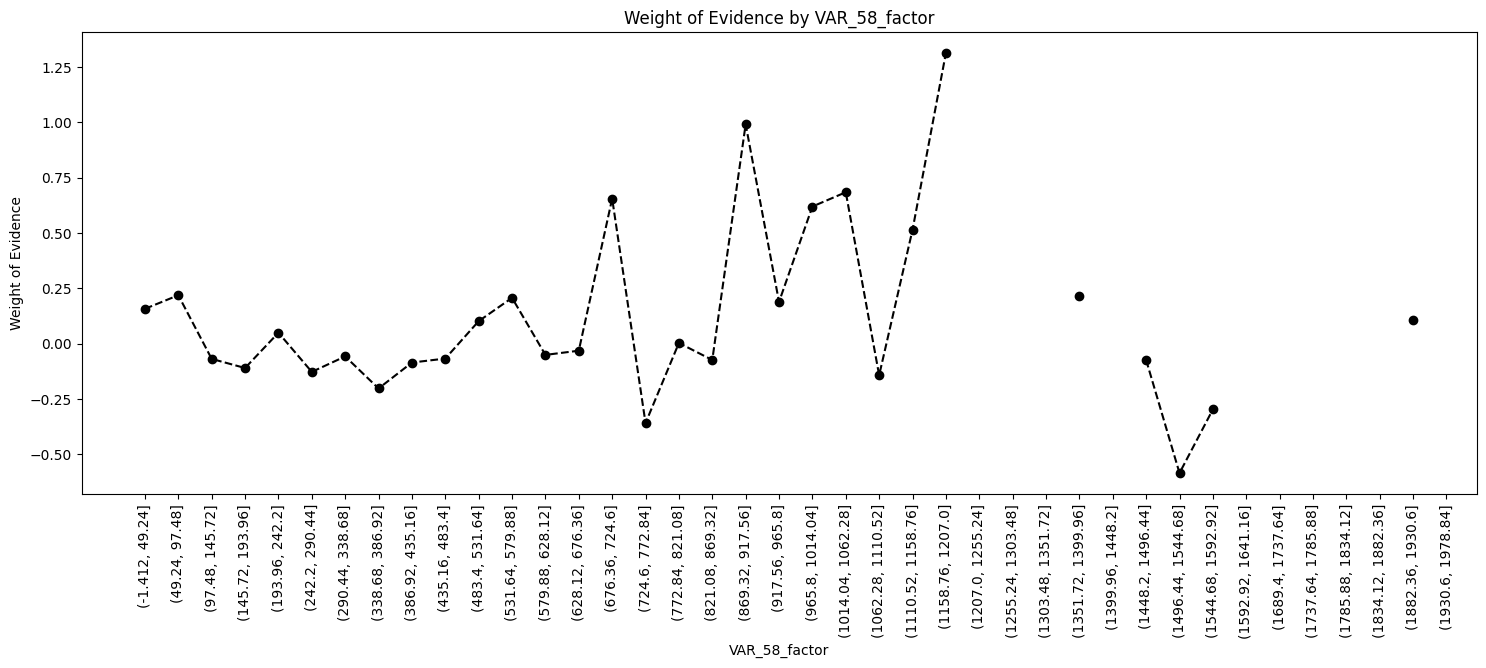

In [102]:
# Fine classing - VAR_58
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_58'])]
df_inputs_prepr_temp[f'VAR_58_factor'] = pd.cut(df_inputs_prepr_temp['VAR_58'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_58_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [103]:
df_inputs_prepr['VAR_58'].isnull().sum()

3287

/tmp/ipykernel_11844/837560223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_59_factor'] = pd.cut(df_inputs_prepr_temp['VAR_59'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_59_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0        (-2.15, 42.991]  144   396    540  0.109400  0.117168  0.106825   
1       (42.991, 85.982]   96   299    395  0.080024  0.078112  0.080658   
2      (85.982, 128.973]  104   287    391  0.079214  0.084622  0.077421   
3     (128.973, 171.964]   97   295    392  0.079417  0.078926  0.079579   
4     (171.964, 214.955]  101   272    373  0.075567  0.082181  0.073375   
5     (214.955, 257.946]   94   301    395  0.080024  0.076485  0.081198   
6     (257.946, 300.937]   97   255    352  0.071313  0.078926  0.068789   
7     (300.937, 343.928]   99   229    328  0.066451  0.080553  0.061775   
8     (343.928, 386.919]   60   227    287  0.058144  0.048820  0.061236   
9      (386.919, 429.91]   70   192    262  0.053079  0.056957  0.051794   
10     (429.91, 472.901]   47   161    208  0.042139  0.038242  0.043431   
11    (472.901, 515.892]   41   131    172  0.034846  0.033360  0.035339   
12    (515.892, 558.883]   32    99    131  0.026540  0.026037  0.026706   
13    (558.883, 601.874]   36   115    151  0.030592  0.029292  0.031022   
14    (601.874, 644.865]   14    78     92  0.018639  0.011391  0.021041   
15    (644.865, 687.856]   17    61     78  0.015802  0.013832  0.016455   
16    (687.856, 730.847]   17    46     63  0.012763  0.013832  0.012409   
17    (730.847, 773.838]   14    34     48  0.009724  0.011391  0.009172   
18    (773.838, 816.829]    7    50     57  0.011548  0.005696  0.013488   
19     (816.829, 859.82]    7    24     31  0.006280  0.005696  0.006474   
20     (859.82, 902.811]    7    20     27  0.005470  0.005696  0.005395   
21    (902.811, 945.802]    4    18     22  0.004457  0.003255  0.004856   
22    (945.802, 988.793]    3    17     20  0.004052  0.002441  0.004586   
23   (988.793, 1031.784]    3    20     23  0.004660  0.002441  0.005395   
24  (1031.784, 1074.775]    5     8     13  0.002634  0.004068  0.002158   
25  (1074.775, 1117.766]    3    13     16  0.003241  0.002441  0.003507   
26  (1117.766, 1160.757]    1    10     11  0.002229  0.000814  0.002698   
27  (1160.757, 1203.748]    2    10     12  0.002431  0.001627  0.002698   
28  (1203.748, 1246.739]    1     4      5  0.001013  0.000814  0.001079   
29   (1246.739, 1289.73]    1     3      4  0.000810  0.000814  0.000809   
30   (1289.73, 1332.721]    1     2      3  0.000608  0.000814  0.000540   
31  (1332.721, 1375.712]    1     3      4  0.000810  0.000814  0.000809   
32  (1375.712, 1418.703]    0     5      5  0.001013  0.000000  0.001349   
33  (1418.703, 1461.694]    0     7      7  0.001418  0.000000  0.001888   
34  (1461.694, 1504.685]    0     2      2  0.000405  0.000000  0.000540   
35  (1590.667, 1633.658]    0     2      2  0.000405  0.000000  0.000540   
36  (1633.658, 1676.649]    0     3      3  0.000608  0.000000  0.000809   
37   (1676.649, 1719.64]    0     2      2  0.000405  0.000000  0.000540   
38   (1719.64, 1762.631]    0     2      2  0.000405  0.000000  0.000540   
39  (1762.631, 1805.622]    2     1      3  0.000608  0.001627  0.000270   
40  (1891.604, 1934.595]    0     1      1  0.000203  0.000000  0.000270   
41  (1977.586, 2020.577]    0     1      1  0.000203  0.000000  0.000270   
42  (2020.577, 2063.568]    0     1      1  0.000203  0.000000  0.000270   
43   (2106.559, 2149.55]    1     0      1  0.000203  0.000814  0.000000   

    DefaultRate       WoE  diff_WoE   IV  
0      0.266667 -0.092421       NaN  inf  
1      0.243038  0.032073  0.124494  inf  
2      0.265985 -0.088931  0.121004  inf  
3      0.247449  0.008242  0.097173  inf  
4      0.270777 -0.113341  0.121583  inf  
5      0.237975  0.059793  0.173134  inf  
6      0.275568 -0.137470  0.197263  inf  
7      0.301829 -0.265420  0.127950  inf  
8      0.209059  0.226583  0.492003  inf  
9      0.267176 -0.095022  0.321605  inf  
10     0.225962  0.127235  0.222257  inf  
11     0.238372  0.057603  0.069632  inf  
12     0.244275  0.025362  0.03

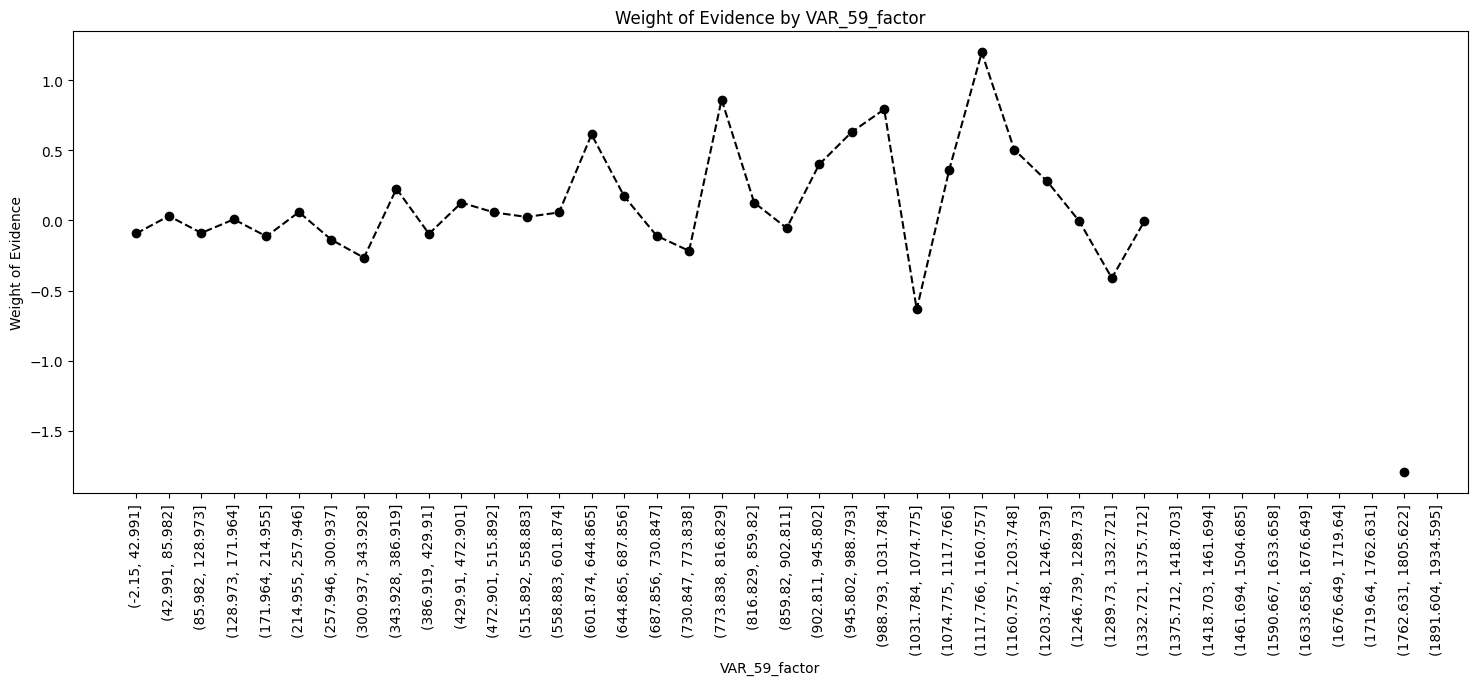

In [104]:
# Fine classing - VAR_59
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_59'])]
df_inputs_prepr_temp[f'VAR_59_factor'] = pd.cut(df_inputs_prepr_temp['VAR_59'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_59_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [105]:
df_inputs_prepr['VAR_59'].isnull().sum()

3654

/tmp/ipykernel_11844/276334851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_65_factor'] = pd.cut(df_inputs_prepr_temp['VAR_65'],50)
/home/fabiana/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


VAR_65_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0       (-14.004, 280.084]  527   765   1292  0.190308  0.252637  0.162662   
1       (280.084, 560.167]  491   862   1353  0.199293  0.235379  0.183287   
2       (560.167, 840.251]  319   749   1068  0.157313  0.152924  0.159260   
3      (840.251, 1120.334]  251   531    782  0.115186  0.120326  0.112907   
4     (1120.334, 1400.418]  141   399    540  0.079540  0.067593  0.084839   
5     (1400.418, 1680.502]   85   297    382  0.056267  0.040748  0.063151   
6     (1680.502, 1960.585]   71   195    266  0.039181  0.034036  0.041463   
7     (1960.585, 2240.669]   32   146    178  0.026219  0.015340  0.031044   
8     (2240.669, 2520.752]   35   125    160  0.023568  0.016779  0.026579   
9     (2520.752, 2800.836]   25    76    101  0.014877  0.011985  0.016160   
10     (2800.836, 3080.92]   17    80     97  0.014288  0.008150  0.017010   
11     (3080.92, 3361.003]   10    57     67  0.009869  0.004794  0.012120   
12    (3361.003, 3641.087]    8    50     58  0.008543  0.003835  0.010632   
13     (3641.087, 3921.17]   11    49     60  0.008838  0.005273  0.010419   
14     (3921.17, 4201.254]    5    36     41  0.006039  0.002397  0.007655   
15    (4201.254, 4481.338]    8    35     43  0.006334  0.003835  0.007442   
16    (4481.338, 4761.421]    6    25     31  0.004566  0.002876  0.005316   
17    (4761.421, 5041.505]    3    29     32  0.004714  0.001438  0.006166   
18    (5041.505, 5321.588]    4    23     27  0.003977  0.001918  0.004890   
19    (5321.588, 5601.672]    8    26     34  0.005008  0.003835  0.005528   
20    (5601.672, 5881.756]    4    24     28  0.004124  0.001918  0.005103   
21    (5881.756, 6161.839]    3    18     21  0.003093  0.001438  0.003827   
22    (6161.839, 6441.923]    5    15     20  0.002946  0.002397  0.003189   
23    (6441.923, 6722.006]    3    11     14  0.002062  0.001438  0.002339   
24     (6722.006, 7002.09]    2    17     19  0.002799  0.000959  0.003615   
25     (7002.09, 7282.174]    4     9     13  0.001915  0.001918  0.001914   
26    (7282.174, 7562.257]    2    12     14  0.002062  0.000959  0.002552   
27    (7562.257, 7842.341]    1     4      5  0.000736  0.000479  0.000851   
28    (7842.341, 8122.424]    1     8      9  0.001326  0.000479  0.001701   
29    (8122.424, 8402.508]    1     4      5  0.000736  0.000479  0.000851   
30    (8402.508, 8682.592]    0     3      3  0.000442  0.000000  0.000638   
31    (8682.592, 8962.675]    0     5      5  0.000736  0.000000  0.001063   
32    (8962.675, 9242.759]    0     2      2  0.000295  0.000000  0.000425   
33    (9242.759, 9522.842]    0     5      5  0.000736  0.000000  0.001063   
34    (9522.842, 9802.926]    1     3      4  0.000589  0.000479  0.000638   
35    (9802.926, 10083.01]    0     3      3  0.000442  0.000000  0.000638   
36   (10083.01, 10363.093]    0     1      1  0.000147  0.000000  0.000213   
37  (10363.093, 10643.177]    0     2      2  0.000295  0.000000  0.000425   
38  (11763.511, 12043.595]    1     0      1  0.000147  0.000479  0.000000   
39  (12043.595, 12323.678]    1     1      2  0.000295  0.000479  0.000213   
40   (13724.096, 14004.18]    0     1      1  0.000147  0.000000  0.000213   

    DefaultRate       WoE  diff_WoE   IV  
0      0.407895 -0.440277       NaN  inf  
1      0.362897 -0.250141  0.190136  inf  
2      0.298689  0.040596  0.290737  inf  
3      0.320972 -0.063643  0.104239  inf  
4      0.261111  0.227249  0.290892  inf  
5      0.222513  0.438129  0.210879  inf  
6      0.266917  0.197367  0.240761  inf  
7      0.179775  0.704918  0.507551  inf  
8      0.218750  0.460013  0.244905  inf  
9      0.247525  0.298905  0.161108  inf  
10     0.175258  0.735861  0.436956  inf  
11     0.149254  0.927514  0.191653  inf  
12     0.137931  1.019629  0.092115  inf  
13     0.183333  0.680973  0.338656  inf  
14     0.121951  1.161129  0.480156  inf  
15     0.186047  0.662954  0.498175  inf  
16   

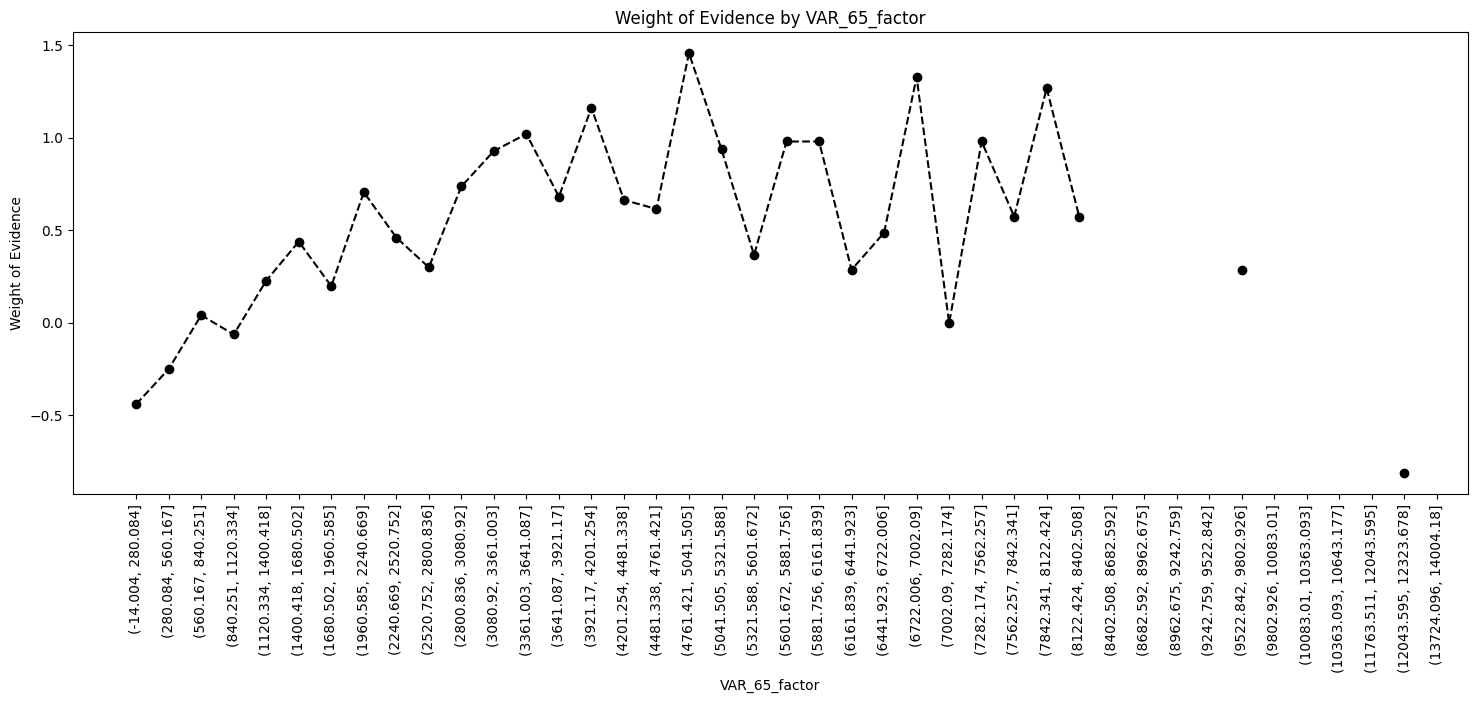

In [106]:
# Fine classing - VAR_65
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_65'])]
df_inputs_prepr_temp[f'VAR_65_factor'] = pd.cut(df_inputs_prepr_temp['VAR_65'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_65_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [107]:
df_inputs_prepr['VAR_65'].isnull().sum()

1801

In [108]:
 # VAR_65
df_inputs_prepr['VAR_65:Missing'] = np.where((df_inputs_prepr['VAR_65'].isnull()), 1, 0)
df_inputs_prepr['VAR_65:<=1120.334'] = np.where((df_inputs_prepr['VAR_65']<=1120.334), 1, 0)
df_inputs_prepr['VAR_65:>1120.334'] = np.where((df_inputs_prepr['VAR_65']>1120.334), 1, 0)

/tmp/ipykernel_11844/66303772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_72_factor'] = pd.cut(df_inputs_prepr_temp['VAR_72'],50)


VAR_72_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0   (-107.16, -40.8]  262   511    773  0.090802  0.105179  0.084856   
1      (-40.8, 22.4]  695  1468   2163  0.254082  0.279004  0.243773   
2       (22.4, 85.6]  626  1487   2113  0.248209  0.251305  0.246928   
3      (85.6, 148.8]  261   680    941  0.110537  0.104777  0.112919   
4     (148.8, 212.0]  162   449    611  0.071773  0.065034  0.074560   
5     (212.0, 275.2]  113   268    381  0.044755  0.045363  0.044503   
6     (275.2, 338.4]   76   213    289  0.033948  0.030510  0.035370   
7     (338.4, 401.6]   54   129    183  0.021497  0.021678  0.021421   
8     (401.6, 464.8]   47   140    187  0.021966  0.018868  0.023248   
9     (464.8, 528.0]   38    89    127  0.014918  0.015255  0.014779   
10    (528.0, 591.2]   25    77    102  0.011982  0.010036  0.012786   
11    (591.2, 654.4]   20    69     89  0.010455  0.008029  0.011458   
12    (654.4, 717.6]   16    61     77  0.009045  0.006423  0.010130   
13    (717.6, 780.8]   16    58     74  0.008693  0.006423  0.009631   
14    (780.8, 844.0]    9    36     45  0.005286  0.003613  0.005978   
15    (844.0, 907.2]   11    33     44  0.005169  0.004416  0.005480   
16    (907.2, 970.4]    2    25     27  0.003172  0.000803  0.004151   
17   (970.4, 1033.6]    4    28     32  0.003759  0.001606  0.004650   
18  (1033.6, 1096.8]    5    19     24  0.002819  0.002007  0.003155   
19  (1096.8, 1160.0]    8    25     33  0.003876  0.003212  0.004151   
20  (1160.0, 1223.2]   11    17     28  0.003289  0.004416  0.002823   
21  (1223.2, 1286.4]    3    17     20  0.002349  0.001204  0.002823   
22  (1286.4, 1349.6]    4    14     18  0.002114  0.001606  0.002325   
23  (1349.6, 1412.8]    4    18     22  0.002584  0.001606  0.002989   
24  (1412.8, 1476.0]    3    11     14  0.001645  0.001204  0.001827   
25  (1476.0, 1539.2]    2    13     15  0.001762  0.000803  0.002159   
26  (1539.2, 1602.4]    1     7      8  0.000940  0.000401  0.001162   
27  (1602.4, 1665.6]    2     6      8  0.000940  0.000803  0.000996   
28  (1665.6, 1728.8]    1     3      4  0.000470  0.000401  0.000498   
29  (1728.8, 1792.0]    5     6     11  0.001292  0.002007  0.000996   
30  (1792.0, 1855.2]    1     7      8  0.000940  0.000401  0.001162   
31  (1855.2, 1918.4]    1    14     15  0.001762  0.000401  0.002325   
32  (1918.4, 1981.6]    1     2      3  0.000352  0.000401  0.000332   
33  (1981.6, 2044.8]    0     4      4  0.000470  0.000000  0.000664   
34  (2044.8, 2108.0]    0     6      6  0.000705  0.000000  0.000996   
35  (2108.0, 2171.2]    1     3      4  0.000470  0.000401  0.000498   
36  (2171.2, 2234.4]    0     1      1  0.000117  0.000000  0.000166   
37  (2297.6, 2360.8]    0     2      2  0.000235  0.000000  0.000332   
38  (2360.8, 2424.0]    0     1      1  0.000117  0.000000  0.000166   
39  (2424.0, 2487.2]    0     1      1  0.000117  0.000000  0.000166   
40  (2613.6, 2676.8]    0     1      1  0.000117  0.000000  0.000166   
41  (2676.8, 2740.0]    1     2      3  0.000352  0.000401  0.000332   
42  (2992.8, 3056.0]    0     1      1  0.000117  0.000000  0.000166   

    DefaultRate       WoE  diff_WoE   IV  
0      0.338939 -0.214710       NaN  inf  
1      0.321313 -0.134991  0.079719  inf  
2      0.296261 -0.017570  0.117421  inf  
3      0.277365  0.074837  0.092407  inf  
4      0.265139  0.136691  0.061854  inf  
5      0.296588 -0.019136  0.155827  inf  
6      0.262976  0.147824  0.166960  inf  
7      0.295082 -0.011907  0.159730  inf  
8      0.251337  0.208760  0.220666  inf  
9      0.299213 -0.031685  0.240445  inf  
10     0.245098  0.242194  0.273879  inf  
11     0.224719  0.355639  0.113445  inf  
12     0.207792  0.455550  0.099911  inf  
13     0.216216  0.405119  0.050431  inf  
14     0.200000  0.503559  0.098440  inf  
15     0.250000  0.215877  0.287682  inf  
16     0.074074  1.642993  1.427116  inf  
17     0.125000  1.063175  0.579818  inf  
18     0.208333  0.45

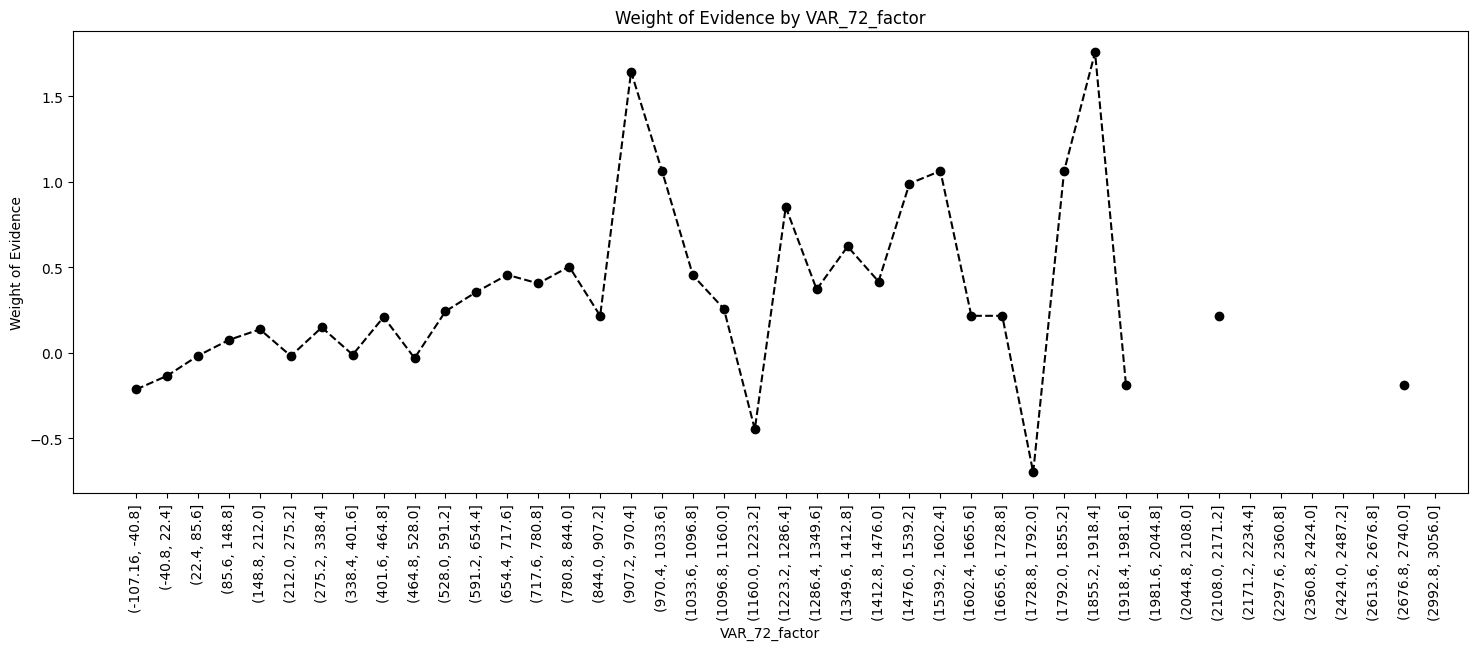

In [109]:
# Fine classing - VAR_72
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_72'])]
df_inputs_prepr_temp[f'VAR_72_factor'] = pd.cut(df_inputs_prepr_temp['VAR_72'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_72_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [110]:
df_inputs_prepr['VAR_72'].isnull().sum()

77

In [111]:
 # VAR_72
df_inputs_prepr['VAR_72:<=85.6'] = np.where((df_inputs_prepr['VAR_72']<=85.6), 1, 0)
df_inputs_prepr['VAR_72:>85.6'] = np.where((df_inputs_prepr['VAR_72']>85.6), 1, 0)

/tmp/ipykernel_11844/168625243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp[f'VAR_76_factor'] = pd.cut(df_inputs_prepr_temp['VAR_76'],50)


VAR_76_factor  Bad  Good  Total    %Total      %Bad     %Good  \
0   (-886.523, -670.166]    0     2      2  0.000405  0.000000  0.000540   
1     (-52.005, 154.049]  333   959   1292  0.261750  0.270952  0.258700   
2     (154.049, 360.103]  340  1064   1404  0.284441  0.276648  0.287025   
3     (360.103, 566.157]  226   681    907  0.183752  0.183889  0.183707   
4      (566.157, 772.21]  140   369    509  0.103120  0.113914  0.099541   
5      (772.21, 978.264]   64   228    292  0.059157  0.052075  0.061505   
6    (978.264, 1184.318]   36   132    168  0.034036  0.029292  0.035608   
7   (1184.318, 1390.372]   23    62     85  0.017220  0.018714  0.016725   
8   (1390.372, 1596.426]   18    43     61  0.012358  0.014646  0.011600   
9   (1596.426, 1802.479]   10    41     51  0.010332  0.008137  0.011060   
10  (1802.479, 2008.533]   18    31     49  0.009927  0.014646  0.008363   
11  (2008.533, 2214.587]    3    13     16  0.003241  0.002441  0.003507   
12  (2214.587, 2420.641]    2    13     15  0.003039  0.001627  0.003507   
13  (2420.641, 2626.695]    1    12     13  0.002634  0.000814  0.003237   
14  (2626.695, 2832.748]    5    13     18  0.003647  0.004068  0.003507   
15  (2832.748, 3038.802]    3     6      9  0.001823  0.002441  0.001619   
16  (3038.802, 3244.856]    4     8     12  0.002431  0.003255  0.002158   
17   (3244.856, 3450.91]    0     6      6  0.001216  0.000000  0.001619   
18   (3450.91, 3656.964]    0     5      5  0.001013  0.000000  0.001349   
19  (3656.964, 3863.017]    1     3      4  0.000810  0.000814  0.000809   
20  (3863.017, 4069.071]    0     2      2  0.000405  0.000000  0.000540   
21  (4069.071, 4275.125]    1     3      4  0.000810  0.000814  0.000809   
22  (4275.125, 4481.179]    1     2      3  0.000608  0.000814  0.000540   
23  (4481.179, 4687.233]    0     1      1  0.000203  0.000000  0.000270   
24  (4687.233, 4893.286]    0     3      3  0.000608  0.000000  0.000809   
25  (5511.448, 5717.502]    0     1      1  0.000203  0.000000  0.000270   
26  (5923.555, 6129.609]    0     1      1  0.000203  0.000000  0.000270   
27  (6541.717, 6747.771]    0     2      2  0.000405  0.000000  0.000540   
28   (9220.416, 9426.47]    0     1      1  0.000203  0.000000  0.000270   

    DefaultRate       WoE      diff_WoE   IV  
0      0.000000       inf           NaN  inf  
1      0.257740 -0.046274           inf  inf  
2      0.242165  0.036823  8.309647e-02  inf  
3      0.249173 -0.000995  3.781775e-02  inf  
4      0.275049 -0.134868  1.338731e-01  inf  
5      0.219178  0.166440  3.013083e-01  inf  
6      0.214286  0.195261  2.882044e-02  inf  
7      0.270588 -0.112382  3.076428e-01  inf  
8      0.295082 -0.233194  1.208118e-01  inf  
9      0.196078  0.306965  5.401586e-01  inf  
10     0.367347 -0.560407  8.673715e-01  inf  
11     0.187500  0.362315  9.227216e-01  inf  
12     0.133333  0.767780  4.054651e-01  inf  
13     0.076923  1.380885  6.131045e-01  inf  
14     0.277778 -0.148511  1.529395e+00  inf  
15     0.333333 -0.410875  2.623643e-01  inf  
16     0.333333 -0.410875  1.665335e-16  inf  
17     0.000000       inf           inf  inf  
18     0.000000       inf           NaN  inf  
19     0.250000 -0.005410           inf  inf  
20     0.000000       inf           inf  inf  
21     0.250000 -0.005410           inf  inf  
22     0.333333 -0.410875  4.054651e-01  inf  
23     0.000000       inf           inf  inf  
24     0.000000       inf           NaN  inf  
25     0.000000       inf           NaN  inf  
26     0.000000       inf           NaN  inf  
27     0.000000       inf           NaN  inf  
28     0.000000       inf           NaN  inf

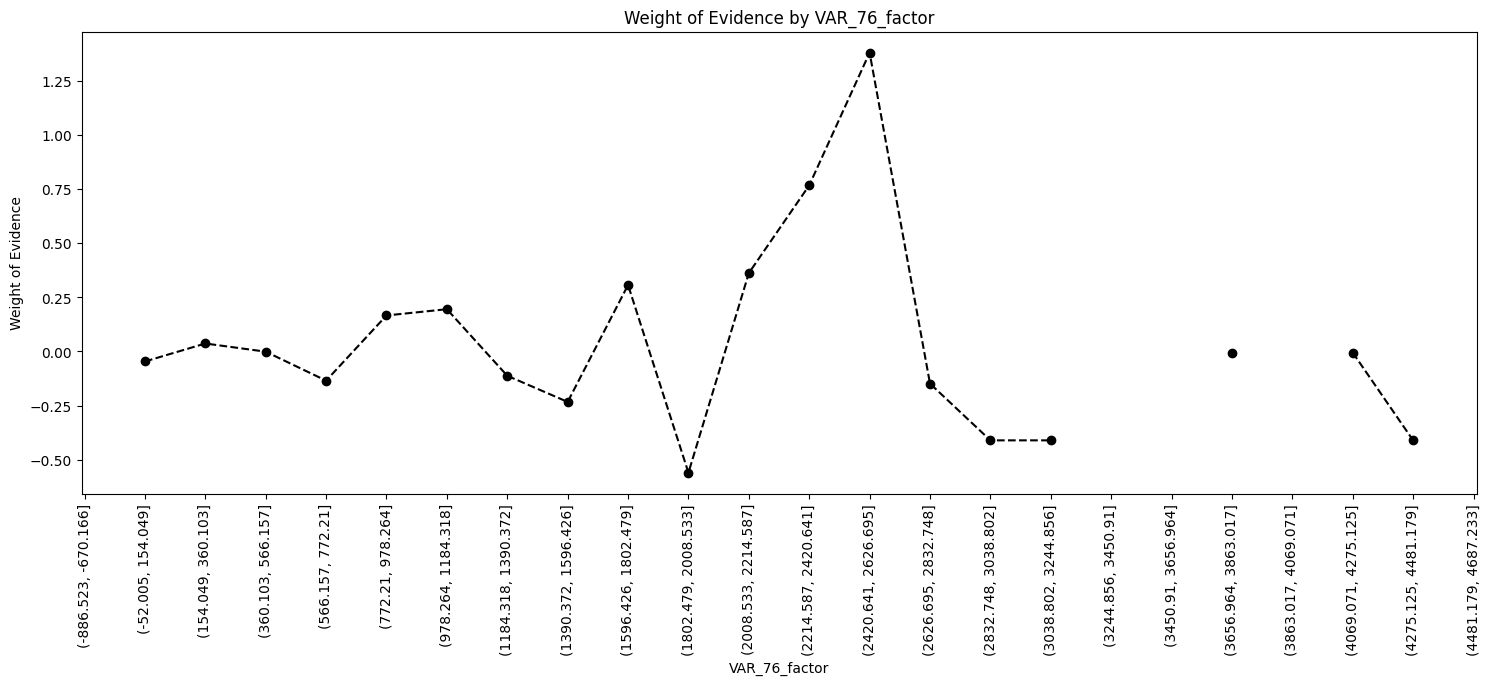

In [112]:
# Fine classing - VAR_76
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['VAR_76'])]
df_inputs_prepr_temp[f'VAR_76_factor'] = pd.cut(df_inputs_prepr_temp['VAR_76'],50)
WoE_factor = WoE_IV_Numeric(df_inputs_prepr_temp,df_targets_prepr[df_inputs_prepr_temp.index], f'VAR_76_factor')
display(WoE_factor)
plot_by_woe(WoE_factor,90)

In [113]:
df_inputs_prepr['VAR_76'].isnull().sum()

3654

In [114]:
df_inputs_prepr.columns.values

array(['Unnamed: 0', 'id', 'safra', 'y', 'VAR_1', 'VAR_2', 'VAR_3',
       'VAR_4', 'VAR_6', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_11', 'VAR_15',
       'VAR_17', 'VAR_20', 'VAR_22', 'VAR_28', 'VAR_30', 'VAR_32',
       'VAR_33', 'VAR_34', 'VAR_35', 'VAR_38', 'VAR_45', 'VAR_52',
       'VAR_53', 'VAR_54', 'VAR_58', 'VAR_59', 'VAR_60', 'VAR_64',
       'VAR_65', 'VAR_72', 'VAR_76', 'safra_dt', 'months_since_cr_line',
       'VAR_2:0', 'VAR_2:1-14_or_missing', 'VAR_3:Missing', 'VAR_3:0',
       'VAR_3:1-10', 'VAR_4:Missing', 'VAR_4:0', 'VAR_4:1-14',
       'VAR_20:3-10', 'VAR_20:11-12', 'VAR_28:Missing', 'VAR_28:0_8',
       'VAR_28:1-7_9-12', 'VAR_32:<0.13', 'VAR_32:>=0.13', 'VAR_33:0',
       'VAR_33:>0_or_missing', 'VAR_60:<-.025', 'VAR_60:-0.25to-0.004',
       'VAR_60:>-0.004', 'VAR_64:0', 'VAR_64:1',
       'months_since_cr_line:37-38', 'months_since_cr_line:39',
       'months_since_cr_line:40', 'months_since_cr_line:41-46',
       'months_since_cr_line:47-48', 'VAR_1:<=4.16', 'VAR_1:4.

### Save the train dataset

In [115]:
loan_data_inputs_train = df_inputs_prepr

In [116]:
loan_data_inputs_train.to_csv('loan_data_inputs_train.csv')
df_targets_prepr.to_csv('loan_data_targets_train.csv')